In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
import seaborn as sns
import shap
import datetime
import warnings
warnings.filterwarnings("ignore")

## ML
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
import xgboost as xgb 

In [3]:
## lets set pandas to show all the columns in the df
pd.set_option('display.max_columns', 500)

## 1. Load the data

In [4]:
cust_data = pd.read_csv("customer_data.csv")
hist_price = pd.read_csv("historical_price_data.csv")
churned_data = pd.read_csv("churn_data.csv")

In [5]:
## check out Customer data
cust_data.head()

,id,activity_new,campaign_disc_ele,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_first_activ,date_modif_prod,date_renewal,forecast_base_bill_ele,forecast_base_bill_year,forecast_bill_12m,forecast_cons,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max
0,48ada52261e7cf58715202705a0451c9,esoiiifxdlbkcsluxmfuacbdckommixw,NaN,lmkebamcaaclubfxadlmueccxoimlema,309275,0,10025,2012-11-07,2016-11-06,NaN,2012-11-07,2015-11-09,NaN,NaN,NaN,NaN,26520.30,10025,0.0,359.29,0.095919,0.088347,58.995952,f,831.8,-41.76,-41.76,1,1732.36,3,ldkssxwpmemidmecebumciepifcamkci,180.000
1,24011ae4ebbe3035111d65fa7c15bc57,NaN,NaN,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,NaN,NaN,2015-06-23,NaN,NaN,NaN,NaN,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648
2,d29c2c54acc38ff3c0614d0a653813dd,NaN,NaN,NaN,4660,0,0,2009-08-21,2016-08-30,NaN,2009-08-21,2015-08-31,NaN,NaN,NaN,NaN,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800
3,764c75f661154dac3a6c254cd082ea7d,NaN,NaN,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,NaN,2010-04-16,2015-04-17,NaN,NaN,NaN,NaN,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856
4,bba03439a292a1e166f80264c16191cb,NaN,NaN,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,NaN,2010-03-30,2015-03-31,NaN,NaN,NaN,NaN,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,f,0.0,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200


In above data we clearly see Null values , we will handle them in below sections or remove them

In [6]:
# Churn indicator data 
churned_data.head()

,id,churn
0,48ada52261e7cf58715202705a0451c9,0
1,24011ae4ebbe3035111d65fa7c15bc57,1
2,d29c2c54acc38ff3c0614d0a653813dd,0
3,764c75f661154dac3a6c254cd082ea7d,0
4,bba03439a292a1e166f80264c16191cb,0


The churn data is in correct format. 0 stands for not churn and 1 stands for churn.

In [7]:
# Historic price data
hist_price.head()

,id,price_date,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


A lot of values are 0 in the historical price dataset.

In [8]:
print(f'Total records in customer dataset :{cust_data.shape[0]}')
print(f'Total records in customer dataset :{churned_data.shape[0]}')

Total records in customer dataset :16096
Total records in customer dataset :16096


In [9]:
cust_churn = pd.merge(cust_data, churned_data, left_on='id', right_on='id', how='inner')

In [10]:
cust_churn.head()

,id,activity_new,campaign_disc_ele,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_first_activ,date_modif_prod,date_renewal,forecast_base_bill_ele,forecast_base_bill_year,forecast_bill_12m,forecast_cons,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,48ada52261e7cf58715202705a0451c9,esoiiifxdlbkcsluxmfuacbdckommixw,NaN,lmkebamcaaclubfxadlmueccxoimlema,309275,0,10025,2012-11-07,2016-11-06,NaN,2012-11-07,2015-11-09,NaN,NaN,NaN,NaN,26520.30,10025,0.0,359.29,0.095919,0.088347,58.995952,f,831.8,-41.76,-41.76,1,1732.36,3,ldkssxwpmemidmecebumciepifcamkci,180.000,0
1,24011ae4ebbe3035111d65fa7c15bc57,NaN,NaN,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,NaN,NaN,2015-06-23,NaN,NaN,NaN,NaN,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
2,d29c2c54acc38ff3c0614d0a653813dd,NaN,NaN,NaN,4660,0,0,2009-08-21,2016-08-30,NaN,2009-08-21,2015-08-31,NaN,NaN,NaN,NaN,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
3,764c75f661154dac3a6c254cd082ea7d,NaN,NaN,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,NaN,2010-04-16,2015-04-17,NaN,NaN,NaN,NaN,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0
4,bba03439a292a1e166f80264c16191cb,NaN,NaN,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,NaN,2010-03-30,2015-03-31,NaN,NaN,NaN,NaN,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,f,0.0,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0


## 2. Data Quality Assessment and Data Cleaning

#### 2.1. Data Types

The dates in cust_churn dataframe are not datetime types yet, which means we might need to convert them. In addition, we can see that the churn is full of integers so we can keep it in that form.

In [11]:
cust_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16096 entries, 0 to 16095
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        16096 non-null  object 
 1   activity_new              6551 non-null   object 
 2   campaign_disc_ele         0 non-null      float64
 3   channel_sales             11878 non-null  object 
 4   cons_12m                  16096 non-null  int64  
 5   cons_gas_12m              16096 non-null  int64  
 6   cons_last_month           16096 non-null  int64  
 7   date_activ                16096 non-null  object 
 8   date_end                  16094 non-null  object 
 9   date_first_activ          3508 non-null   object 
 10  date_modif_prod           15939 non-null  object 
 11  date_renewal              16056 non-null  object 
 12  forecast_base_bill_ele    3508 non-null   float64
 13  forecast_base_bill_year   3508 non-null   float64
 14  foreca

In [12]:
hist_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193002 entries, 0 to 193001
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            193002 non-null  object 
 1   price_date    193002 non-null  object 
 2   price_p1_var  191643 non-null  float64
 3   price_p2_var  191643 non-null  float64
 4   price_p3_var  191643 non-null  float64
 5   price_p1_fix  191643 non-null  float64
 6   price_p2_fix  191643 non-null  float64
 7   price_p3_fix  191643 non-null  float64
dtypes: float64(6), object(2)
memory usage: 11.8+ MB


#### 2.2. Descriptive Statistics

In [13]:
cust_churn.describe()

,campaign_disc_ele,cons_12m,cons_gas_12m,cons_last_month,forecast_base_bill_ele,forecast_base_bill_year,forecast_bill_12m,forecast_cons,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn
count,0.0,1.609600e+04,1.609600e+04,1.609600e+04,3508.000000,3508.000000,3508.000000,3508.000000,16096.000000,16096.000000,15970.000000,16096.000000,15970.000000,15970.000000,15970.000000,16096.000000,16083.000000,16083.000000,16096.000000,16081.000000,16096.000000,16093.000000,16096.000000
mean,NaN,1.948044e+05,3.191164e+04,1.946154e+04,335.843857,335.843857,3837.441866,206.845165,2370.555949,1907.347229,0.991547,70.309945,0.135901,0.052951,43.533496,196.123447,22.462276,21.460318,1.347788,217.987028,5.030629,20.604131,0.099093
std,NaN,6.795151e+05,1.775885e+05,8.235676e+04,649.406000,649.406000,5425.744327,455.634288,4035.085664,5257.364759,5.160969,79.023251,0.026252,0.048617,5.212252,494.366979,23.700883,27.917349,1.459808,366.742030,1.676101,21.772421,0.298796
min,NaN,-1.252760e+05,-3.037000e+03,-9.138600e+04,-364.940000,-364.940000,-2503.480000,0.000000,-16689.260000,-85627.000000,0.000000,-242.960000,0.000000,0.000000,-0.122184,-9038.210000,-525.540000,-615.660000,1.000000,-4148.990000,1.000000,1.000000,0.000000
25%,NaN,5.906250e+03,0.000000e+00,0.000000e+00,0.000000,0.000000,1158.175000,0.000000,513.230000,0.000000,0.000000,16.230000,0.115237,0.000000,40.606701,0.000000,11.960000,11.950000,1.000000,51.970000,4.000000,12.500000,0.000000
50%,NaN,1.533250e+04,0.000000e+00,9.010000e+02,162.955000,162.955000,2187.230000,42.215000,1179.160000,378.000000,0.000000,19.440000,0.142881,0.086163,44.311378,44.465000,21.090000,20.970000,1.000000,119.680000,5.000000,13.856000,0.000000
75%,NaN,5.022150e+04,0.000000e+00,4.127000e+03,396.185000,396.185000,4246.555000,228.117500,2692.077500,1994.250000,0.000000,131.470000,0.146348,0.098837,44.311378,218.090000,29.640000,29.640000,1.000000,275.810000,6.000000,19.800000,0.000000
max,NaN,1.609711e+07,4.188440e+06,4.538720e+06,12566.080000,12566.080000,81122.630000,9682.890000,103801.930000,175375.000000,50.000000,2411.690000,0.273963,0.195975,59.444710,15042.790000,374.640000,374.640000,32.000000,24570.650000,16.000000,500.000000,1.000000


In [14]:
round(cust_churn['campaign_disc_ele'].isnull().mean()*100)

100

In [15]:
hist_price.describe()

,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix
count,191643.000000,191643.000000,191643.000000,191643.000000,191643.000000,191643.000000
mean,0.140991,0.054412,0.030712,43.325546,10.698201,6.455436
std,0.025117,0.050033,0.036335,5.437952,12.856046,7.782279
min,0.000000,0.000000,0.000000,-0.177779,-0.097752,-0.065172
25%,0.125976,0.000000,0.000000,40.728885,0.000000,0.000000
50%,0.146033,0.085483,0.000000,44.266930,0.000000,0.000000
75%,0.151635,0.101780,0.072558,44.444710,24.339581,16.226389
max,0.280700,0.229788,0.114102,59.444710,36.490692,17.458221


The historical price dataset is looking fine.  
Even though the prices are negative. The prices will be made positive in the data cleaning step.

#### 2.3 Missing Values
There are a lot of missing data so we can check the percentage of missing values.

In [16]:
missing_values= (cust_churn.isnull().mean()*100).reset_index()
missing_values.rename(columns={0: 'Percentage of Missing Values'}) ## will show how much % of data is null in each column

,index,Percentage of Missing Values
0,id,0.000000
1,activity_new,59.300447
2,campaign_disc_ele,100.000000
3,channel_sales,26.205268
4,cons_12m,0.000000
5,cons_gas_12m,0.000000
6,cons_last_month,0.000000
7,date_activ,0.000000
8,date_end,0.012425
9,date_first_activ,78.205765


In [17]:
## lets check for historic data
(hist_price.isnull().mean()*100).reset_index()

,index,0
0,id,0.000000
1,price_date,0.000000
2,price_p1_var,0.704138
3,price_p2_var,0.704138
4,price_p3_var,0.704138
5,price_p1_fix,0.704138
6,price_p2_fix,0.704138
7,price_p3_fix,0.704138


Here the missing values are less so appropiate values may be imputed.

## 3. Exploratory Data Analysis

Churn

In [18]:
churn_data= cust_churn[['id', 'churn']]
churn_data.rename(columns={'id':'companies'}, inplace=True)
churn_count = churn_data.groupby(['churn']).count().reset_index()
churn_count.rename(columns={'companies': 'num'}, inplace=True)
churn_count['num'] = round(churn_count['num']/ churn_count['num'].sum()*100,1)

churn_count

,churn,num
0,0,90.1
1,1,9.9


Text(0.5, 1.0, 'Churning Status')

<Figure size 500x500 with 0 Axes>

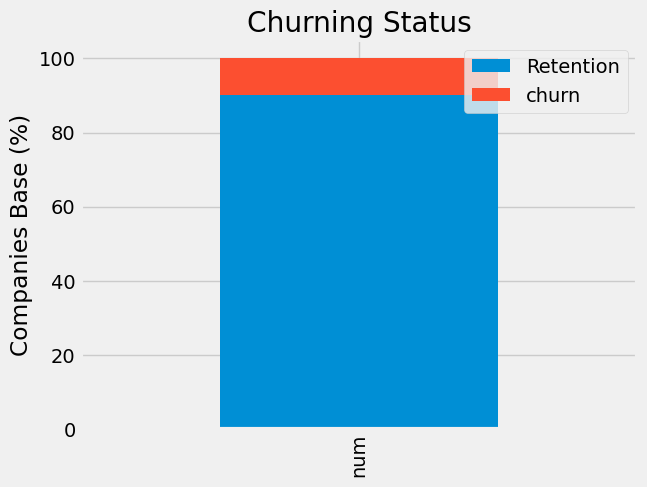

In [19]:
plt.figure(figsize=(5,5))
churn_count.transpose().drop('churn', axis=0).plot(y=[0,1], kind='bar', stacked=True)

plt.ylabel('Companies Base (%)')
plt.legend(['Retention', 'churn'], loc='upper right')
plt.title('Churning Status')

10% of customers have churned from service

## SME Activity

Lets check the category of Company's activities in relation to the clients and churn

In [20]:
sme_activity = cust_churn[['id', 'activity_new', 'churn']]

In [21]:
sme_activity.head()

,id,activity_new,churn
0,48ada52261e7cf58715202705a0451c9,esoiiifxdlbkcsluxmfuacbdckommixw,0
1,24011ae4ebbe3035111d65fa7c15bc57,NaN,1
2,d29c2c54acc38ff3c0614d0a653813dd,NaN,0
3,764c75f661154dac3a6c254cd082ea7d,NaN,0
4,bba03439a292a1e166f80264c16191cb,NaN,0


In [22]:
# Number of companies under SME Activity

num_comp_per_sme_activity = sme_activity.groupby(['activity_new', 'churn'])['id'].count().unstack(level=1)

num_comp_per_sme_activity.head()

churn,0,1
activity_new,,
aacewucldmklslcffeckexipaemmsdfk,1.0,NaN
aamfdbbldmixubpkwmdacapsfexcksdo,3.0,NaN
abdiclmommkccxulxufwiiofdakbmfum,6.0,1.0
abmaakxelmowmifxxfciwioaulelacpw,2.0,NaN
acefxcckbdxakciukwuwepweawbkwmii,17.0,4.0


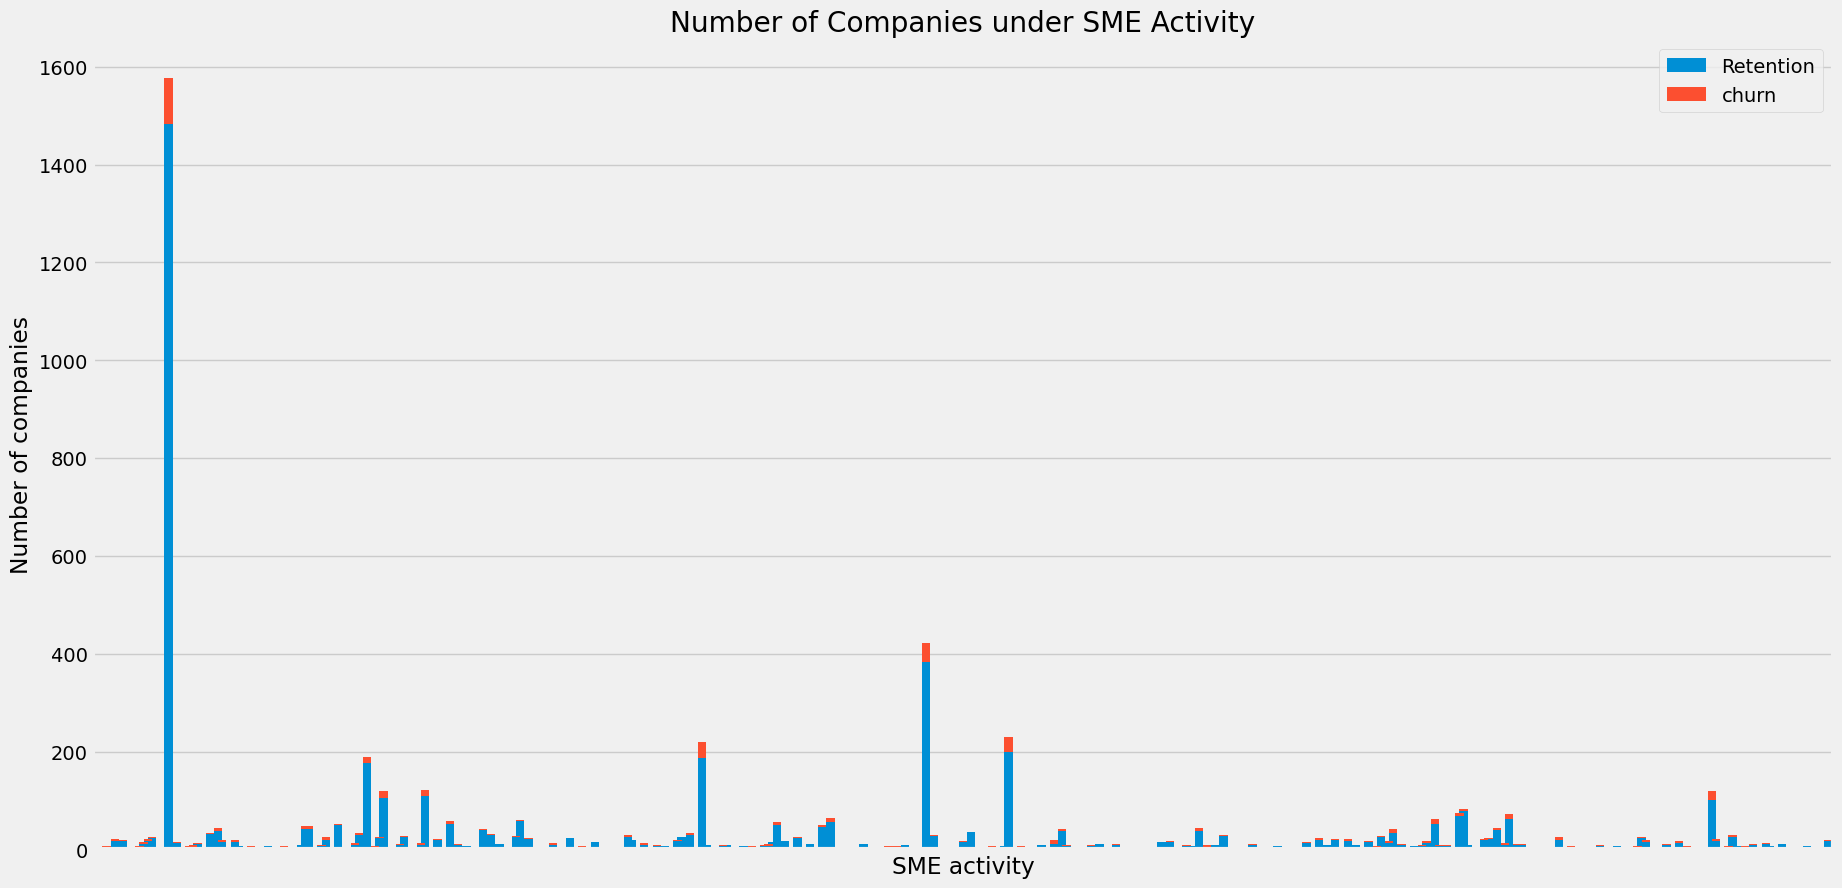

In [23]:
num_comp_per_sme_activity.plot(kind='bar', figsize=(20,10), width=2, stacked=True, title='Number of Companies under SME Activity')

plt.ylabel('Number of companies')
plt.xlabel('SME activity')

plt.legend(['Retention', 'churn'])
plt.xticks([])
plt.show()

In [24]:
sme_activity_total = num_comp_per_sme_activity.fillna(0)[0] + num_comp_per_sme_activity.fillna(0)[1]
sme_activity_total_percentage = num_comp_per_sme_activity.fillna(0)[1] / (sme_activity_total)*100
pd.DataFrame({'Churn Percentage' : sme_activity_total_percentage, 'Number of Companies': sme_activity_total}).sort_values(
    by='Churn Percentage', ascending=False).head(20)

,Churn Percentage,Number of Companies
activity_new,,
wceaopxmdpccxfmcdpopulcaubcxibuw,100.000000,1.0
oeacexidmflusdkwuuicmpiaklkxulxm,100.000000,1.0
opoiuuwdmxdssidluooopfswlkkkcsxf,100.000000,1.0
xwkaesbkfsacseixxksofpddwfkbobki,100.000000,1.0
kmlwkmxoocpieebifumobckeafmidpxf,100.000000,1.0
ikiucmkuisupefxcxfxxulkpwssppfuo,100.000000,1.0
wkwdccuiboaeaalcaawlwmldiwmpewma,100.000000,1.0
pfcocskbxlmofswiflsbcefcpufbopuo,100.000000,2.0
cwouwoubfifoafkxifokoidcuoamebea,66.666667,3.0


Our predictive model is likely to struggle accurately predicting the the SME activity due to the large number of categories and lownumber of companies belonging to each category.

In [25]:
# Function to plot stacked bars with annotations

def plot_stack_bars(df, title_,  y_label, size_=(20,10), rot_=0, legend_='upper right'):
    
    ax = df.plot(kind='bar', stacked=True, figsize=size_, rot=rot_, title=title_)
    
    annotate_plot(ax, textsize=15)
    
    plt.legend(['Retention', 'Churn'], loc=legend_)
    plt.ylabel(y_label)
    plt.show()

def annotate_plot(ax, pad=1, colour='white', textsize=14):
    
    for i in ax.patches:
        
        val = str(round(i.get_height(),1))
        
        if val=='0.0':
            continue
        ax.annotate(val , ((i.get_x()+i.get_width()/2)*pad-0.05, (i.get_y()+i.get_height()/2)*pad), color=colour, size=textsize)

## Sales Channel

The sales channel seems to be an important feature when predecting the churning of a user. It is not the same if the sales were through email or telephone.

In [26]:
sales_channel = cust_churn[['id', 'channel_sales','churn']]
sales_channel

,id,channel_sales,churn
0,48ada52261e7cf58715202705a0451c9,lmkebamcaaclubfxadlmueccxoimlema,0
1,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,1
2,d29c2c54acc38ff3c0614d0a653813dd,NaN,0
3,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,0
4,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,0
...,...,...,...
16091,18463073fb097fc0ac5d3e040f356987,foosdfpfkusacimwkcsosbicdxkicaua,0
16092,d0a6f71671571ed83b2645d23af6de00,foosdfpfkusacimwkcsosbicdxkicaua,1
16093,10e6828ddd62cbcf687cb74928c4c2d2,foosdfpfkusacimwkcsosbicdxkicaua,1
16094,1cf20fd6206d7678d5bcafd28c53b4db,foosdfpfkusacimwkcsosbicdxkicaua,0


In [27]:
sales_channel = sales_channel.groupby(['channel_sales', 'churn'])['id'].count() .unstack(level=1).fillna(0)
sales_channel

churn,0,1
channel_sales,,
epumfxlbckeskwekxbiuasklxalciiuu,4.0,0.0
ewpakwlliwisiwduibdlfmalxowmwpci,884.0,82.0
fixdbufsefwooaasfcxdxadsiekoceaa,2.0,0.0
foosdfpfkusacimwkcsosbicdxkicaua,6455.0,922.0
lmkebamcaaclubfxadlmueccxoimlema,1957.0,116.0
sddiedcslfslkckwlfkdpoeeailfpeds,12.0,0.0
usilxuppasemubllopkaafesmlibmsdf,1294.0,150.0


In [28]:
sales_channel_churn = (sales_channel.div(sales_channel.sum(axis=1), axis=0)*100).sort_values(by=[1], ascending=False)
sales_channel_churn

churn,0,1
channel_sales,,
foosdfpfkusacimwkcsosbicdxkicaua,87.501694,12.498306
usilxuppasemubllopkaafesmlibmsdf,89.612188,10.387812
ewpakwlliwisiwduibdlfmalxowmwpci,91.511387,8.488613
lmkebamcaaclubfxadlmueccxoimlema,94.404245,5.595755
epumfxlbckeskwekxbiuasklxalciiuu,100.000000,0.000000
fixdbufsefwooaasfcxdxadsiekoceaa,100.000000,0.000000
sddiedcslfslkckwlfkdpoeeailfpeds,100.000000,0.000000


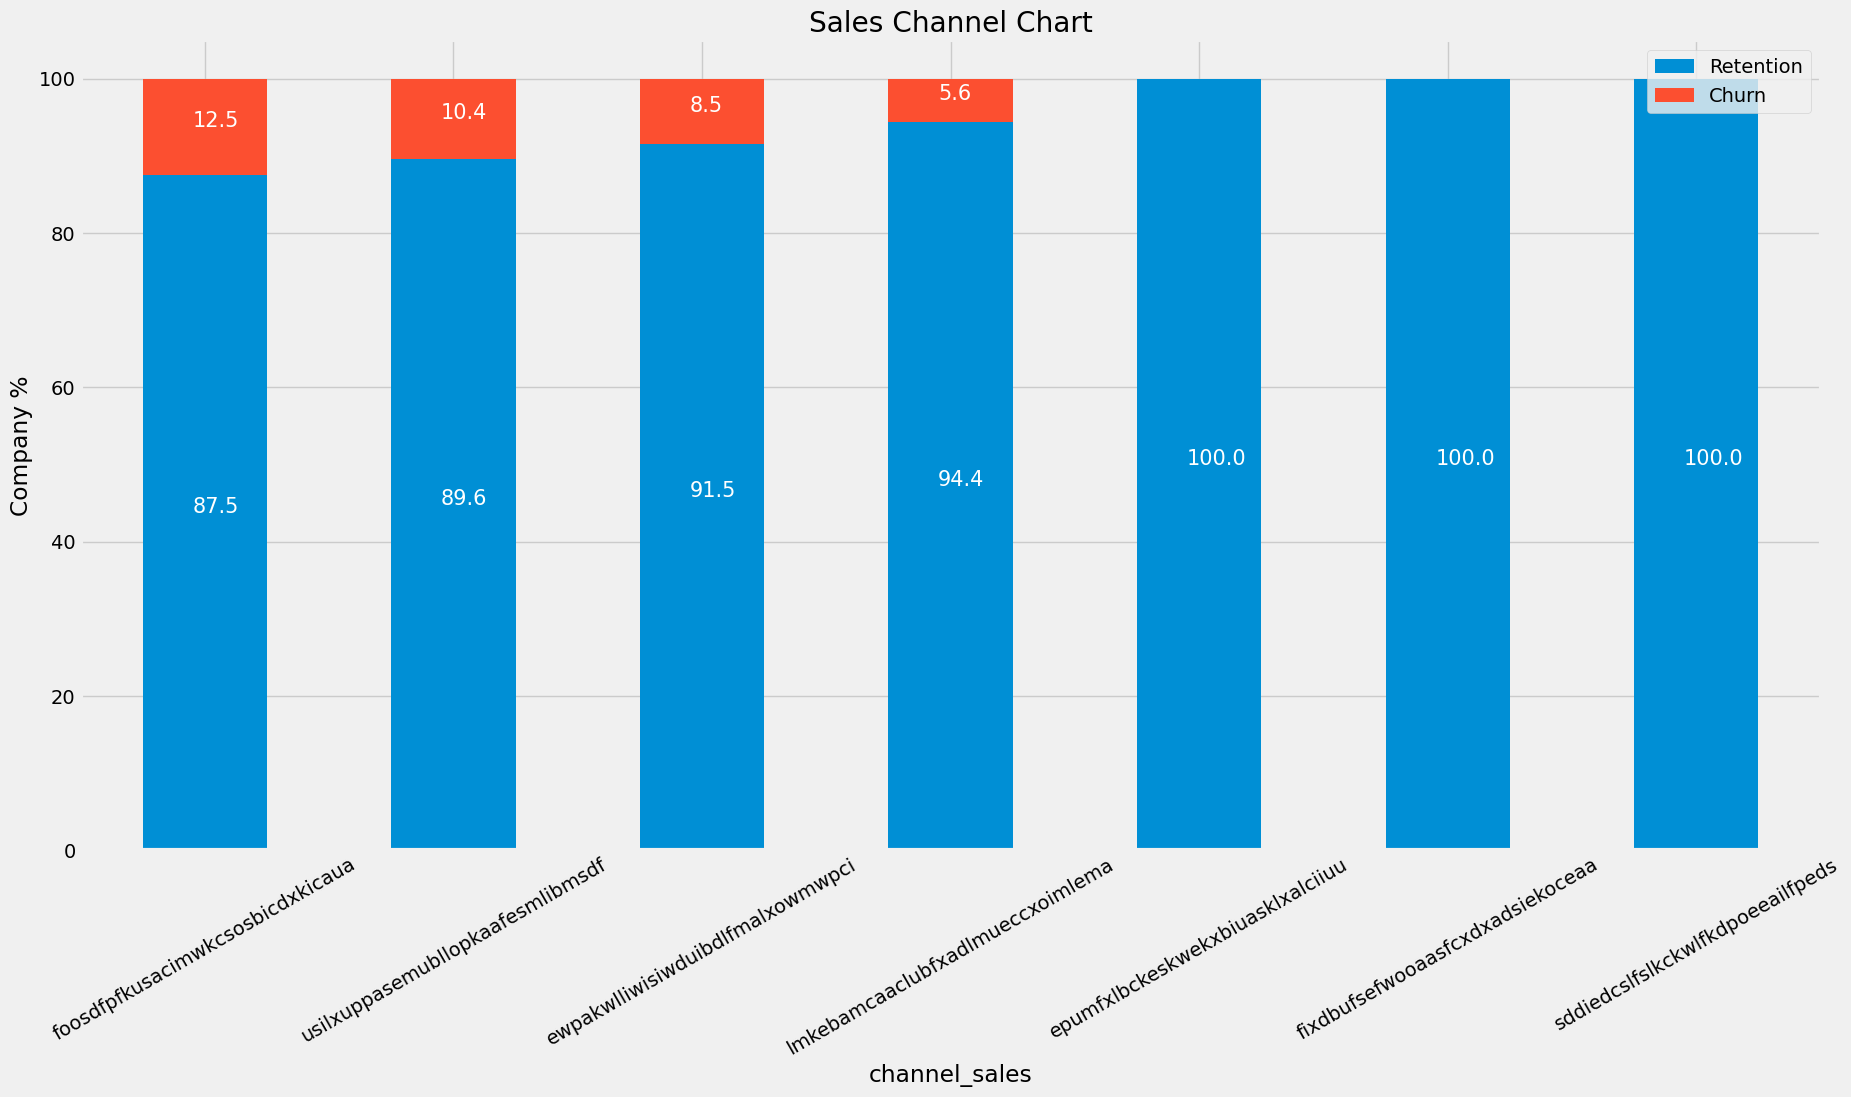

In [29]:
plot_stack_bars(sales_channel_churn, 'Sales Channel Chart', 'Company %', rot_=30)

In [30]:
## Percentage wise

sales_channel_total = sales_channel.fillna(0)[0] + sales_channel.fillna(0)[1]
sales_channel_total_percentage = sales_channel.fillna(0)[1] / (sales_channel_total)*100
pd.DataFrame({'Churn Percenatge': sales_channel_total_percentage, 'Number of Companies':sales_channel_total}).sort_values(by='Churn Percenatge', ascending=False).head(10)

,Churn Percenatge,Number of Companies
channel_sales,,
foosdfpfkusacimwkcsosbicdxkicaua,12.498306,7377.0
usilxuppasemubllopkaafesmlibmsdf,10.387812,1444.0
ewpakwlliwisiwduibdlfmalxowmwpci,8.488613,966.0
lmkebamcaaclubfxadlmueccxoimlema,5.595755,2073.0
epumfxlbckeskwekxbiuasklxalciiuu,0.000000,4.0
fixdbufsefwooaasfcxdxadsiekoceaa,0.000000,2.0
sddiedcslfslkckwlfkdpoeeailfpeds,0.000000,12.0


In [31]:
sales_channel_total

channel_sales
epumfxlbckeskwekxbiuasklxalciiuu       4.0
ewpakwlliwisiwduibdlfmalxowmwpci     966.0
fixdbufsefwooaasfcxdxadsiekoceaa       2.0
foosdfpfkusacimwkcsosbicdxkicaua    7377.0
lmkebamcaaclubfxadlmueccxoimlema    2073.0
sddiedcslfslkckwlfkdpoeeailfpeds      12.0
usilxuppasemubllopkaafesmlibmsdf    1444.0
dtype: float64

## Consumption

In [32]:
cust_churn.columns

Index(['id', 'activity_new', 'campaign_disc_ele', 'channel_sales', 'cons_12m',
       'cons_gas_12m', 'cons_last_month', 'date_activ', 'date_end',
       'date_first_activ', 'date_modif_prod', 'date_renewal',
       'forecast_base_bill_ele', 'forecast_base_bill_year',
       'forecast_bill_12m', 'forecast_cons', 'forecast_cons_12m',
       'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_p1',
       'forecast_price_energy_p2', 'forecast_price_pow_p1', 'has_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'origin_up', 'pow_max', 'churn'],
      dtype='object')

In [33]:
consumption = cust_churn[['id', 'cons_12m', 'cons_gas_12m','cons_last_month','imp_cons', 'has_gas', 'churn']]

In [34]:
## Function to plot Histograms

def plot_histogram(df, col, ax):
    
    data_hist = pd.DataFrame({'Retention':df[df['churn']==0][col], 'Churn' : df[df['churn']==1][col]})
    data_hist[['Retention', 'Churn']].plot(kind='hist', bins=50, ax=ax, stacked=True)
    ax.set_xlabel(col)

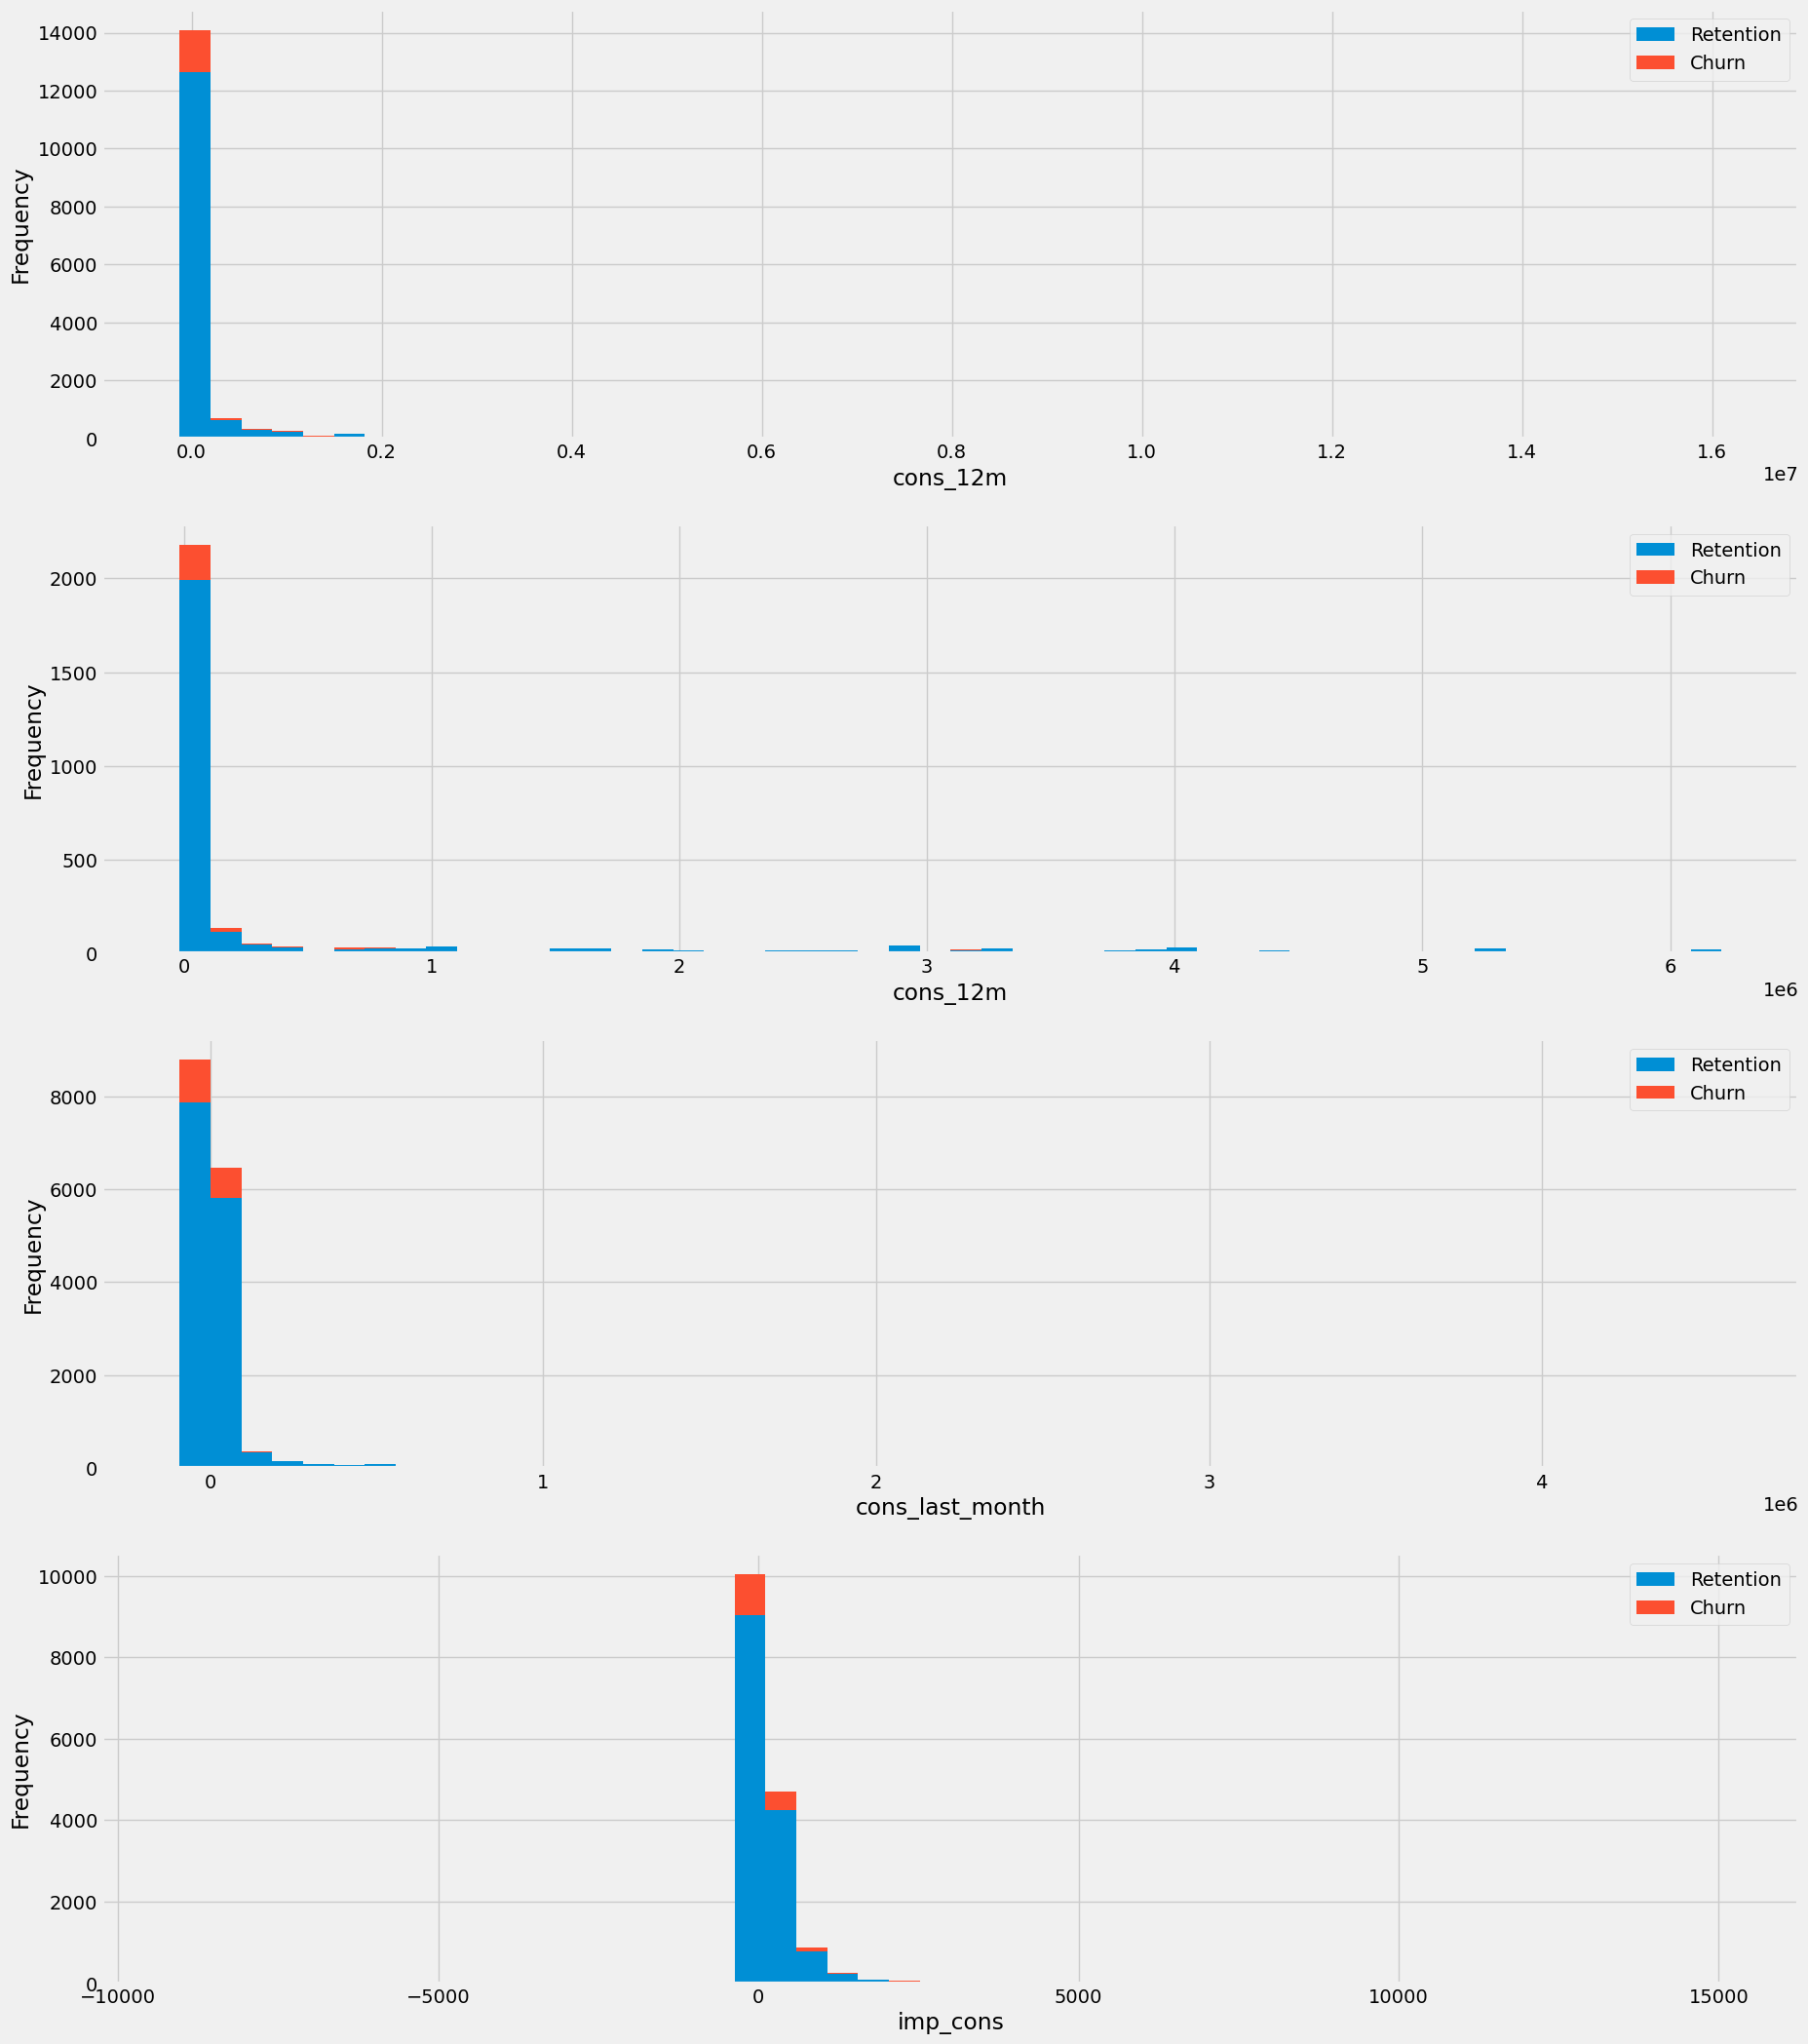

In [35]:
fig, axs = plt.subplots(nrows=4, figsize=(20,25))

plot_histogram(consumption, 'cons_12m', axs[0])
plot_histogram(consumption[consumption['has_gas'] == 't'],'cons_12m', axs[1])
plot_histogram(consumption, 'cons_last_month', axs[2])
plot_histogram(consumption, 'imp_cons', axs[3])

<b>Consumption</b> data is highly skewed to the right, presenting a very long right-tail towards higher values of distribution

The values on the higher end and lower ends of the distribution are likely to be outliers. We can use a standard plot to visualise the outliers in moredetail. A boxplot is a standardized way of displaying the distribution of data based on a five number summary (“minimum”, first quartile (Q1), median,third quartile (Q3), and “maximum”). It can tell us about our outliers and what their values are. It can also tell us if our data is symmetrical, how tightlyour data is grouped, and if and how our data is skewed.

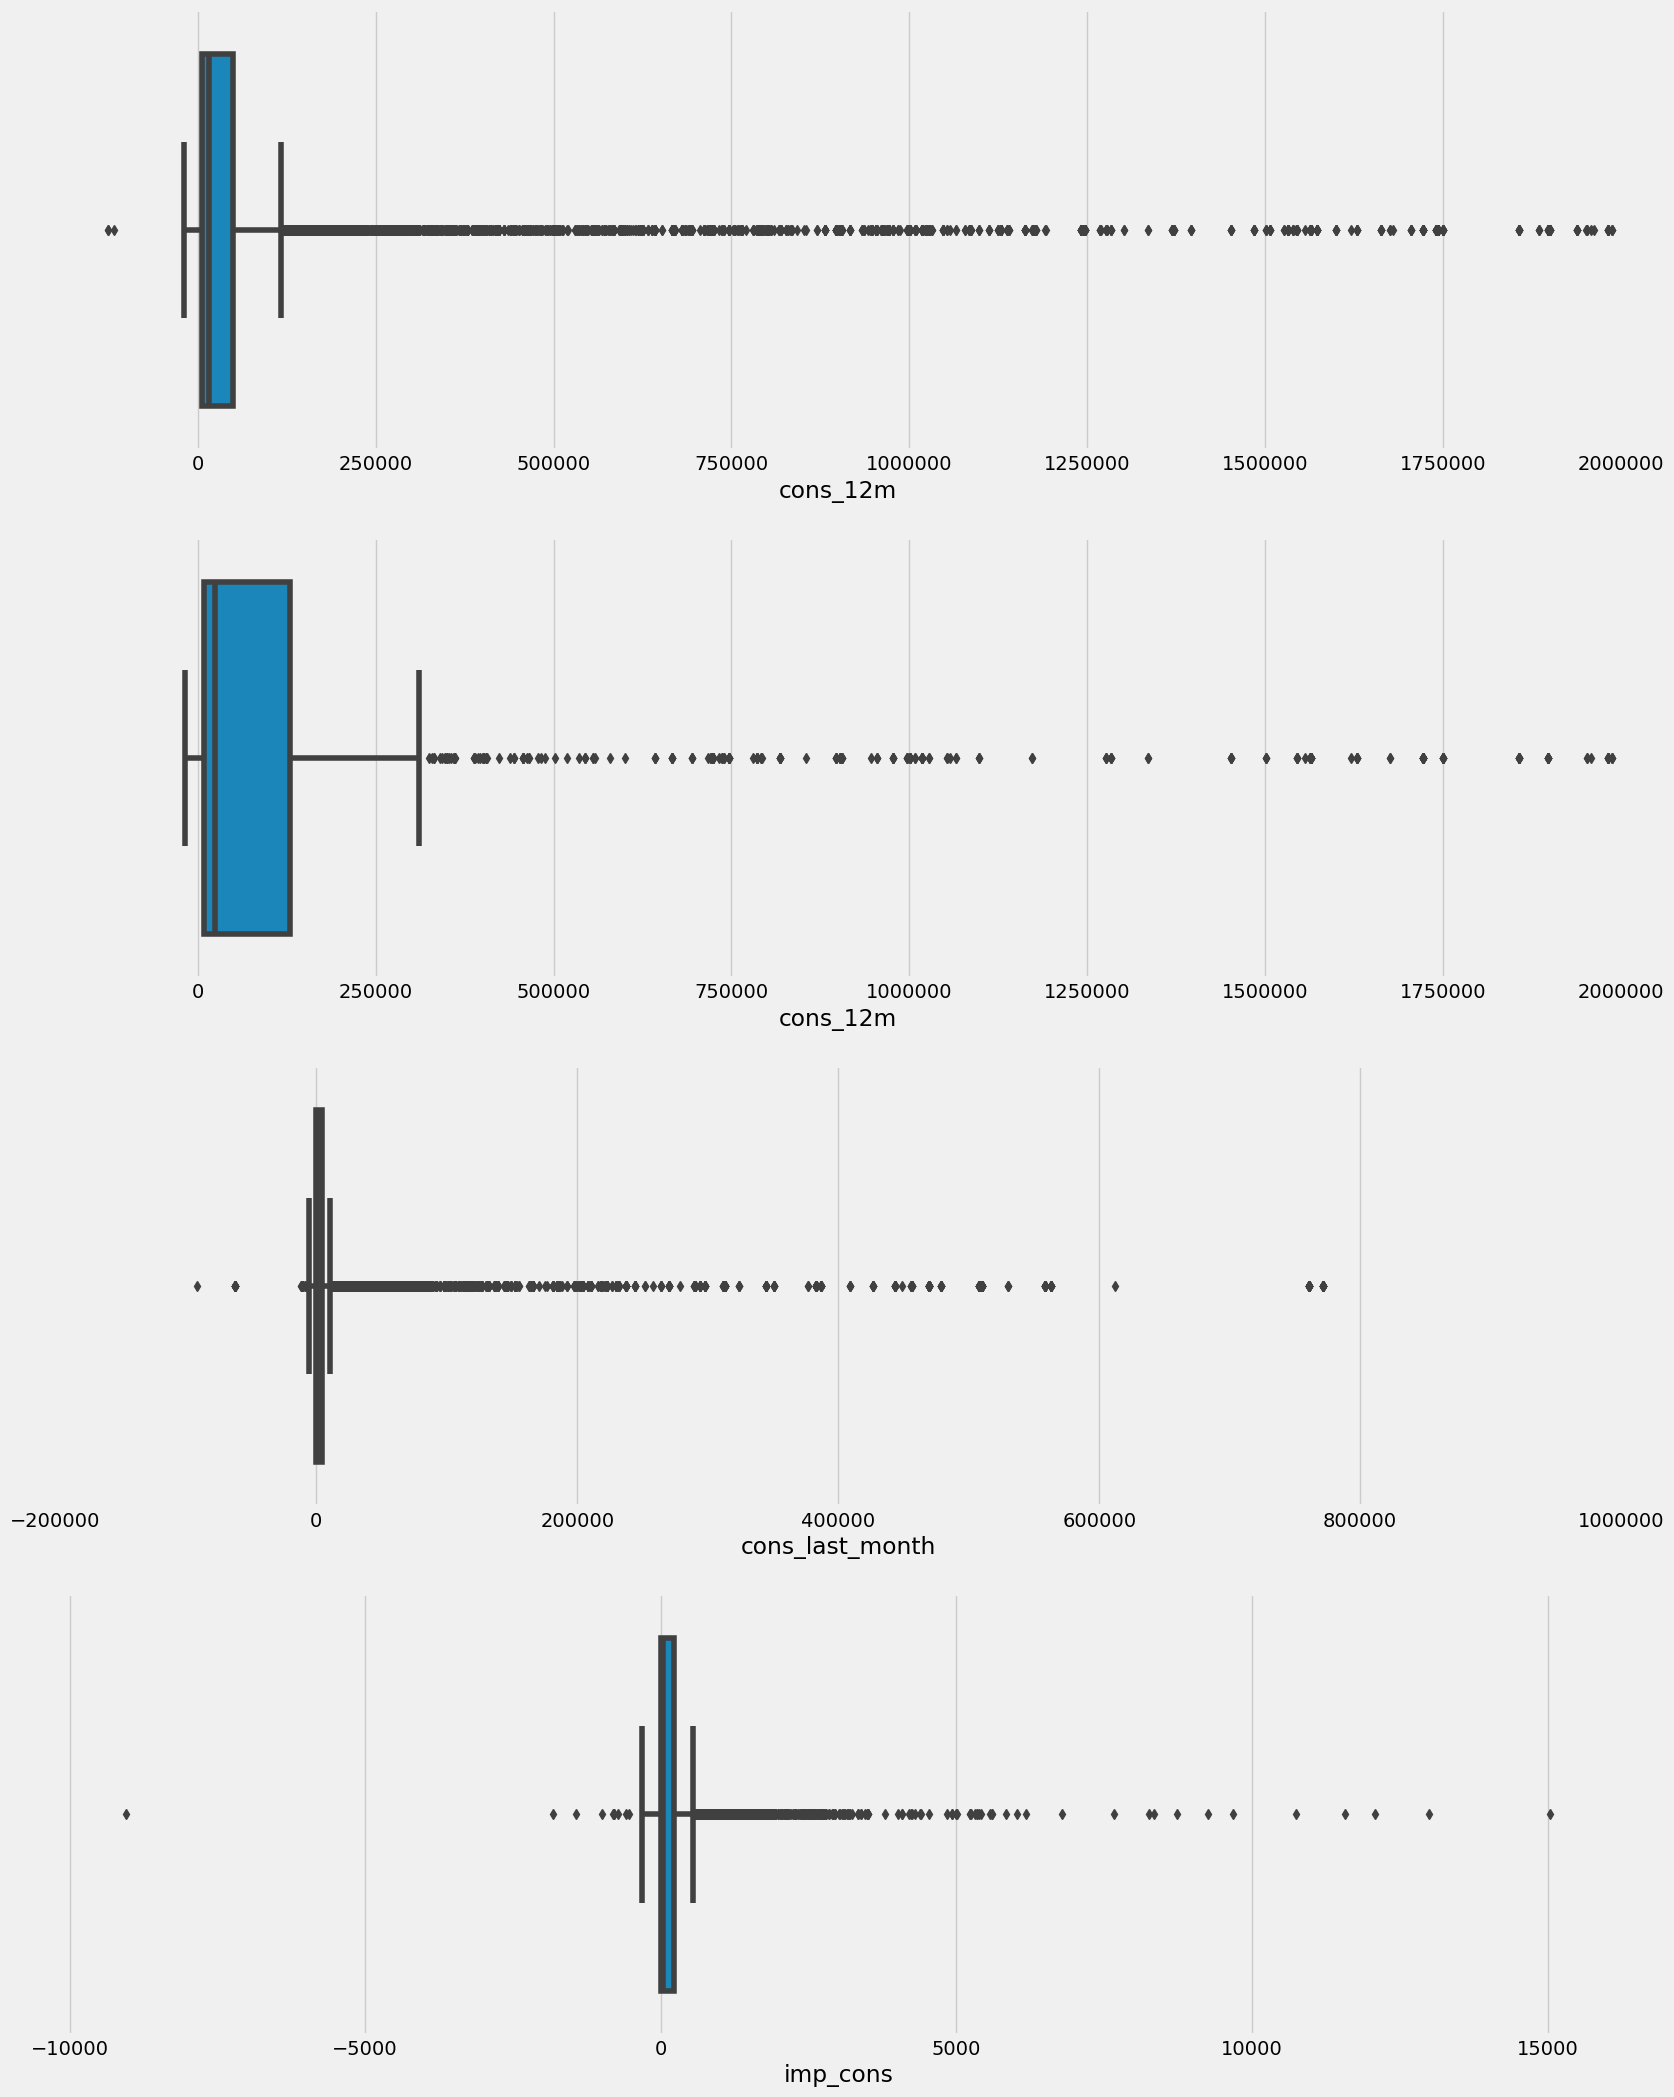

In [36]:
fig, axs = plt.subplots(nrows=4, figsize=(18,25))

## add x= to tell seaborn what x axis is about
sns.boxplot(x=consumption['cons_12m'], ax=axs[0]) 
sns.boxplot(x=consumption[consumption['has_gas']=='t']['cons_12m'], ax=axs[1])
sns.boxplot(x=consumption['cons_last_month'], ax=axs[2])
sns.boxplot(x=consumption['imp_cons'], ax=axs[3])

for ax in axs :
    ax.ticklabel_format(style='plain', axis='x')

axs[0].set_xlim(-200000,2000000)
axs[1].set_xlim(-200000,2000000)
axs[2].set_xlim(-200000,1000000)
plt.show()

We have a highly skewed distribution, and several outliers.

## Dates

In [37]:
dates = cust_churn[['id', 'date_activ', 'date_end', 'date_modif_prod', 'date_renewal', 'churn']].copy()

In [38]:
dates['date_activ'] = pd.to_datetime(dates['date_activ'], format='%Y-%m-%d')
dates['date_end'] = pd.to_datetime(dates['date_end'] ,  format='%Y-%m-%d')
dates['date_modif_prod'] = pd.to_datetime(dates['date_modif_prod'] ,  format='%Y-%m-%d')
dates['date_renewal'] = pd.to_datetime(dates['date_renewal'] ,  format='%Y-%m-%d')

In [39]:
# Function to plot monthly churn and retention distribution

def plot_dates(df, col , fontsize_=12) :
    
    date_df = df[[col, 'churn', 'id']].set_index(col).groupby([pd.Grouper(freq='M'), 'churn']).count().unstack(level=1)
    
    ax = date_df.plot(kind='bar', stacked=True, figsize=(18,10), rot=0)
    ax.set_xticklabels(map(lambda x: line_format(x), date_df.index))
    plt.xticks(fontsize = fontsize_)
    plt.ylabel('Num of Companies')
    plt.legend(['Retention', 'Churn'], loc='upper right') # upper_right is remove and changed to upper right
    plt.show()

In [40]:
# Function to convert time label to the format of pandas line plot

def line_format(label):
    
    month = label.month_name()[:1]
    if label.month_name()=='January':
        month+=f'\n{label.year}'
    return month

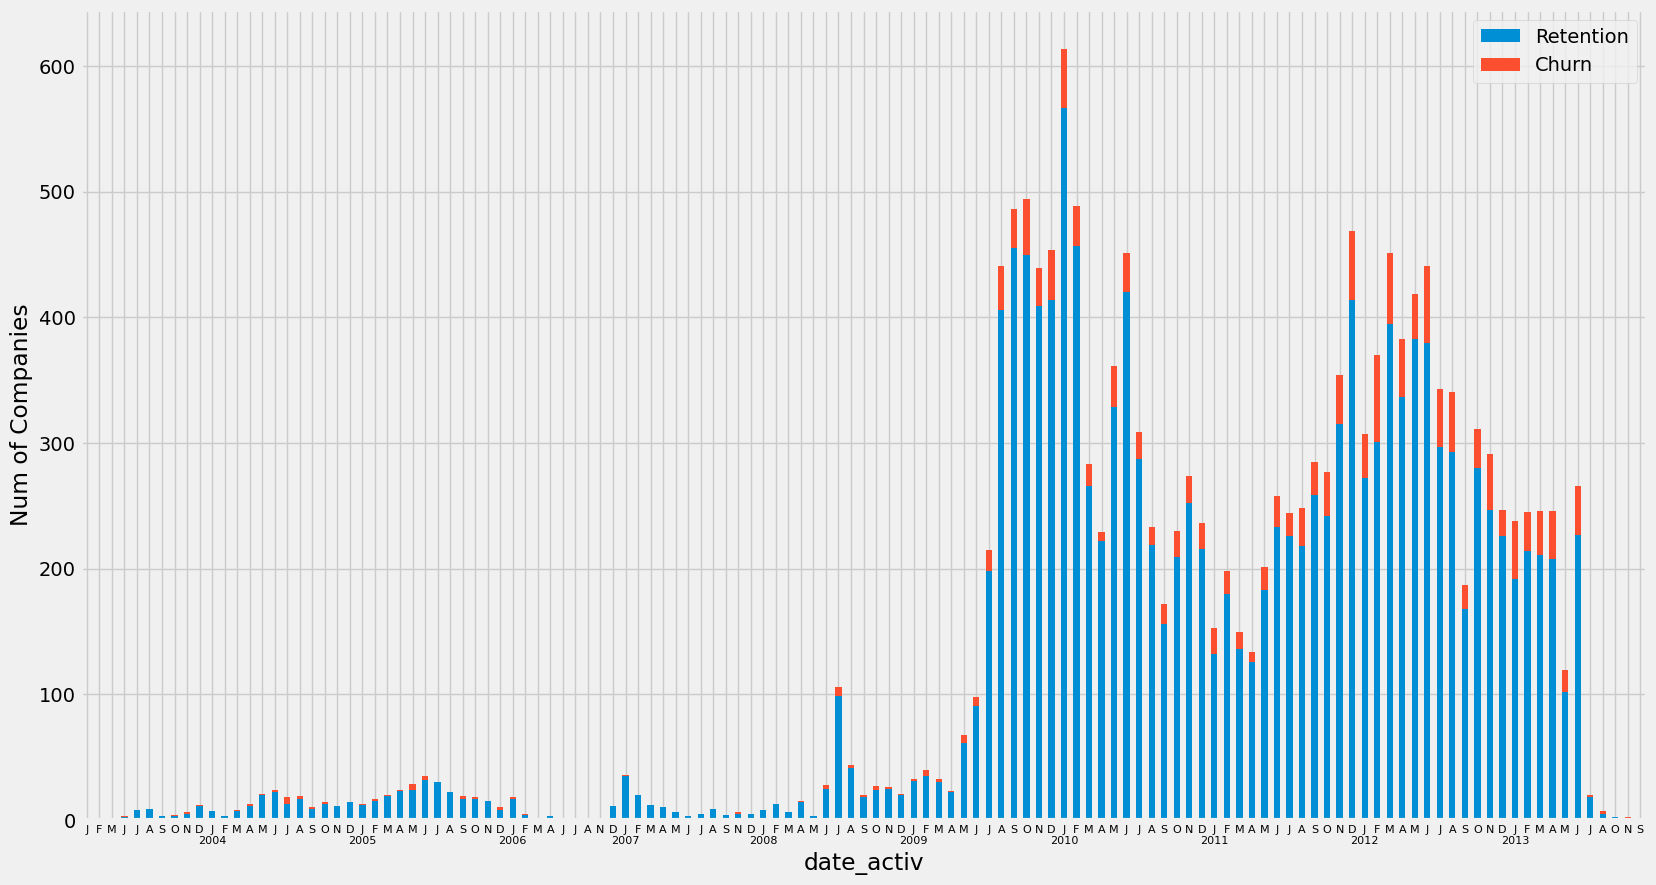

In [41]:
plot_dates(dates, 'date_activ', fontsize_=8)

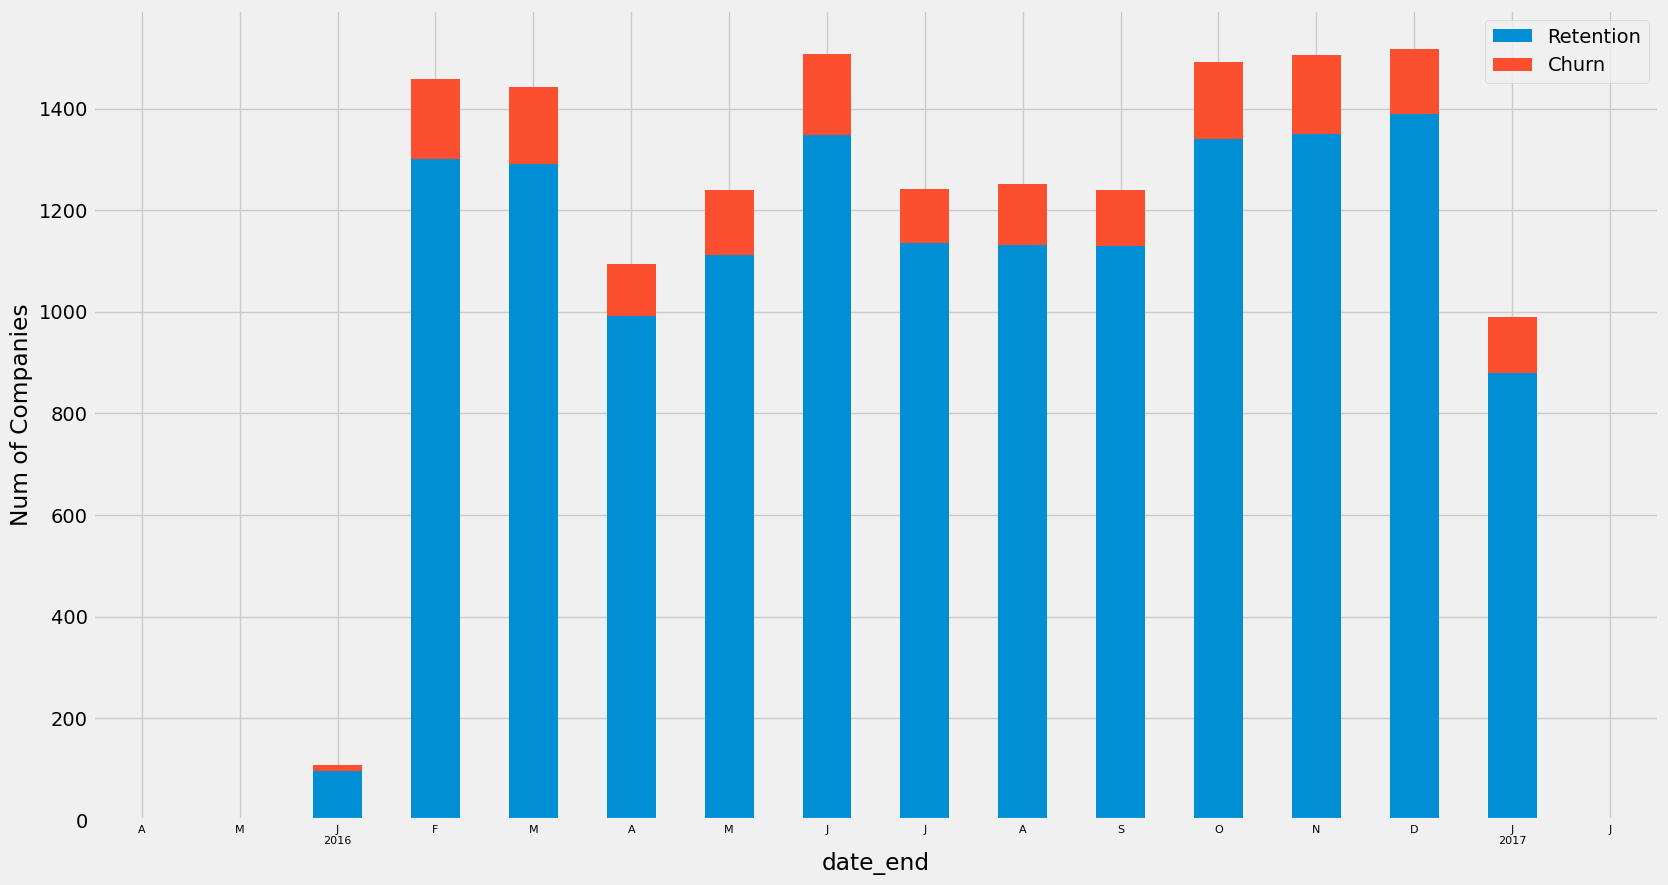

In [42]:
plot_dates(dates, 'date_end', fontsize_=8)

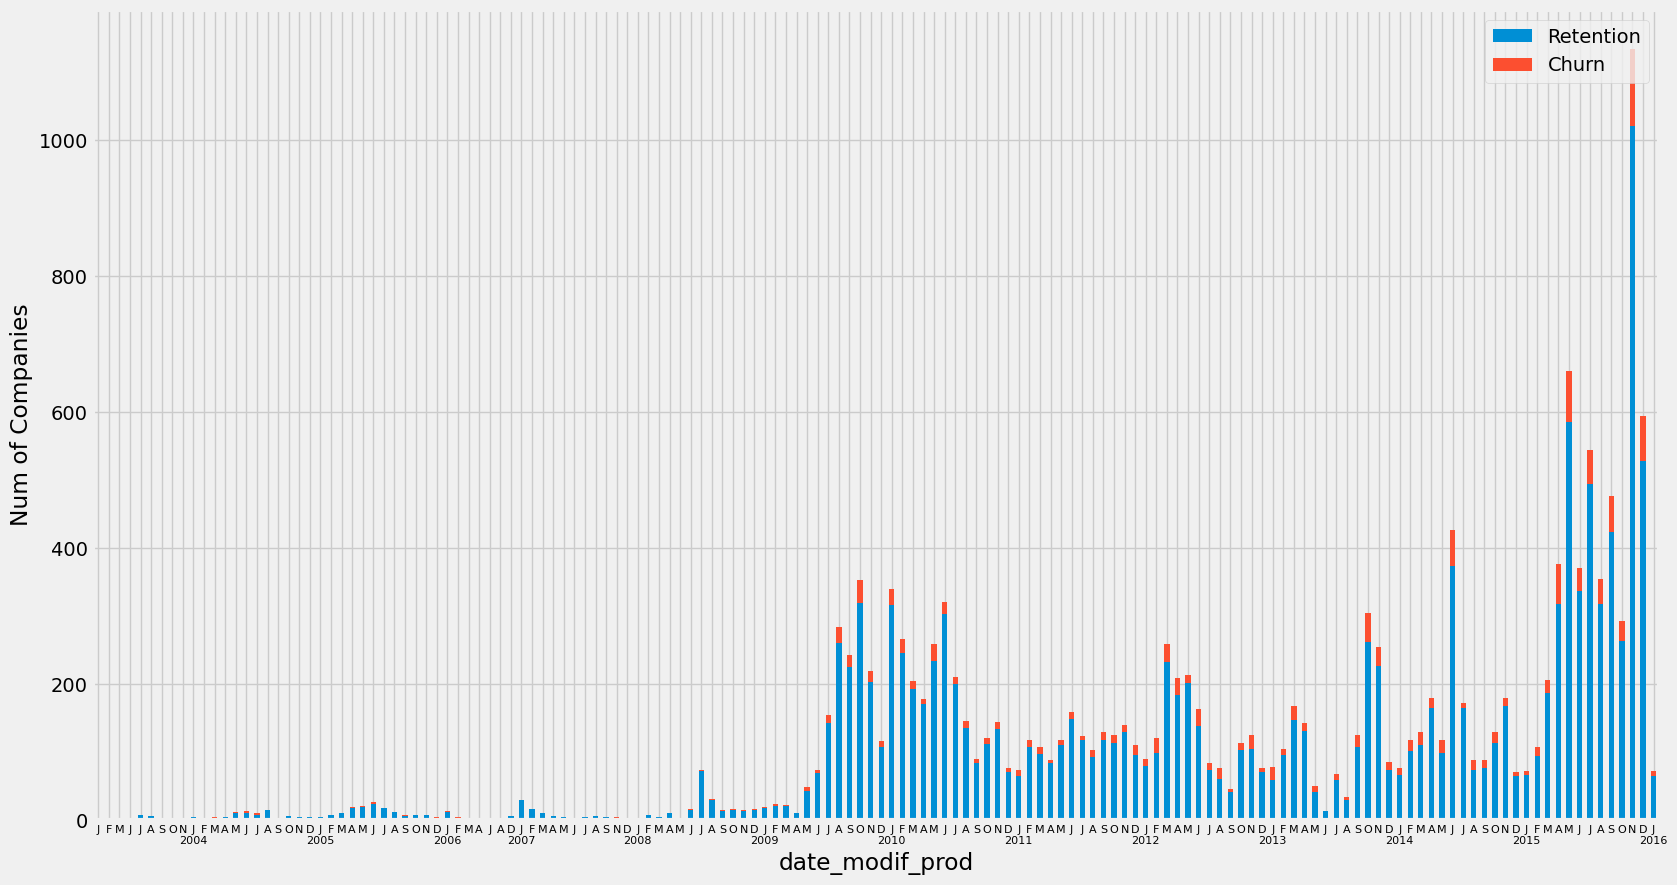

In [43]:
plot_dates(dates, 'date_modif_prod', fontsize_=8)

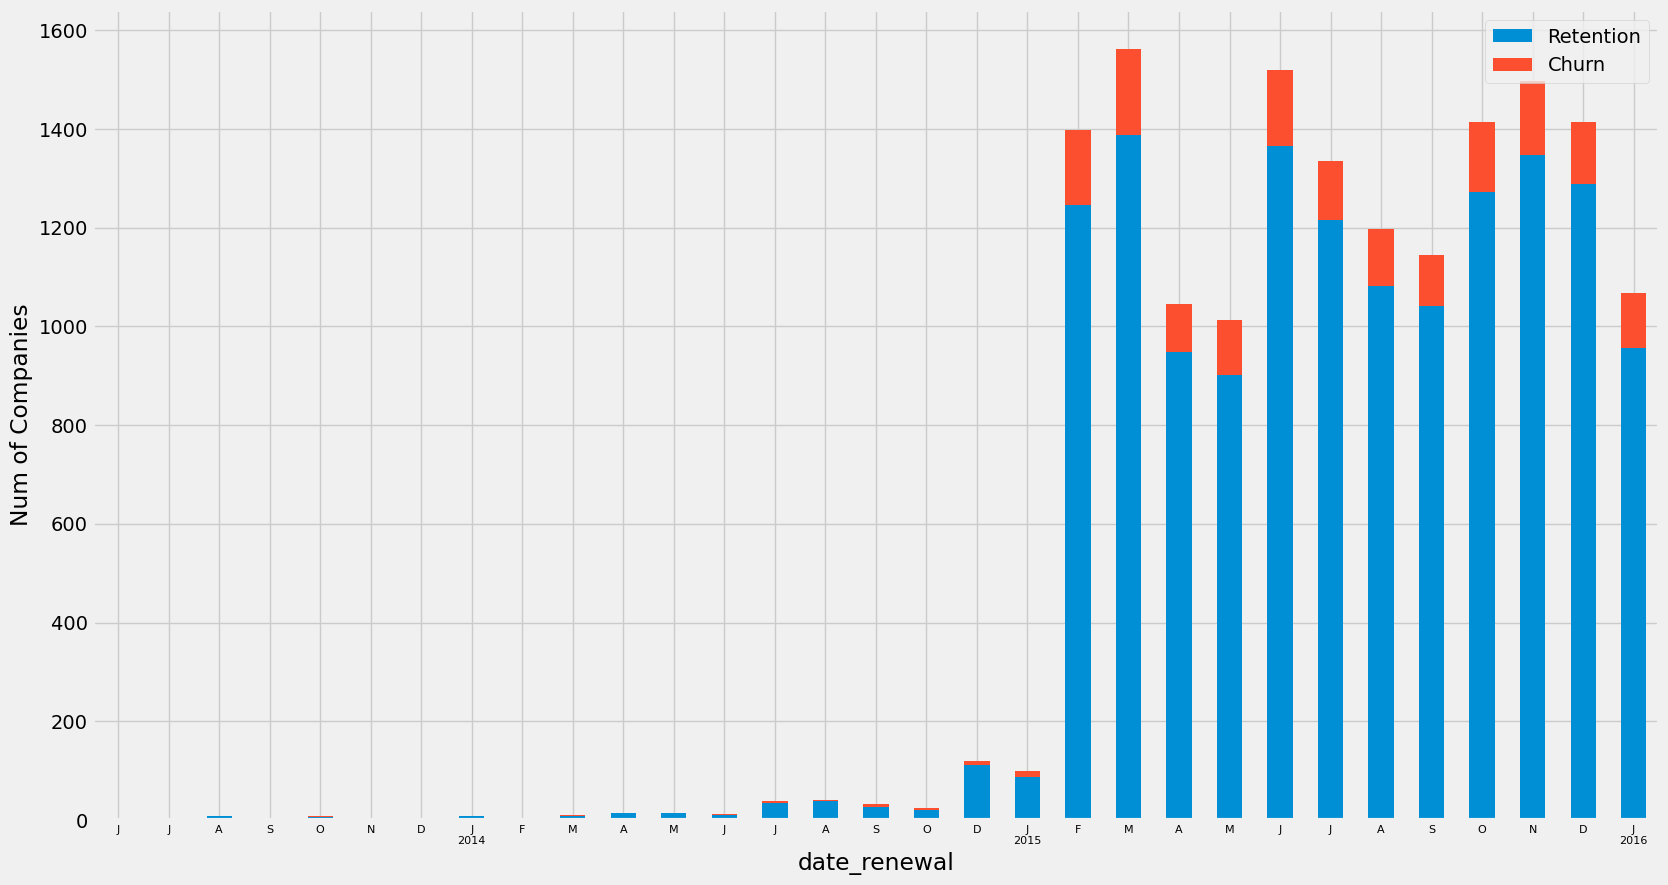

In [44]:
plot_dates(dates, 'date_renewal', fontsize_=8)

We can visualize the distribution of churned companies according to the date. However, this does not provide us with any usefulinsight. We will create a new feature using the raw dates provided in the upcoming analysis.

## Forecast

In [45]:
forecast_churn = cust_churn[['id' , 'forecast_base_bill_ele', 'forecast_base_bill_year',
       'forecast_bill_12m', 'forecast_cons', 'forecast_cons_12m',
       'forecast_cons_year', 'forecast_discount_energy','forecast_meter_rent_12m', 'forecast_price_energy_p1',
       'forecast_price_energy_p2', 'forecast_price_pow_p1', 'churn']]

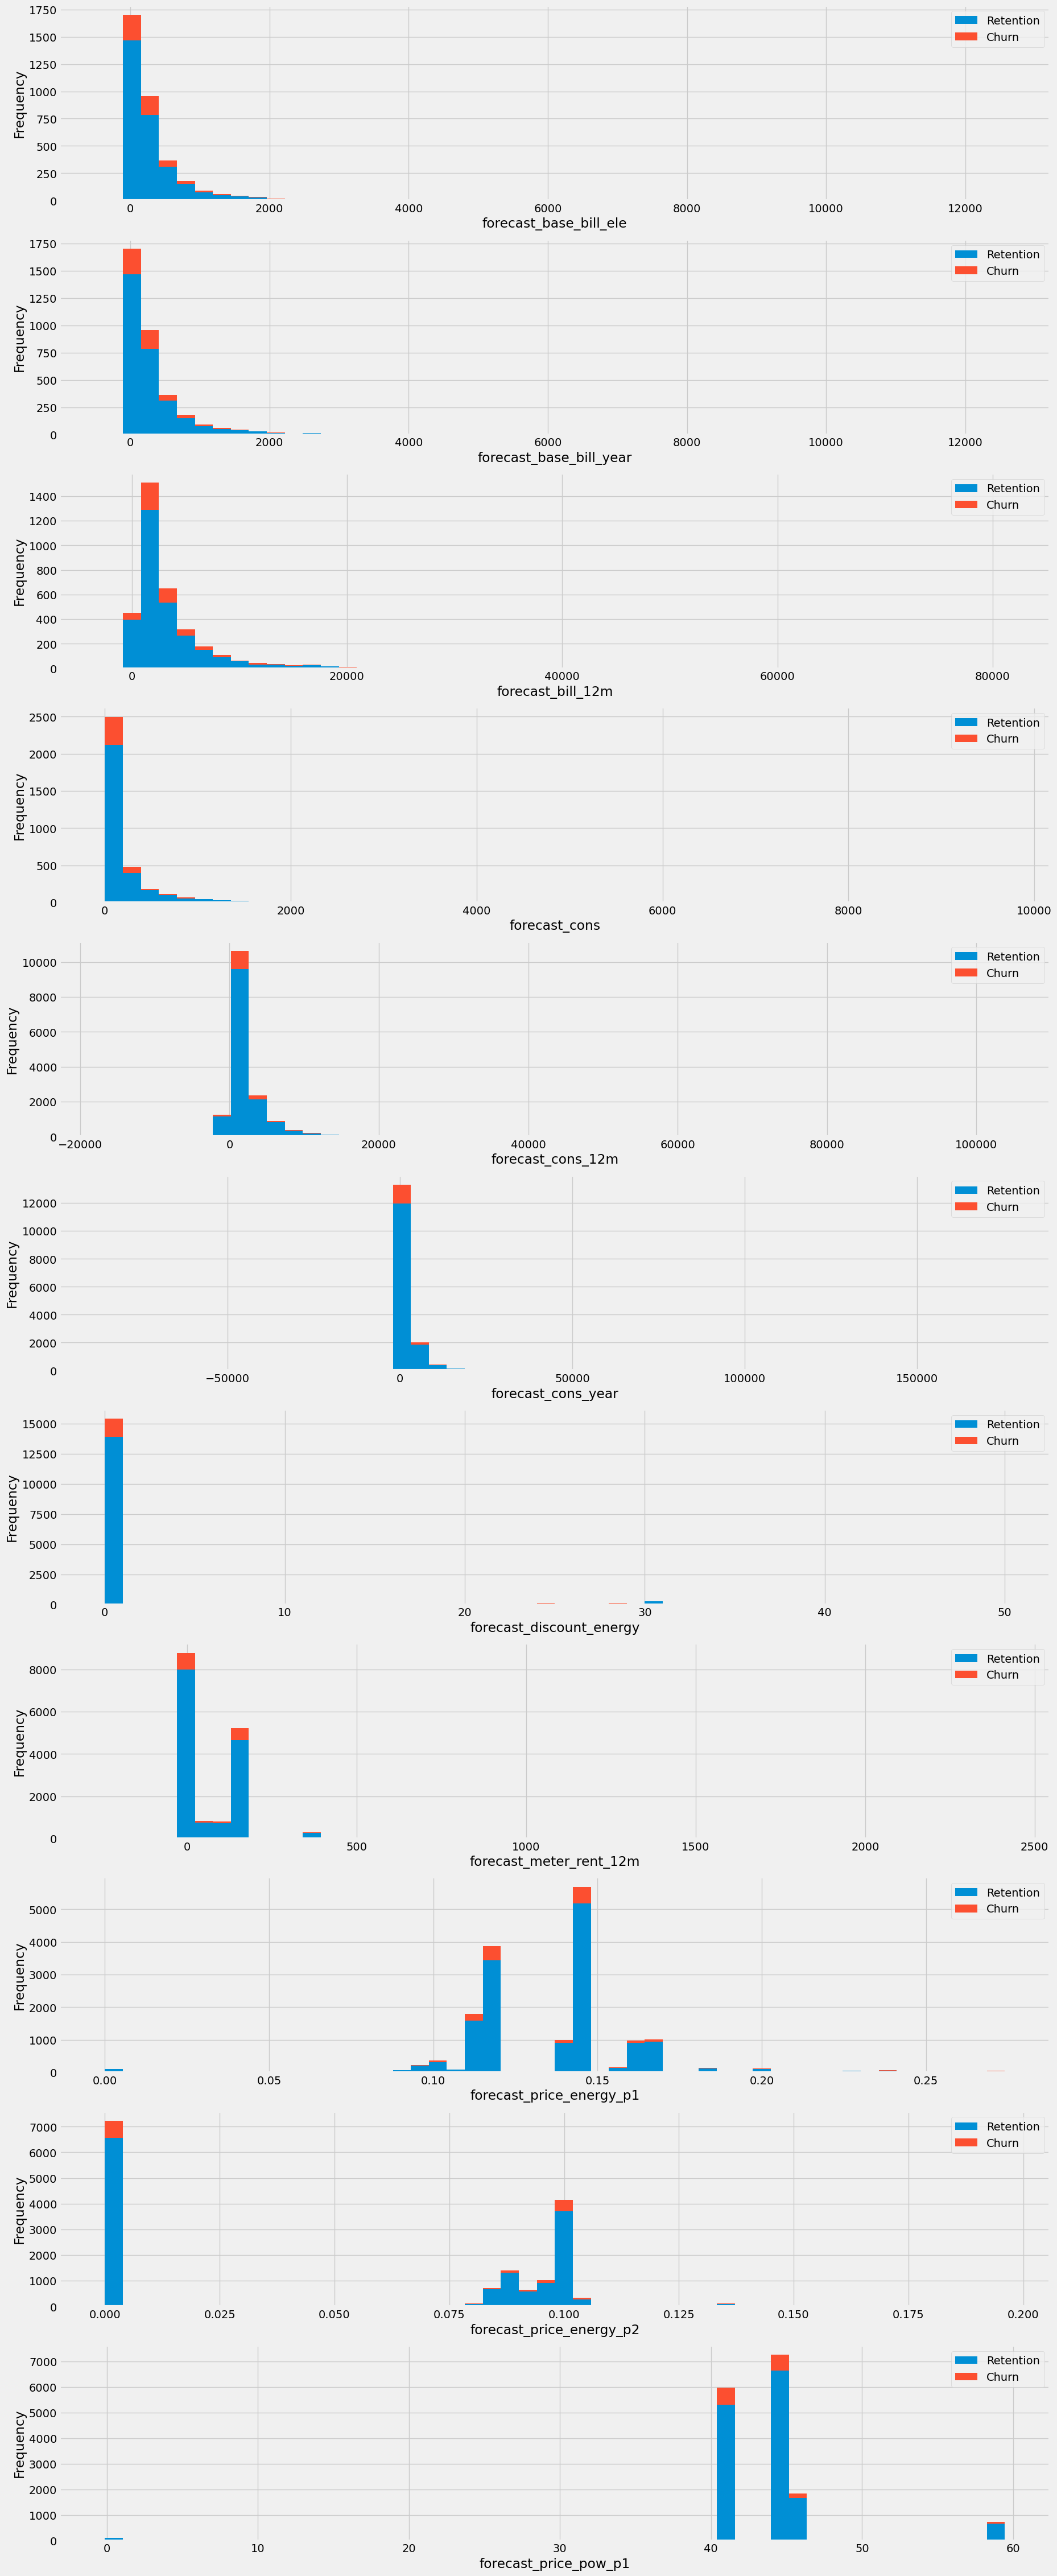

In [46]:
fig , axs = plt.subplots(nrows=11, figsize=(20,55))
plot_histogram(forecast_churn, 'forecast_base_bill_ele', axs[0])
plot_histogram(forecast_churn, 'forecast_base_bill_year', axs[1])
plot_histogram(forecast_churn, 'forecast_bill_12m', axs[2])
plot_histogram(forecast_churn, 'forecast_cons', axs[3])
plot_histogram(forecast_churn, 'forecast_cons_12m', axs[4])
plot_histogram(forecast_churn, 'forecast_cons_year', axs[5])
plot_histogram(forecast_churn, 'forecast_discount_energy', axs[6])
plot_histogram(forecast_churn, 'forecast_meter_rent_12m', axs[7])
plot_histogram(forecast_churn, 'forecast_price_energy_p1', axs[8])
plot_histogram(forecast_churn, 'forecast_price_energy_p2', axs[9])
plot_histogram(forecast_churn, 'forecast_price_pow_p1', axs[10])

Similarly to the consumption plots, we can observe that a lot of the variables are highly skewed to the right, creating a very long tail on the highervalues.
We will make some transformations to correct for this skewness

## Contract type (electricity, gas)

In [47]:
contract_type = cust_churn[['id', 'has_gas', 'churn']]

In [48]:
contract_type_count = contract_type.groupby(['has_gas','churn'])['id'].count().unstack(level=1)
contract_type_count

churn,0,1
has_gas,,
f,11771,1361
t,2730,234


In [49]:
contract_type_percent = (contract_type_count.div(contract_type_count.sum(axis=1), axis=0)*100).sort_values(by=[1], ascending=False)
contract_type_percent

churn,0,1
has_gas,,
f,89.636004,10.363996
t,92.105263,7.894737


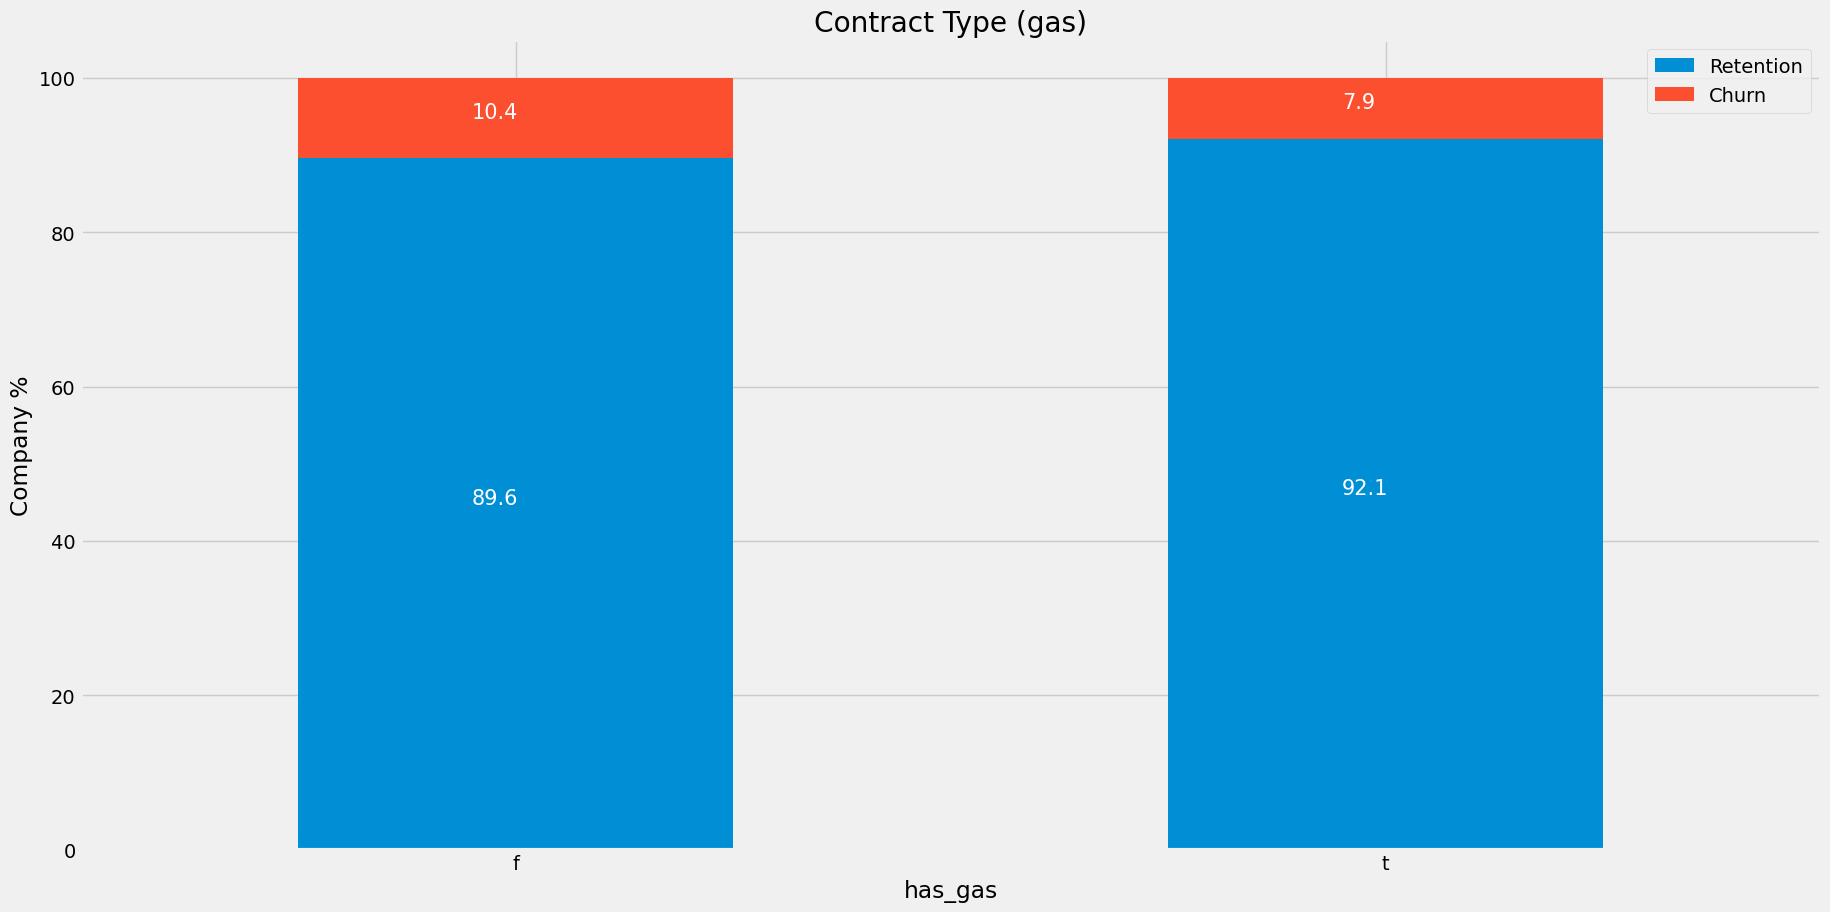

In [50]:
plot_stack_bars(contract_type_percent, 'Contract Type (gas)', 'Company %')

## Margin

In [51]:
margin_churn = cust_churn[['id', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'net_margin']]

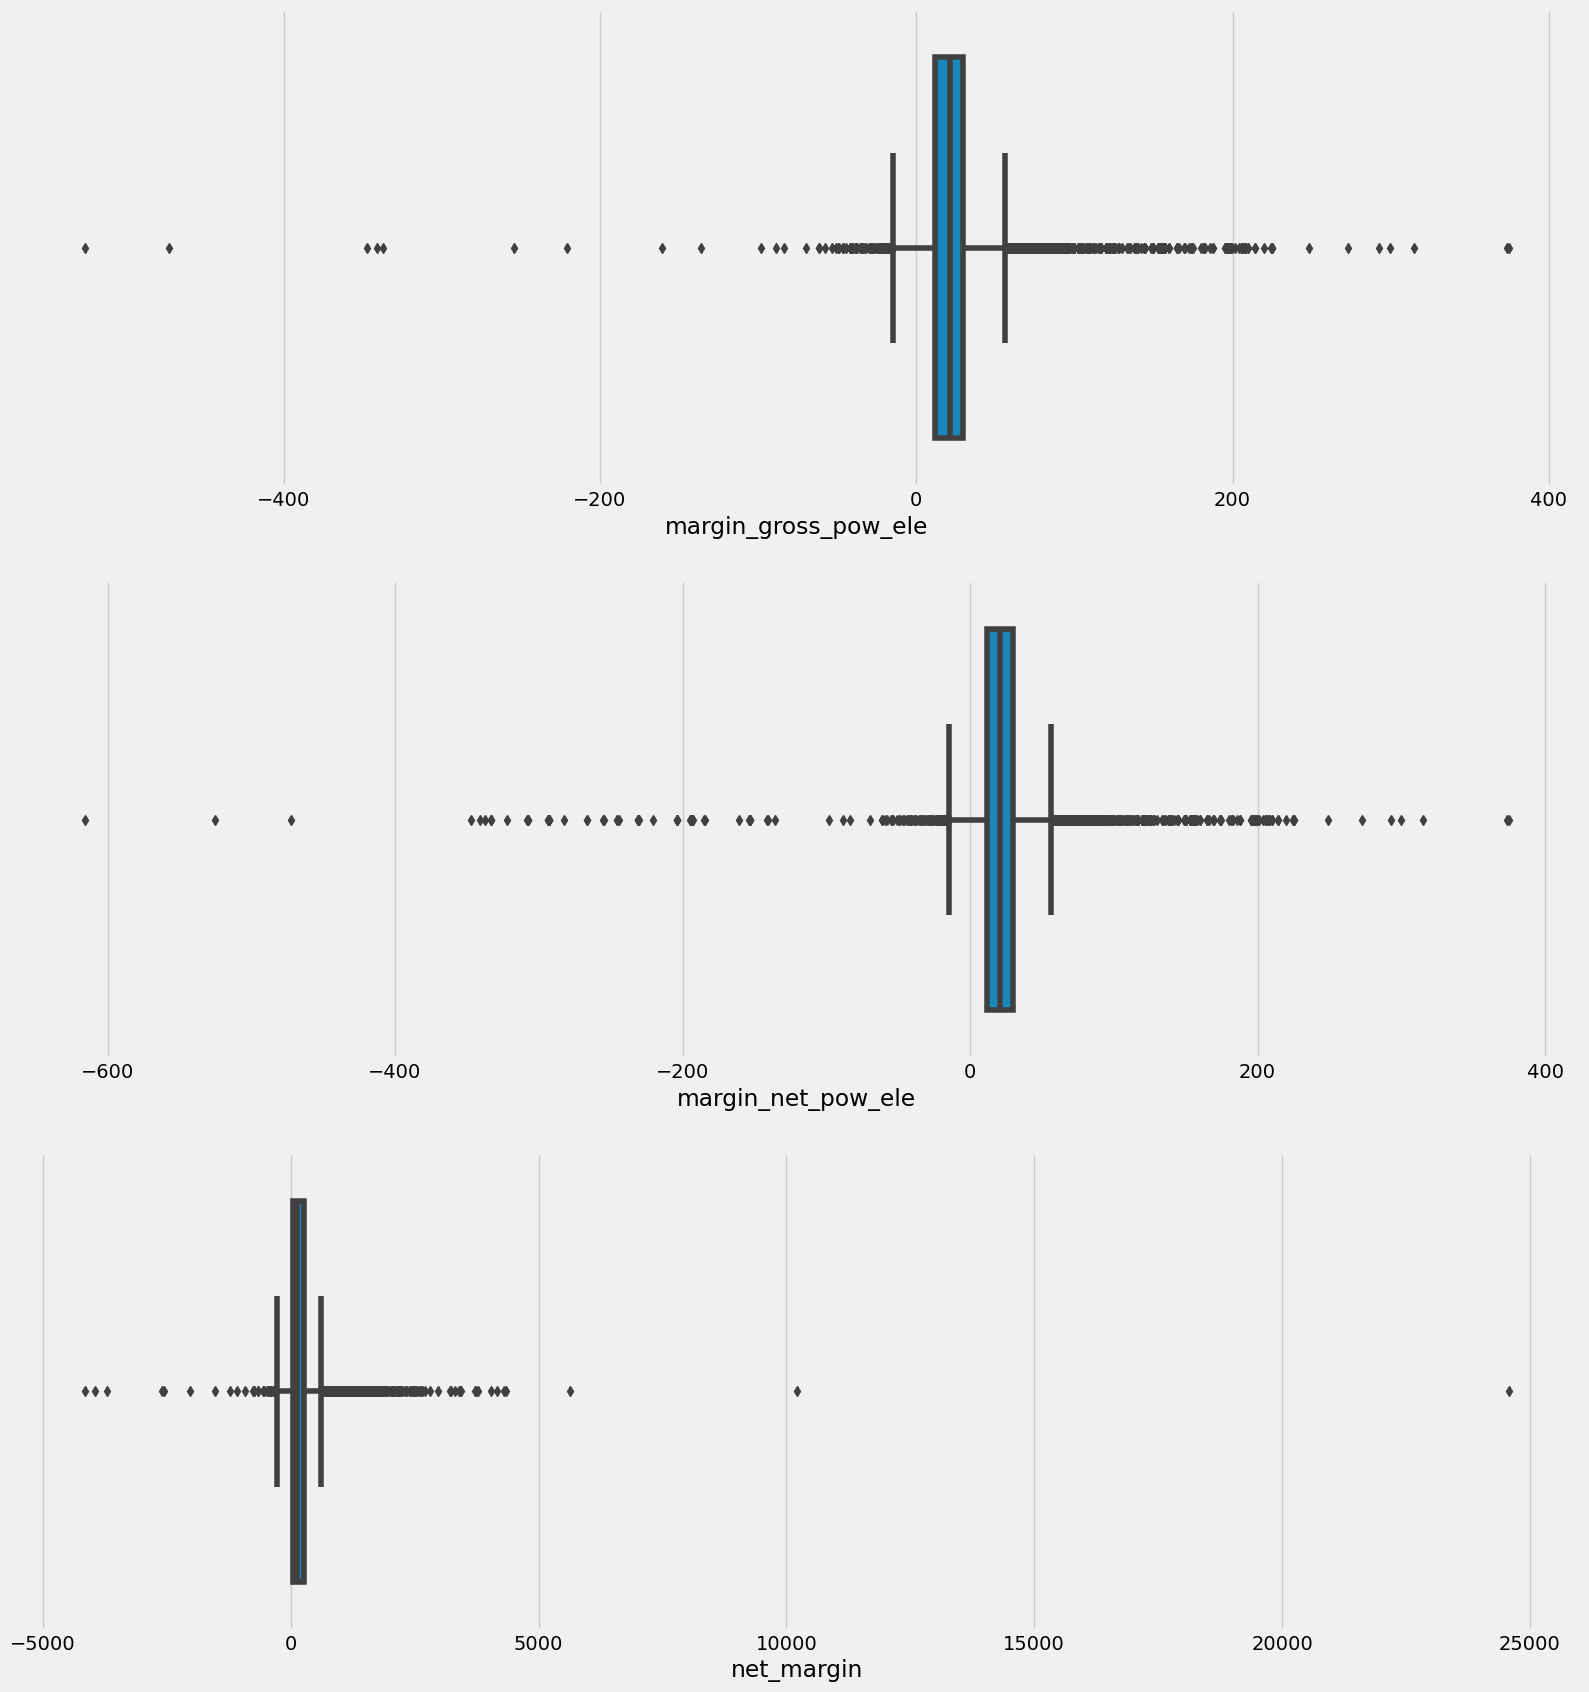

In [52]:
fig, axs = plt.subplots(nrows=3, figsize=(18,20))
sns.boxplot(x=margin_churn['margin_gross_pow_ele'] , ax=axs[0])  ## mention x axis else will plot for default y axix (vertical)
sns.boxplot(x=margin_churn['margin_net_pow_ele'] , ax=axs[1])
sns.boxplot(x=margin_churn['net_margin'] , ax=axs[2])

plt.show()

We can see outliers in the Margin case as well

## Subscribed Power

In [53]:
subs_power_churn = cust_churn[['id', 'pow_max' , 'churn']].fillna(0)
subs_power_churn


,id,pow_max,churn
0,48ada52261e7cf58715202705a0451c9,180.000,0
1,24011ae4ebbe3035111d65fa7c15bc57,43.648,1
2,d29c2c54acc38ff3c0614d0a653813dd,13.800,0
3,764c75f661154dac3a6c254cd082ea7d,13.856,0
4,bba03439a292a1e166f80264c16191cb,13.200,0
...,...,...,...
16091,18463073fb097fc0ac5d3e040f356987,15.000,0
16092,d0a6f71671571ed83b2645d23af6de00,6.000,1
16093,10e6828ddd62cbcf687cb74928c4c2d2,15.935,1
16094,1cf20fd6206d7678d5bcafd28c53b4db,11.000,0


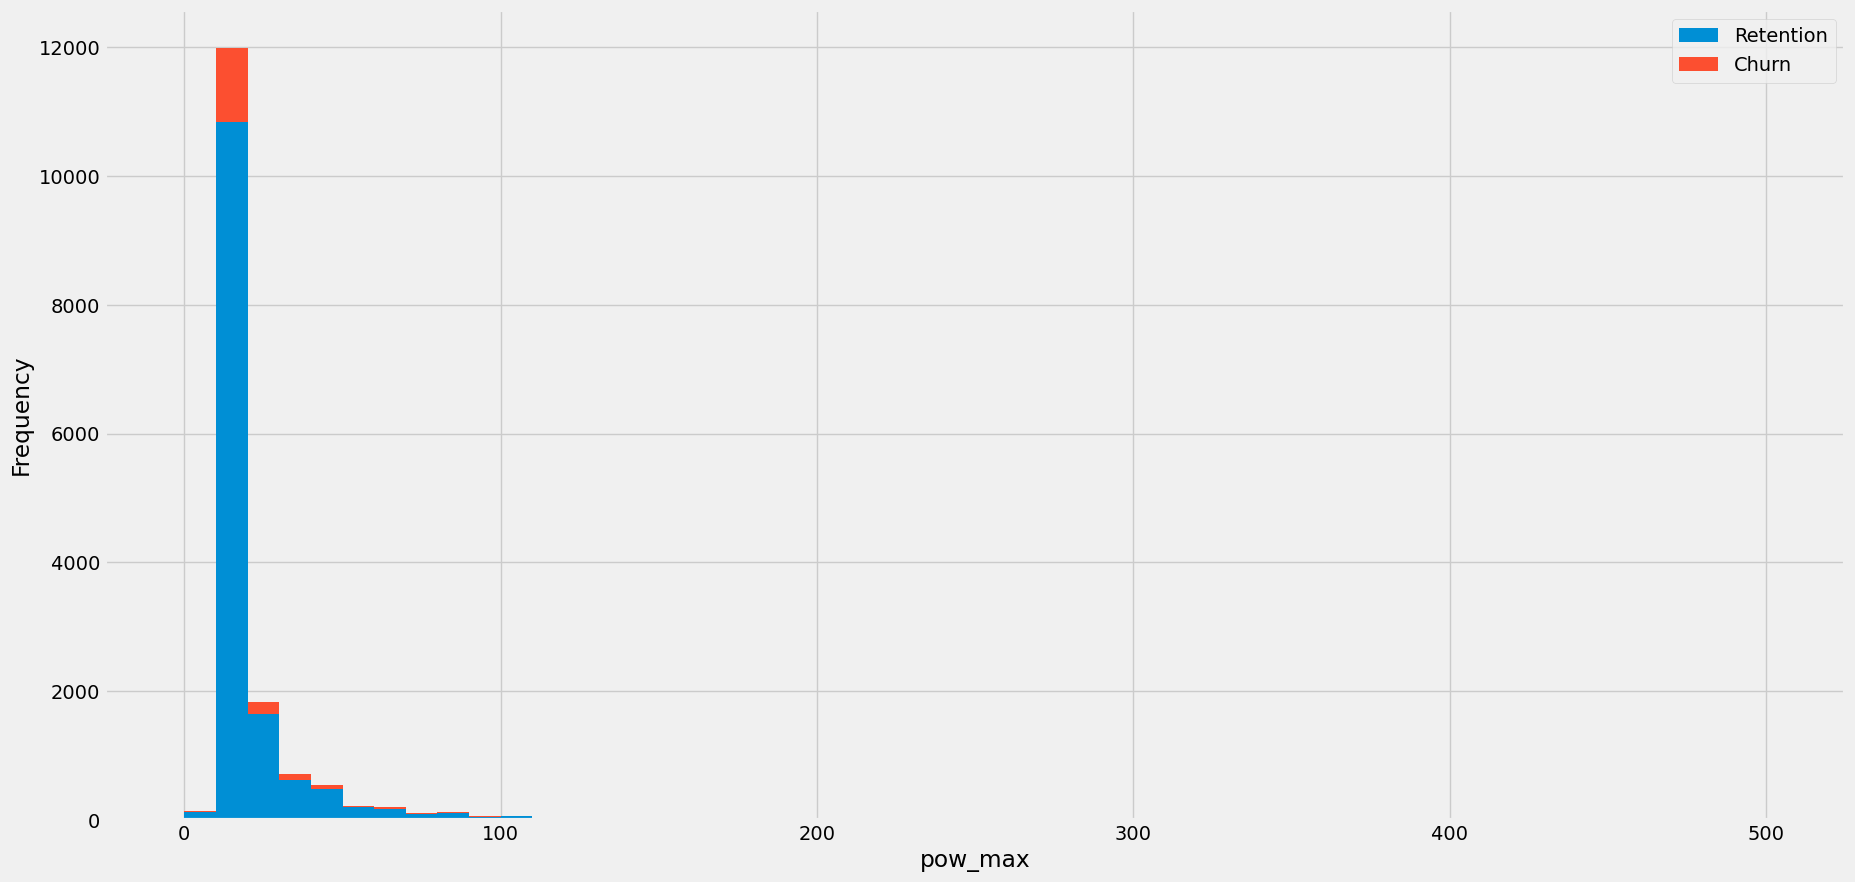

In [54]:
fig, axs = plt.subplots(nrows=1, figsize=(20,10))
plot_histogram(subs_power_churn, 'pow_max' , axs)

## Other features

In [55]:
other_feat = cust_churn[['id', 'nb_prod_act', 'num_years_antig', 'origin_up', 'churn']]

In [56]:
num_products = other_feat.groupby(['nb_prod_act' , 'churn'])['id'].count().unstack(level=1)

In [57]:
num_products_percent = (num_products.div(num_products.sum(axis=1) , axis=0)*100).sort_values(by=[1] , ascending=False)
num_products_percent

churn,0,1
nb_prod_act,,
1,89.697452,10.302548
3,90.017825,9.982175
4,91.176471,8.823529
2,91.617430,8.382570
5,91.891892,8.108108
6,100.000000,NaN
8,100.000000,NaN
9,100.000000,NaN
10,100.000000,NaN


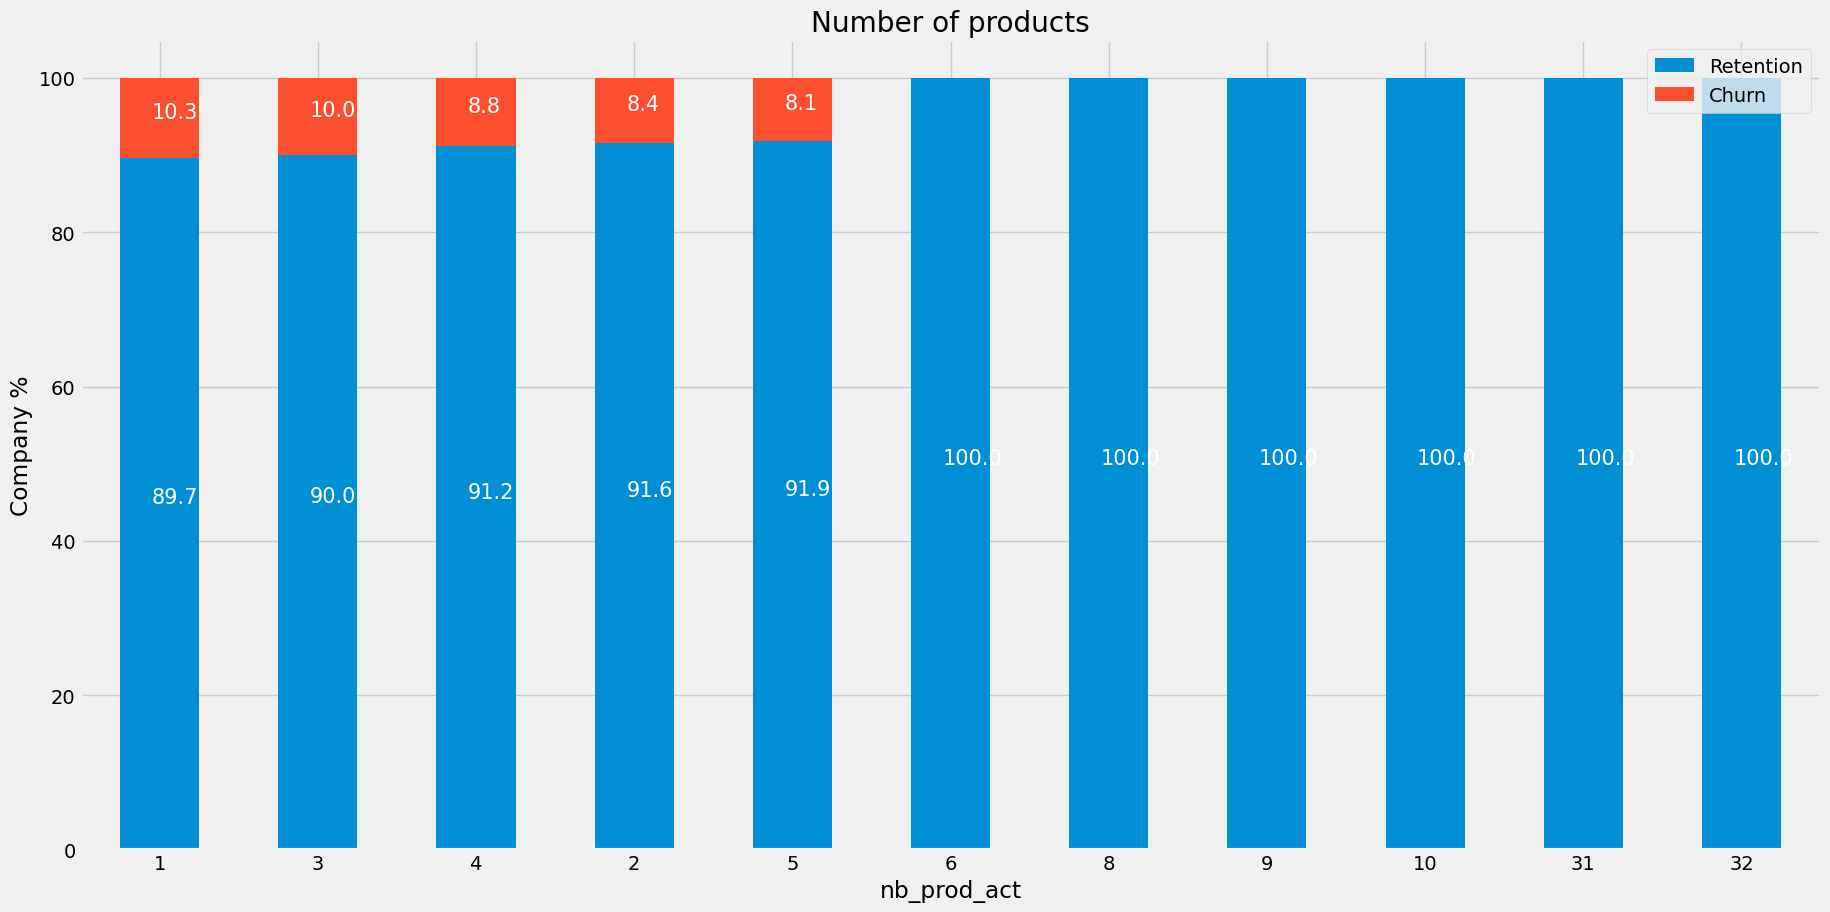

In [58]:
plot_stack_bars(num_products_percent, 'Number of products', 'Company %')

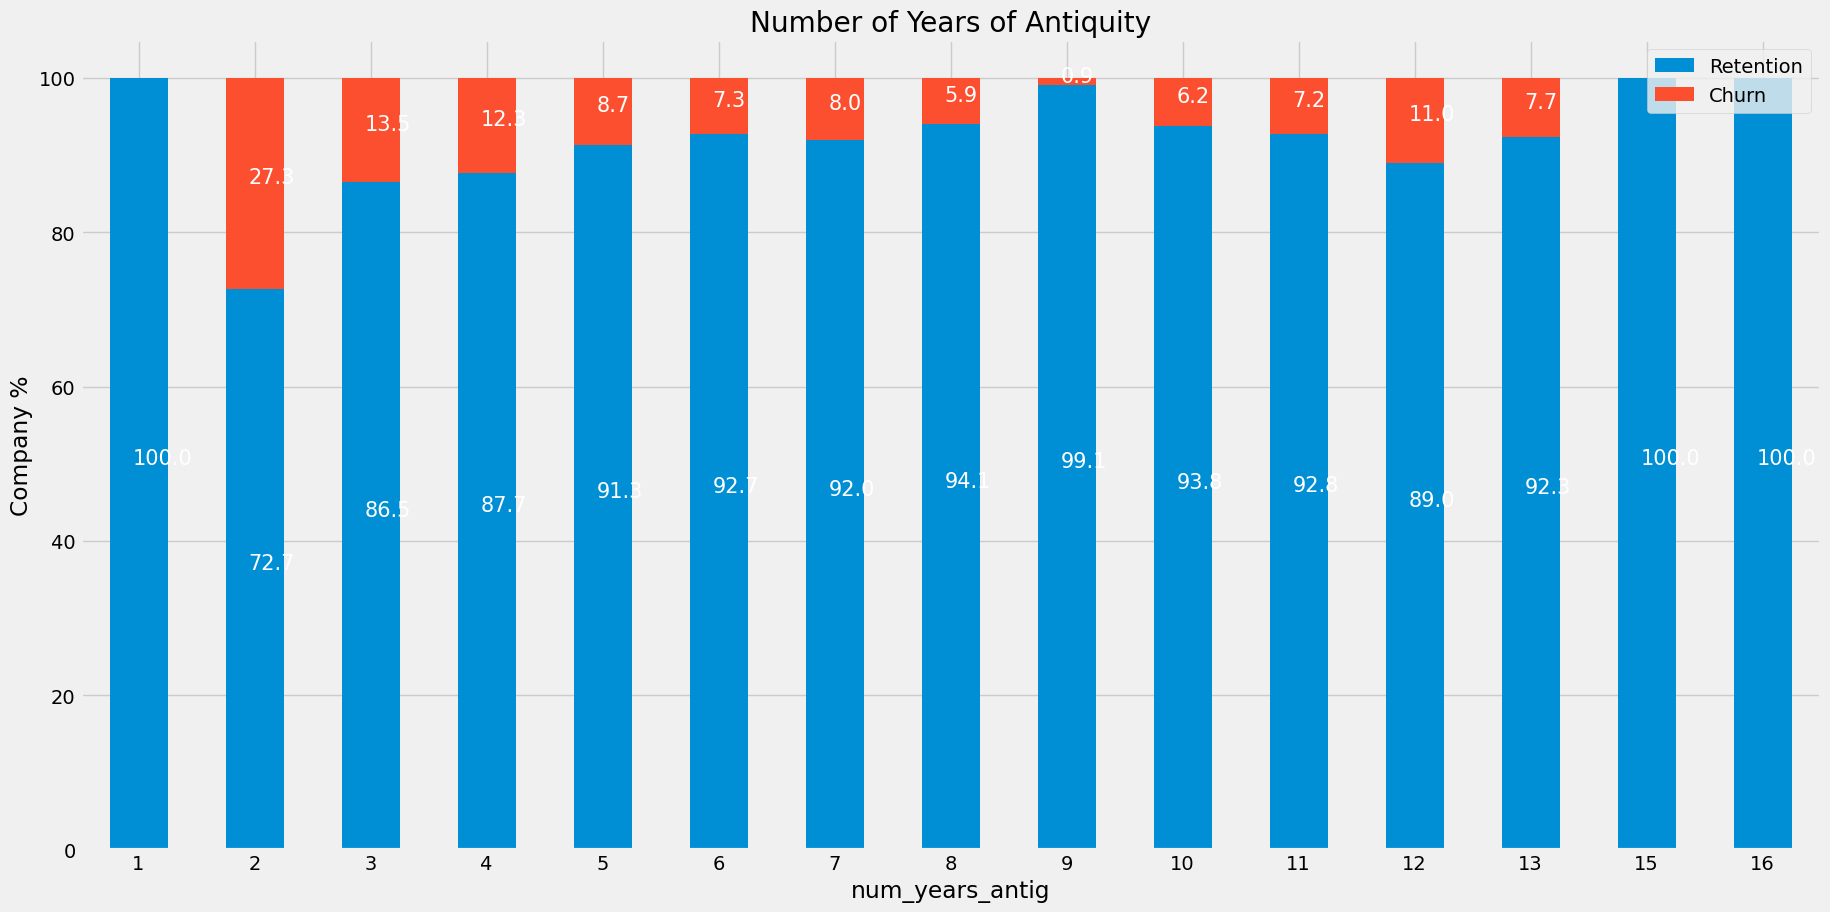

In [59]:
years_antiquity = other_feat.groupby(['num_years_antig' , 'churn'])['id'].count().unstack(level=1)
years_antiquity_percent = (years_antiquity.div(years_antiquity.sum(axis=1) , axis=0)*100)
plot_stack_bars(years_antiquity_percent, 'Number of Years of Antiquity', 'Company %')

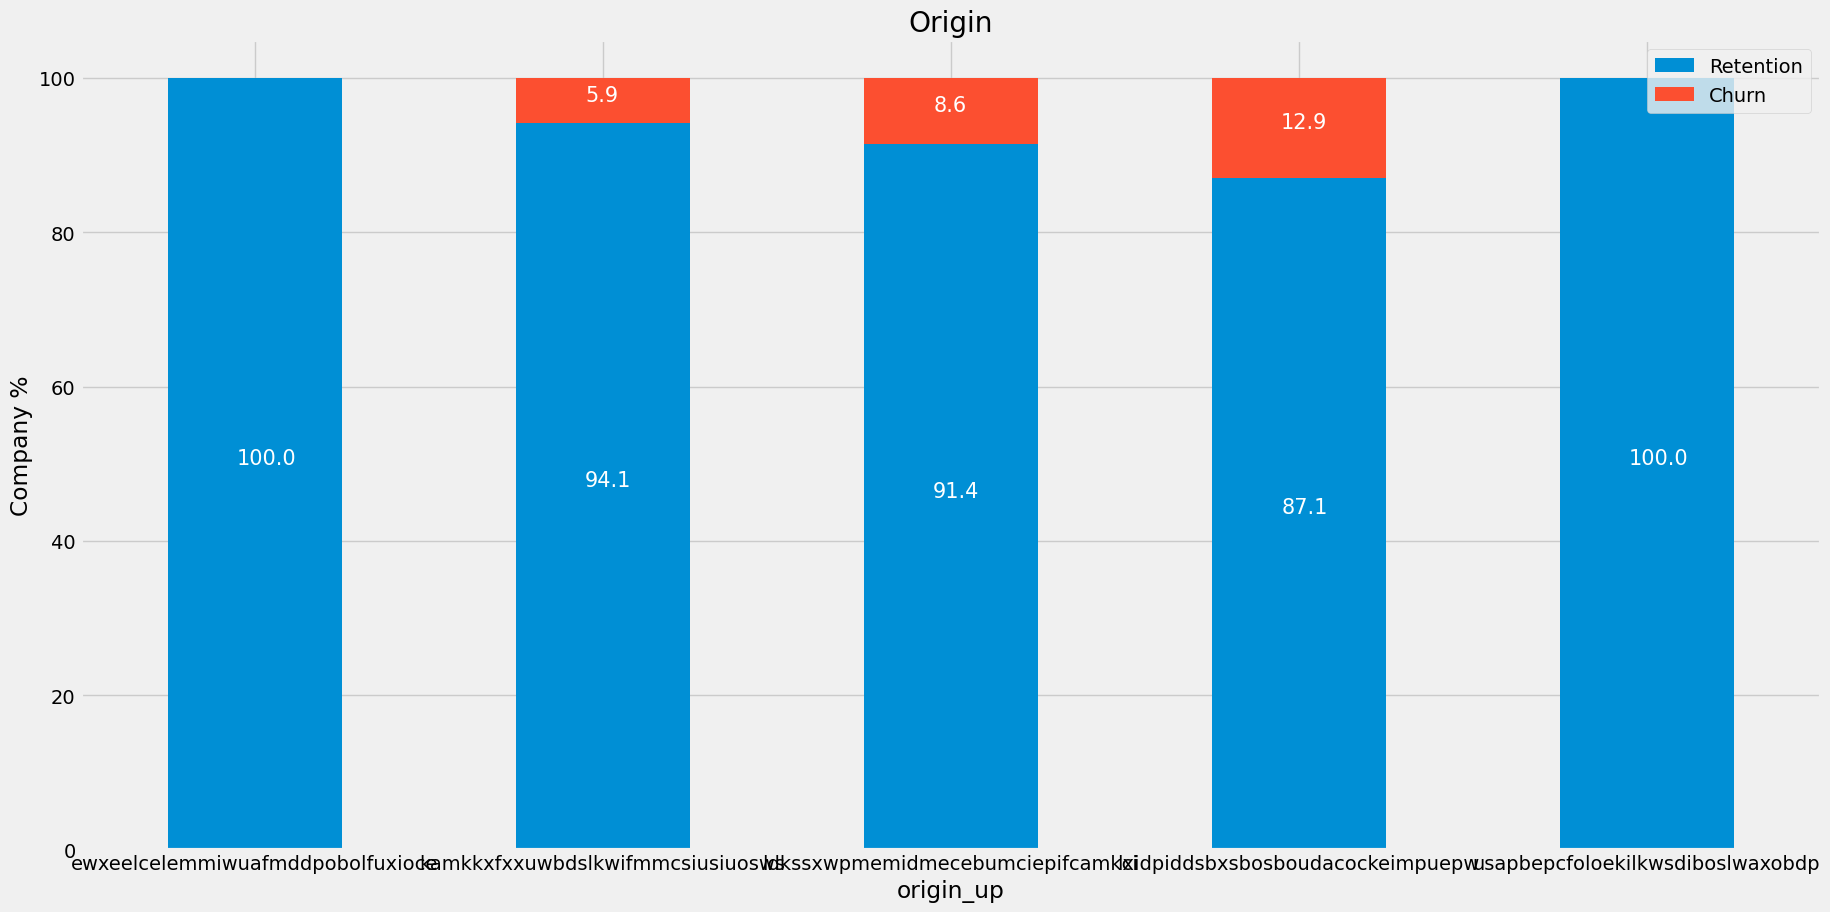

In [60]:
origin = other_feat.groupby(['origin_up' , 'churn'])['id'].count().unstack(level=1)
origin_percent = (origin.div(origin.sum(axis=1) , axis=0)*100)
plot_stack_bars(origin_percent, 'Origin', 'Company %')

## 4. Data cleaning

### 4.1. Missing data

In [61]:
cust_churn.isnull().mean()*100 ## get % of null values in each column

id                            0.000000
activity_new                 59.300447
campaign_disc_ele           100.000000
channel_sales                26.205268
cons_12m                      0.000000
cons_gas_12m                  0.000000
cons_last_month               0.000000
date_activ                    0.000000
date_end                      0.012425
date_first_activ             78.205765
date_modif_prod               0.975398
date_renewal                  0.248509
forecast_base_bill_ele       78.205765
forecast_base_bill_year      78.205765
forecast_bill_12m            78.205765
forecast_cons                78.205765
forecast_cons_12m             0.000000
forecast_cons_year            0.000000
forecast_discount_energy      0.782803
forecast_meter_rent_12m       0.000000
forecast_price_energy_p1      0.782803
forecast_price_energy_p2      0.782803
forecast_price_pow_p1         0.782803
has_gas                       0.000000
imp_cons                      0.000000
margin_gross_pow_ele     

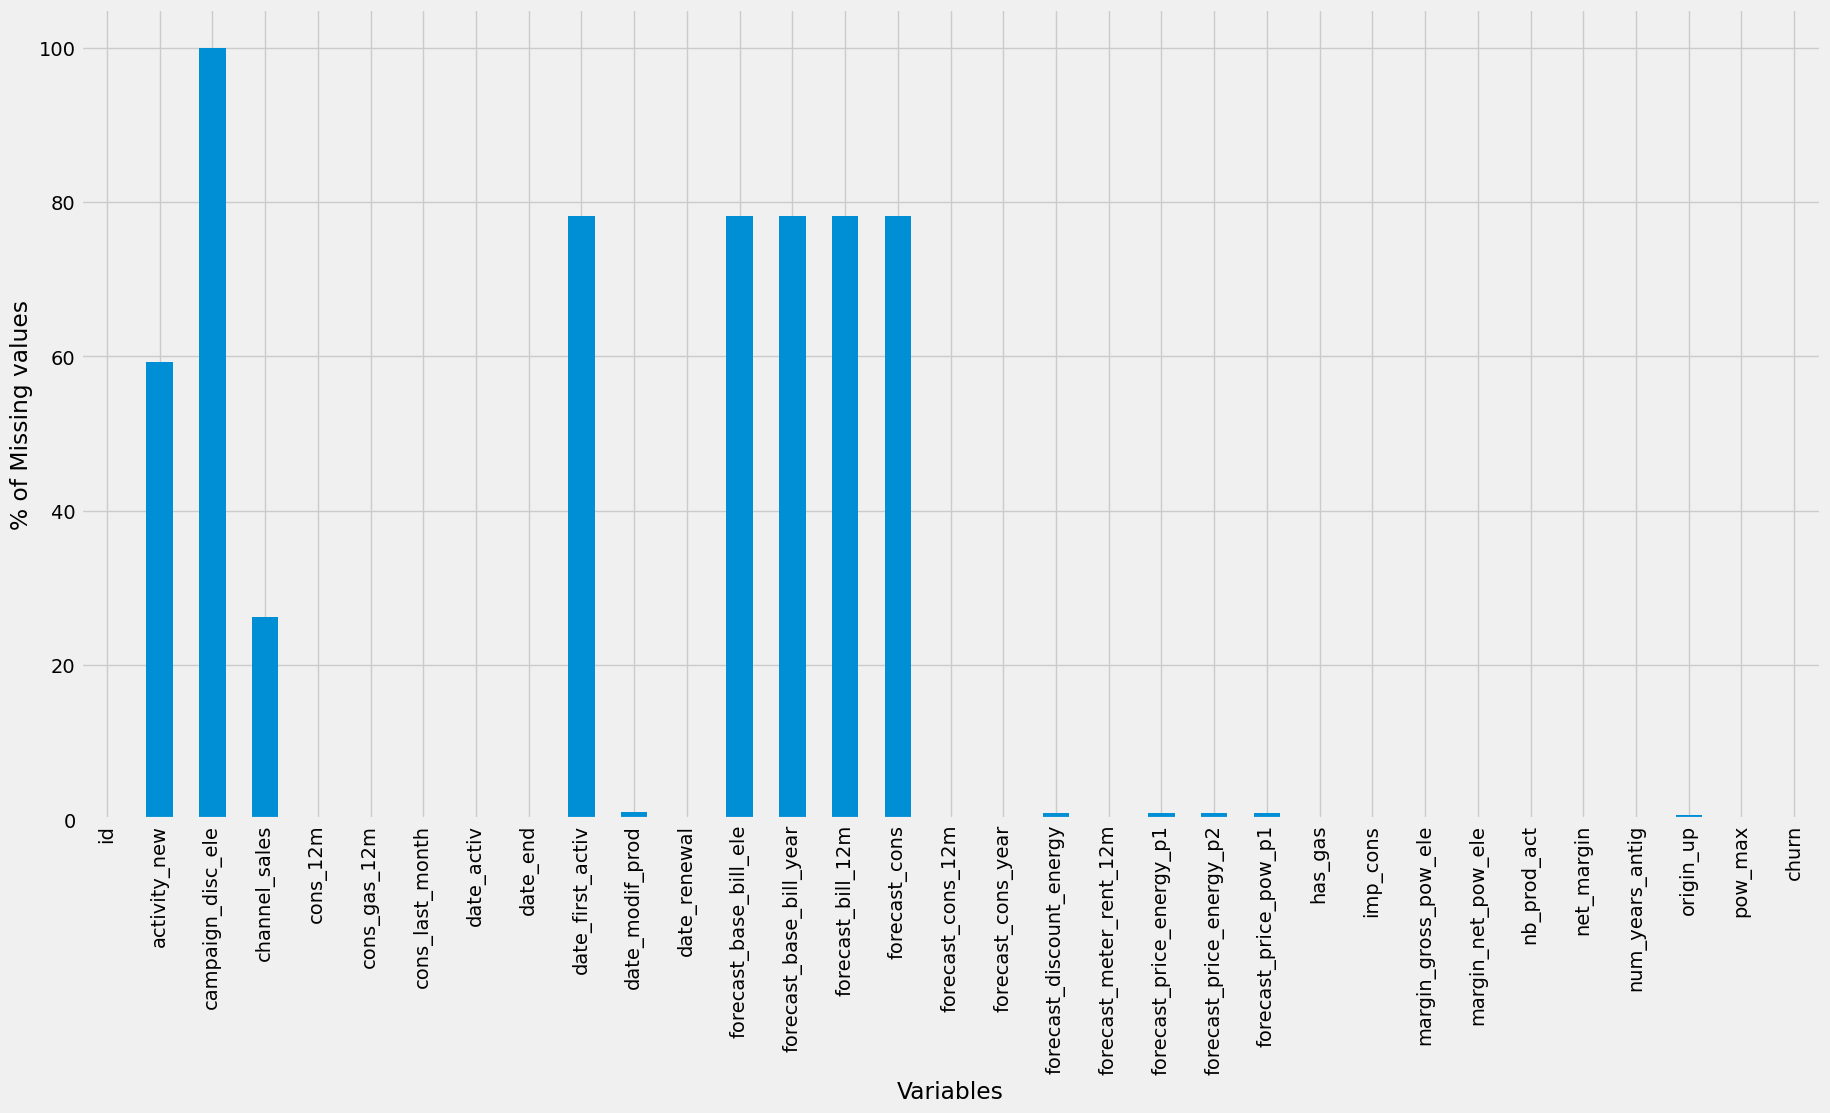

In [62]:
(cust_churn.isnull().mean()*100).plot(kind='bar', figsize=(20,10))
plt.xlabel('Variables')
plt.ylabel('% of Missing values')
plt.show()

Column values with more than 60% of the values missing is dropped

In [63]:
cust_churn.drop(columns=['campaign_disc_ele', 'date_first_activ', 'forecast_base_bill_ele', 'forecast_base_bill_year',
                        'forecast_bill_12m', 'forecast_cons'], inplace=True)

## or another way to do this: use direct filter of values less than 60% and remove them

### 4.2 Check for duplicates

In [64]:
cust_churn[cust_churn.duplicated()]

,id,activity_new,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn


No duplicate values are found in the dataset

### 4.3 Formatting Data

### 4.3.1 Missing Dates

There could be several ways in which we could deal with the missing dates.<br>
One way, we could "engineer" the dates from known values. For example, the
date_renewal
is usually the same date as the
date_modif_prod
but one year ahead.
The simplest way, we will replace the missing values with the median (the most frequent date). For numerical values, the built-in function
.median()
can be used, but this will not work for dates or strings, so we will use a workaround using
.valuecounts()

In [65]:
cust_churn.loc[cust_churn['date_modif_prod'].isnull(), 'date_modif_prod'] = cust_churn['date_modif_prod'].value_counts().index[0] 
# value counts sorts in decending order so first index value is repeated more frequently

# Similarly
cust_churn.loc[cust_churn['date_end'].isnull(), 'date_end'] = cust_churn['date_end'].value_counts().index[0]
cust_churn.loc[cust_churn['date_renewal'].isnull(), 'date_renewal'] = cust_churn['date_renewal'].value_counts().index[0]

We might have some prices missing for some companies and months

In [66]:
hist_price.isnull().mean()

id              0.000000
price_date      0.000000
price_p1_var    0.007041
price_p2_var    0.007041
price_p3_var    0.007041
price_p1_fix    0.007041
price_p2_fix    0.007041
price_p3_fix    0.007041
dtype: float64

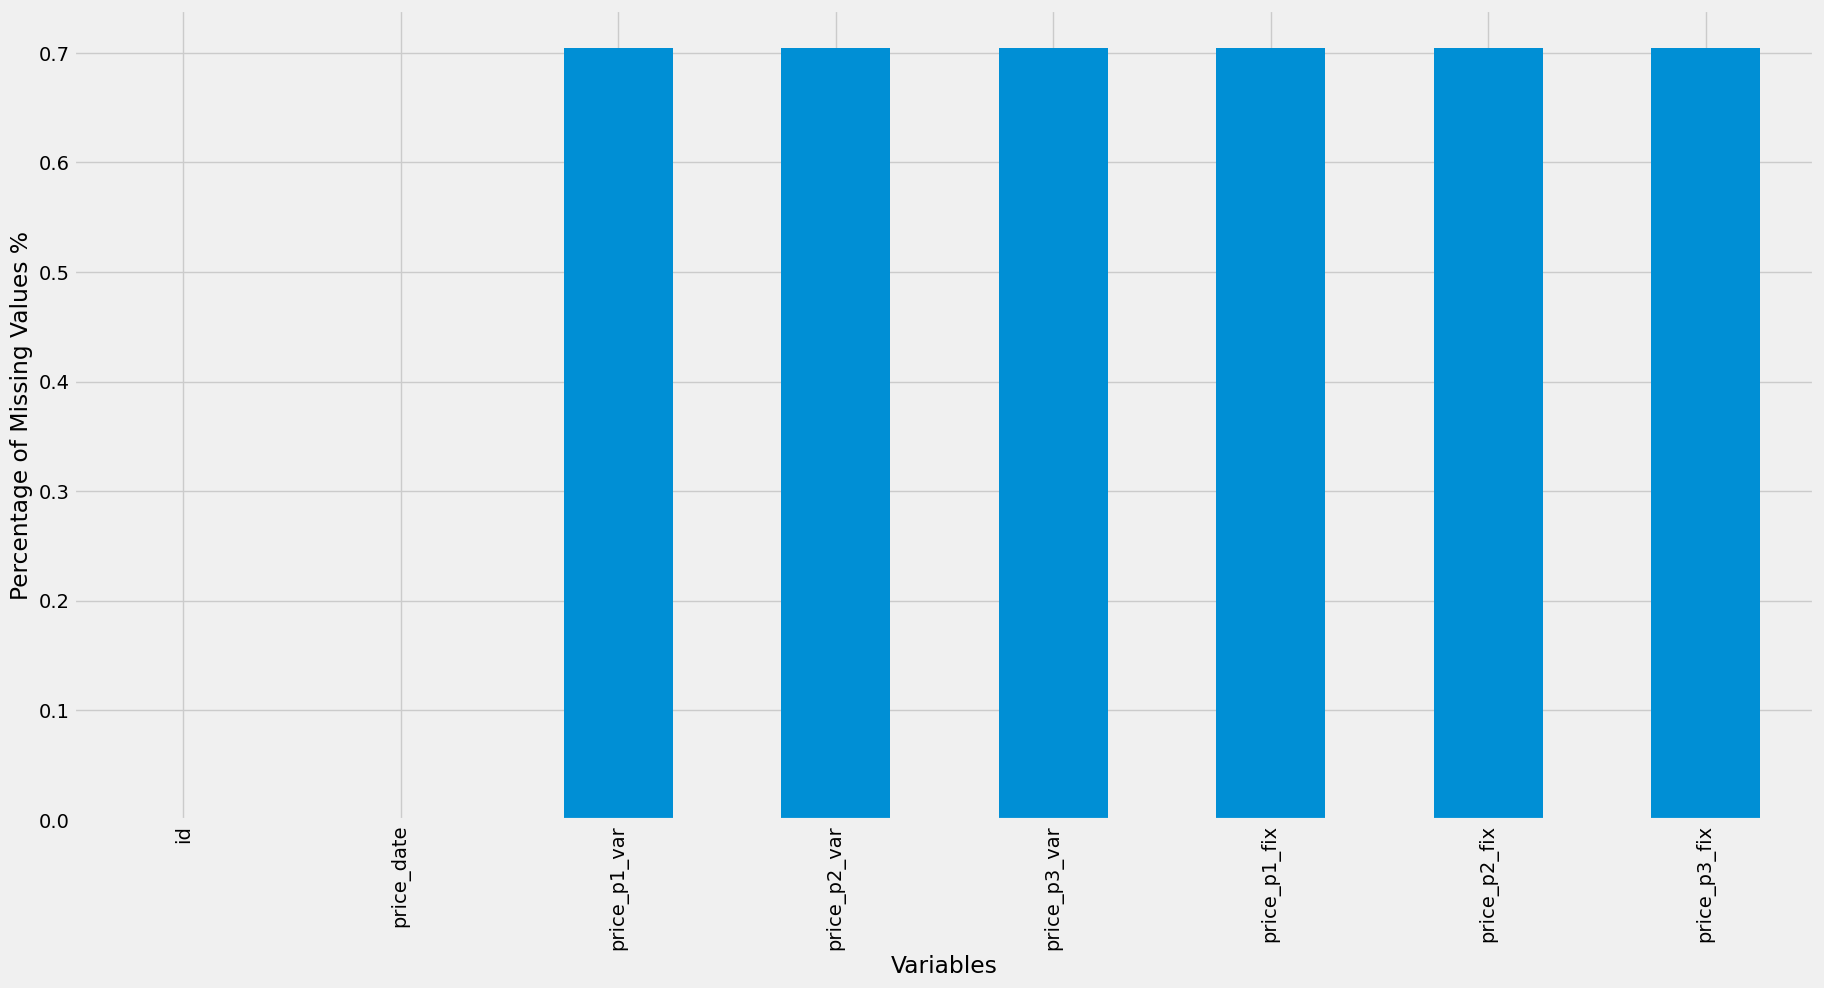

In [67]:
(hist_price.isnull().mean()*100).plot(kind='bar', figsize=(20,10))
plt.xlabel('Variables')
plt.ylabel('Percentage of Missing Values %')
plt.show()

There is not much data missing. Instead of removing the entries that are empty we will simply substitute them with the
median

In [68]:
hist_price.columns

Index(['id', 'price_date', 'price_p1_var', 'price_p2_var', 'price_p3_var',
       'price_p1_fix', 'price_p2_fix', 'price_p3_fix'],
      dtype='object')

In [69]:
hist_price.loc[hist_price['price_p1_var'].isnull(), 'price_p1_var']=hist_price['price_p1_var'].median()
hist_price.loc[hist_price['price_p2_var'].isnull(), 'price_p2_var']=hist_price['price_p2_var'].median()
hist_price.loc[hist_price['price_p3_var'].isnull(), 'price_p3_var']=hist_price['price_p3_var'].median()
hist_price.loc[hist_price['price_p1_fix'].isnull(), 'price_p1_fix']=hist_price['price_p1_fix'].median()
hist_price.loc[hist_price['price_p2_fix'].isnull(), 'price_p2_fix']=hist_price['price_p2_fix'].median()
hist_price.loc[hist_price['price_p3_fix'].isnull(), 'price_p3_fix']=hist_price['price_p3_fix'].median()

In order to use the dates in our churn prediction model we are going to change the representation of these dates. Instead of using the date itself, wewill be transforming it in number of months. In order to make this transformation we need to change the dates to
datetime
and create a
reference date
which will be January 2016 

### 4.3.2. Formatting dates - customer churn data and price history data

In [70]:
cust_churn['date_activ'] = pd.to_datetime(cust_churn['date_activ'] , format='%Y-%m-%d')
cust_churn['date_end'] = pd.to_datetime(cust_churn['date_end'] , format='%Y-%m-%d')
cust_churn['date_modif_prod'] = pd.to_datetime(cust_churn['date_modif_prod'] , format='%Y-%m-%d')
cust_churn['date_renewal'] = pd.to_datetime(cust_churn['date_renewal'] , format='%Y-%m-%d')

In [71]:
hist_price['price_date'] = pd.to_datetime(hist_price['price_date'], format='%Y-%m-%d')

### 4.3 Negative Data points

In [72]:
hist_price.describe()

,price_date,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix
count,193002,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000
mean,2015-06-16 12:50:49.933161216,0.141027,0.054630,0.030496,43.332175,10.622871,6.409981
min,2015-01-01 00:00:00,0.000000,0.000000,0.000000,-0.177779,-0.097752,-0.065172
25%,2015-04-01 00:00:00,0.125976,0.000000,0.000000,40.728885,0.000000,0.000000
50%,2015-07-01 00:00:00,0.146033,0.085483,0.000000,44.266930,0.000000,0.000000
75%,2015-10-01 00:00:00,0.151635,0.101673,0.072558,44.444710,24.339581,16.226389
max,2015-12-01 00:00:00,0.280700,0.229788,0.114102,59.444710,36.490692,17.458221
std,NaN,0.025032,0.049924,0.036298,5.419345,12.841899,7.773595


We can see that there are negative values for
price_p1_fix
,
price_p2_fix
and
price_p3_fix
.
Further exploring on those we can see there are only about
10
entries which are negative. This is more likely to be due to corrupted data rather thana "price discount".
We will replace the negative values with the
median
(most frequent value)

In [73]:
hist_price[(hist_price['price_p1_fix'] <0) |(hist_price['price_p2_fix'] <0) | (hist_price['price_p3_fix'] <0)] ## 10 cases in total

,id,price_date,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix
23138,951d99fe07ca94c2139f43bc37095139,2015-03-01,0.125976,0.103395,0.071536,-0.162916,-0.097749,-0.065166
28350,f7bdc6fa1067cd26fd80bfb9f3fca28f,2015-03-01,0.131032,0.108896,0.076955,-0.162916,-0.097749,-0.065166
98575,9b523ad5ba8aa2e524dcda5b3d54dab2,2015-02-01,0.129444,0.106863,0.075004,-0.162916,-0.097749,-0.065166
113467,cfd098ee6c567eb32374c77d20571bc7,2015-02-01,0.123086,0.100505,0.068646,-0.162916,-0.097749,-0.065166
118467,51d7d8a0bf6b8bd94f8c1de7942c66ea,2015-07-01,0.128132,0.105996,0.074056,-0.162912,-0.097752,-0.065172
125819,decc0a647016e183ded972595cd2b9fb,2015-03-01,0.124937,0.102814,0.069071,-0.162916,-0.097749,-0.065166
128761,cc214d7c05de3ee17a7691e274ac488e,2015-06-01,0.124675,0.102539,0.070596,-0.162912,-0.097752,-0.065172
141011,2a4ed325054472e03cdcc9a34693be4b,2015-02-01,0.167317,0.083347,0.000000,-0.177779,0.000000,0.000000
160827,395a6f41bbd1a0f23a64f00645264e78,2015-04-01,0.121352,0.098771,0.066912,-0.162916,-0.097749,-0.065166
181811,d4a84ff4ec620151ef05bdef0cf27eab,2015-05-01,0.125976,0.103395,0.071536,-0.162916,-0.097749,-0.065166


In [74]:
hist_price.loc[hist_price['price_p1_fix'] < 0 , 'price_p1_fix'] = hist_price['price_p1_fix'].median()
hist_price.loc[hist_price['price_p2_fix'] < 0 , 'price_p2_fix'] = hist_price['price_p2_fix'].median()
hist_price.loc[hist_price['price_p3_fix'] < 0 , 'price_p3_fix'] = hist_price['price_p3_fix'].median()

## Feature Engineering

### 5.1 New feature cretion

We will create new features using the average of the year, the last six months, and the last three months to our model beacuse we have the consumption data for each of the companies for the year 2015.

In [75]:
mean_year = hist_price.groupby(['id']).mean().reset_index()
mean_year

,id,price_date,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix
0,0002203ffbb812588b632b9e628cc38d,2015-06-16 12:00:00,0.124338,0.103794,0.073160,40.701732,24.421038,16.280694
1,0004351ebdd665e6ee664792efc4fd13,2015-06-16 12:00:00,0.146426,0.000000,0.000000,44.385450,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,2015-06-16 12:00:00,0.181558,0.000000,0.000000,45.319710,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,2015-06-16 12:00:00,0.118757,0.098292,0.069032,40.647427,24.388455,16.258971
4,00114d74e963e47177db89bc70108537,2015-06-16 12:00:00,0.147926,0.000000,0.000000,44.266930,0.000000,0.000000
...,...,...,...,...,...,...,...,...
16091,ffef185810e44254c3a4c6395e6b4d8a,2015-06-16 12:00:00,0.138863,0.115125,0.080780,40.896427,24.637456,16.507972
16092,fffac626da707b1b5ab11e8431a4d0a2,2015-06-16 12:00:00,0.147137,0.000000,0.000000,44.311375,0.000000,0.000000
16093,fffc0cacd305dd51f316424bbb08d1bd,2015-06-16 12:00:00,0.153879,0.129497,0.094842,41.160171,24.895768,16.763569
16094,fffe4f5646aa39c7f97f95ae2679ce64,2015-06-16 12:00:00,0.123858,0.103499,0.073735,40.606699,24.364017,16.242678


In [76]:
mean_6m = hist_price[hist_price['price_date'] > '2015-06-01'].groupby(['id']).mean().reset_index()
mean_3m = hist_price[hist_price['price_date'] > '2015-10-01'].groupby(['id']).mean().reset_index()

In [77]:
mean_year = mean_year.rename(index = str, columns={'price_p1_var' : 'mean_year_price_p1_var',
                                                  'price_p2_var' : 'mean_year_price_p2_var',
                                                  'price_p3_var' : 'mean_year_price_p3_var',
                                                  'price_p1_fix' : 'mean_year_price_p1_fix',
                                                  'price_p2_fix' : 'mean_year_price_p2_fix',
                                                  'price_p3_fix' : 'mean_year_price_p3_fix'
                                                  })

In [78]:
mean_year['mean_year_price_p1'] = mean_year['mean_year_price_p1_var'] + mean_year['mean_year_price_p1_fix']
mean_year['mean_year_price_p2'] = mean_year['mean_year_price_p2_var'] + mean_year['mean_year_price_p2_fix']
mean_year['mean_year_price_p3'] = mean_year['mean_year_price_p3_var'] + mean_year['mean_year_price_p3_fix']

In [79]:
## we repeat the above processs for 6 and 3 months respectively

In [80]:
mean_6m = mean_6m.rename(index = str, columns={'price_p1_var' : 'mean_6m_price_p1_var',
                                                  'price_p2_var' : 'mean_6m_price_p2_var',
                                                  'price_p3_var' : 'mean_6m_price_p3_var',
                                                  'price_p1_fix' : 'mean_6m_price_p1_fix',
                                                  'price_p2_fix' : 'mean_6m_price_p2_fix',
                                                  'price_p3_fix' : 'mean_6m_price_p3_fix'})

In [81]:
mean_6m['mean_6m_price_p1'] = mean_6m['mean_6m_price_p1_var'] + mean_6m['mean_6m_price_p1_fix']
mean_6m['mean_6m_price_p2'] = mean_6m['mean_6m_price_p2_var'] + mean_6m['mean_6m_price_p2_fix']
mean_6m['mean_6m_price_p3'] = mean_6m['mean_6m_price_p3_var'] + mean_6m['mean_6m_price_p3_fix']

In [82]:
mean_3m = mean_3m.rename(index = str, columns={'price_p1_var' : 'mean_3m_price_p1_var',
                                                  'price_p2_var' : 'mean_3m_price_p2_var',
                                                  'price_p3_var' : 'mean_3m_price_p3_var',
                                                  'price_p1_fix' : 'mean_3m_price_p1_fix',
                                                  'price_p2_fix' : 'mean_3m_price_p2_fix',
                                                  'price_p3_fix' : 'mean_3m_price_p3_fix'})

In [83]:
mean_3m['mean_3m_price_p1'] = mean_3m['mean_3m_price_p1_var'] + mean_3m['mean_3m_price_p1_fix']
mean_3m['mean_3m_price_p2'] = mean_3m['mean_3m_price_p2_var'] + mean_3m['mean_3m_price_p2_fix']
mean_3m['mean_3m_price_p3'] = mean_3m['mean_3m_price_p3_var'] + mean_3m['mean_3m_price_p3_fix']

We create a new feature,  <b> tenure = date_end - date_activ</b>

In [84]:
cust_churn['tenure'] = ((cust_churn['date_end'] - cust_churn['date_activ']) / np.timedelta64(1,'Y')).astype(int)

In [85]:
tenure = cust_churn[['tenure', 'churn', 'id']].groupby(['tenure','churn'])['id'].count().unstack(level=1)
tenure

churn,0,1
tenure,,
1,1.0,NaN
2,50.0,9.0
3,1249.0,210.0
4,3487.0,516.0
5,2766.0,295.0
6,3475.0,291.0
7,2710.0,220.0
8,200.0,14.0
9,98.0,1.0


In [86]:
tenure_percentage = (tenure.div(tenure.sum(axis=1), axis=0)*100)
tenure_percentage

churn,0,1
tenure,,
1,100.000000,NaN
2,84.745763,15.254237
3,85.606580,14.393420
4,87.109668,12.890332
5,90.362627,9.637373
6,92.272969,7.727031
7,92.491468,7.508532
8,93.457944,6.542056
9,98.989899,1.010101


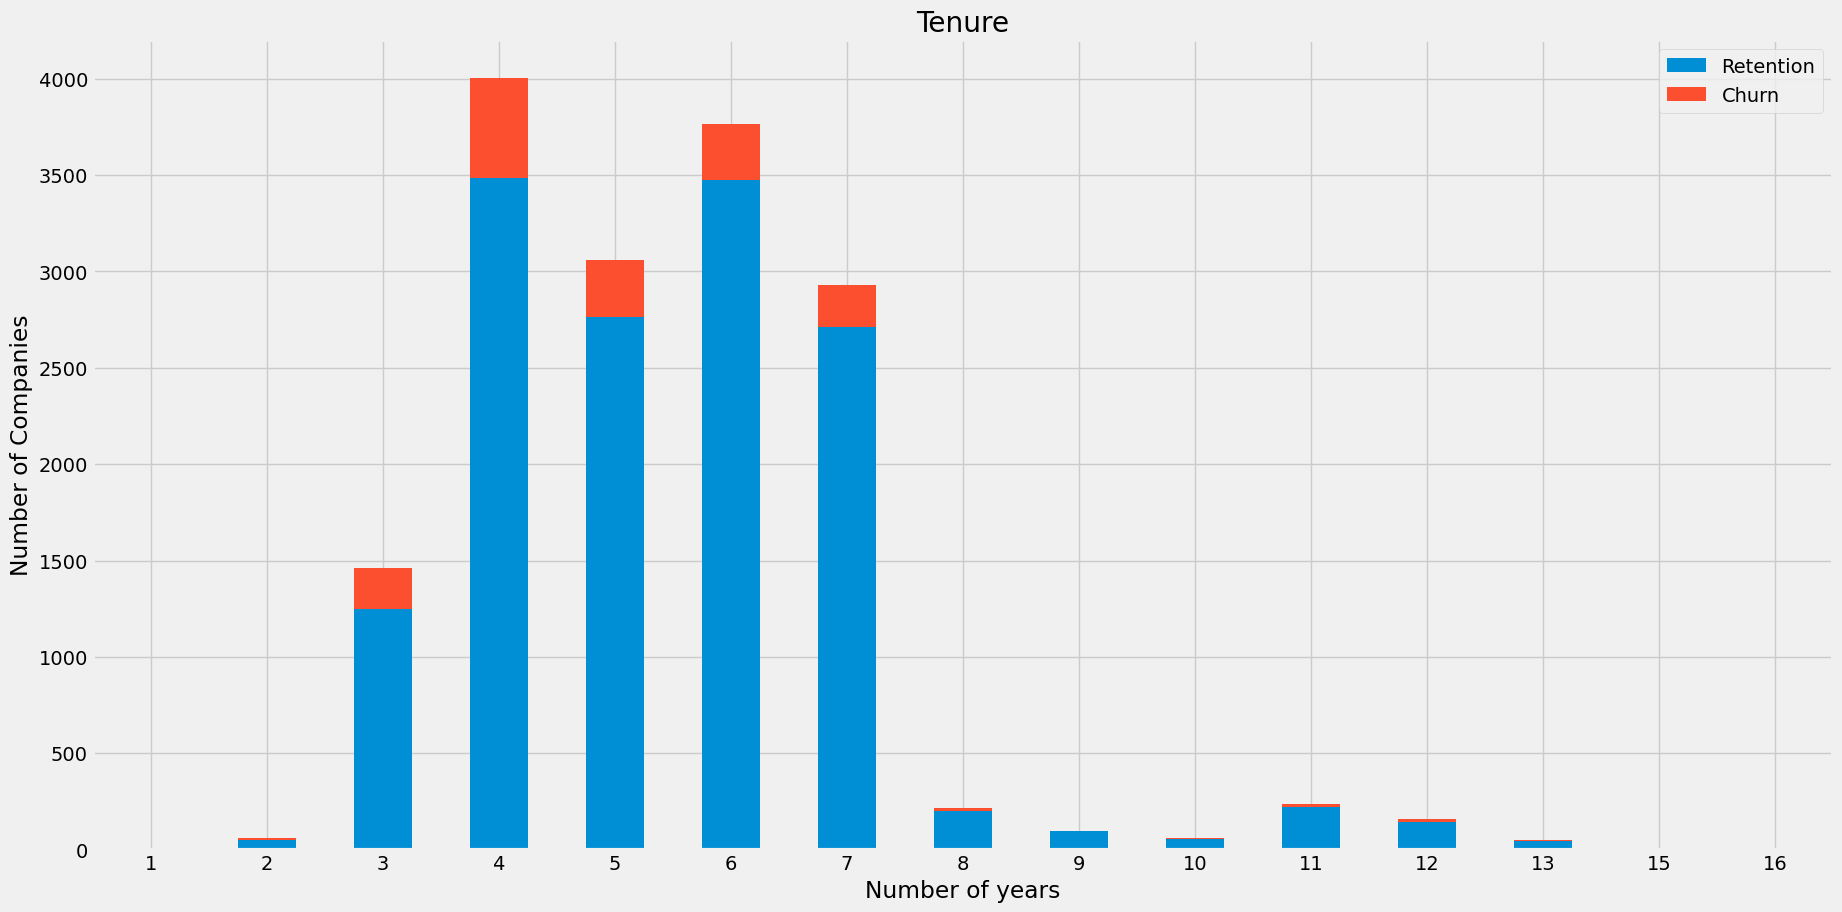

In [87]:
tenure.plot(kind='bar', figsize=(20,10), stacked=True, rot=0, title='Tenure')

plt.legend(['Retention', 'Churn'], loc='upper right')
plt.ylabel('Number of Companies')
plt.xlabel('Number of years')
plt.show()

The churn is very low for companies which joined recently or that have made the contract a long time ago. With the higher number of churners within the 3-7 years of tenure.

Need to transform the date columns to gain more insights.<br>
months_activ : Number of months active until reference date (Jan 2016)<br>
months_to_end : Number of months of the contract left at reference date (Jan 2016)<br>
months_modif_prod : Number of months since last modification at reference date (Jan 2016)<br>
months_renewal : Number of months since last renewal at reference date (Jan 2016)

In [88]:
def get_months(ref_date, df, col):

    time_diff = ref_date - df[col]
    months = (time_diff / np.timedelta64(1, 'M')).astype(int)

    return months

In [89]:
ref_date = datetime.datetime(2016, 1, 1)
ref_date

datetime.datetime(2016, 1, 1, 0, 0)

In [90]:
cust_churn['months_activ'] = get_months(ref_date, cust_churn , 'date_activ')
cust_churn['months_end'] = -get_months(ref_date, cust_churn , 'date_end')
cust_churn['months_modif_prod'] = get_months(ref_date, cust_churn , 'date_modif_prod')
cust_churn['months_renewal'] = get_months(ref_date, cust_churn , 'date_renewal')

In [91]:
def plot_monthly_churn(df, col):
    
    churn_per_month = df[[col, 'churn', 'id']].groupby([col, 'churn'])['id'].count().unstack(level=1)
    churn_per_month.plot(kind = 'bar', figsize=(20,10) , stacked=True, rot=0, title=col)
    plt.legend(['Retention', 'Churn'], loc='upper right')
    plt.ylabel('Number of companies')
    plt.ylabel('Number of Months')
    plt.show()

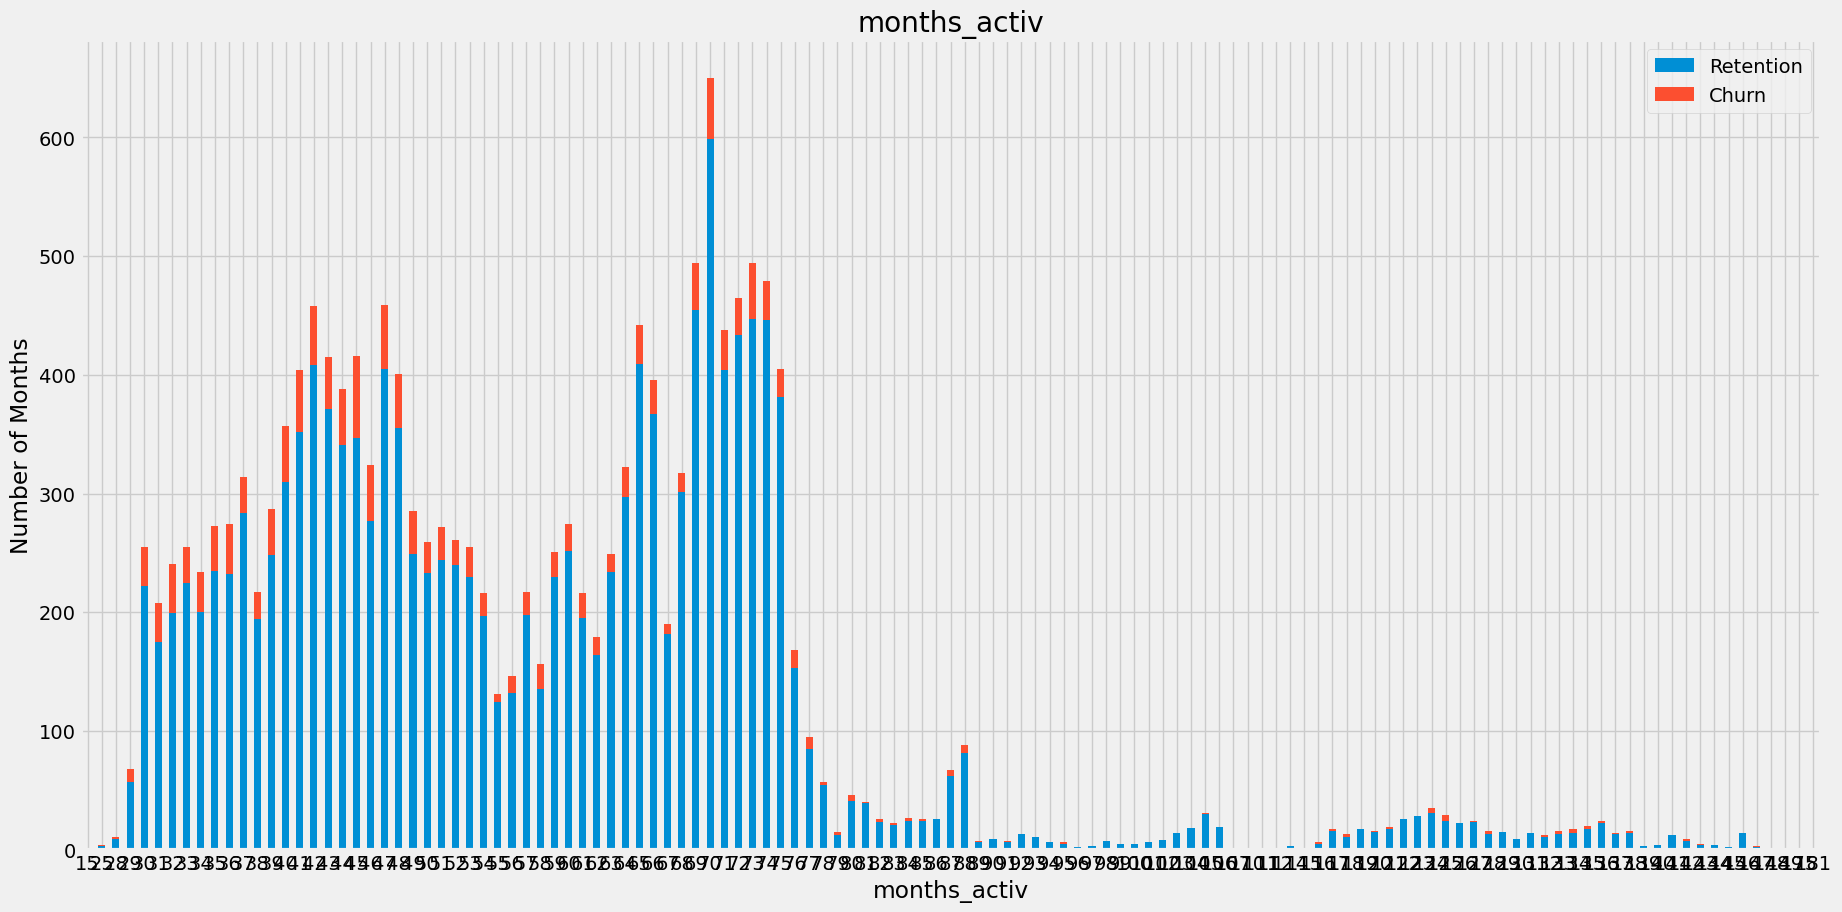

In [92]:
plot_monthly_churn(cust_churn, 'months_activ')

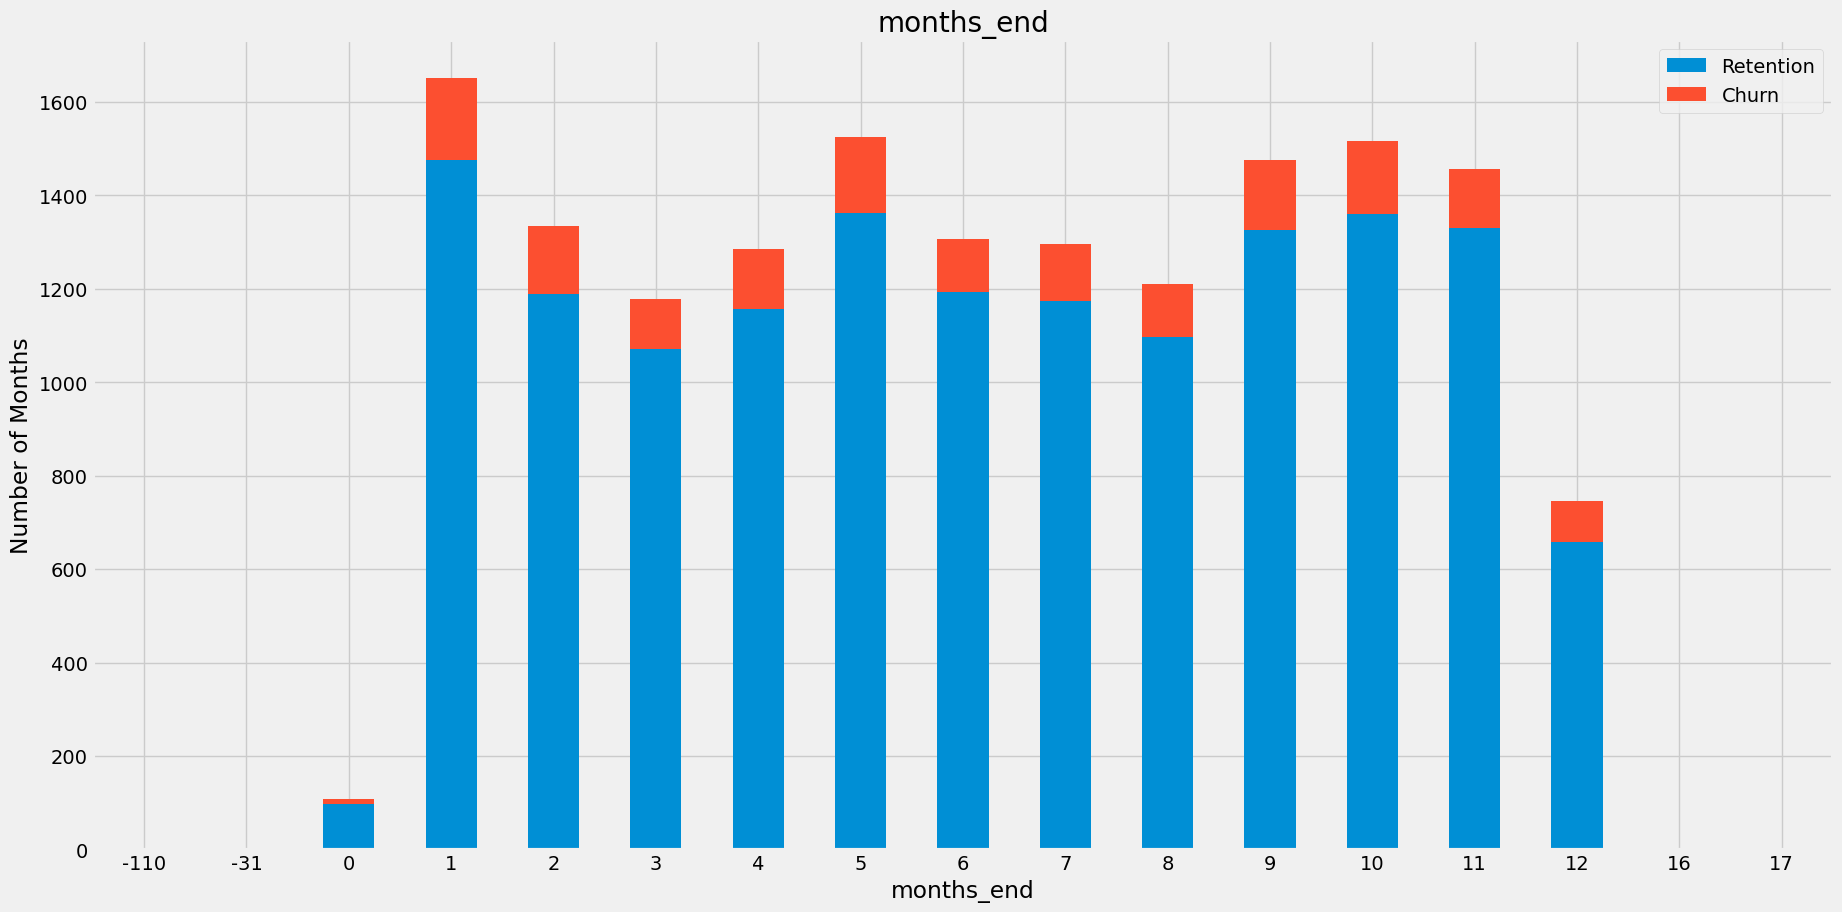

In [93]:
plot_monthly_churn(cust_churn, 'months_end')

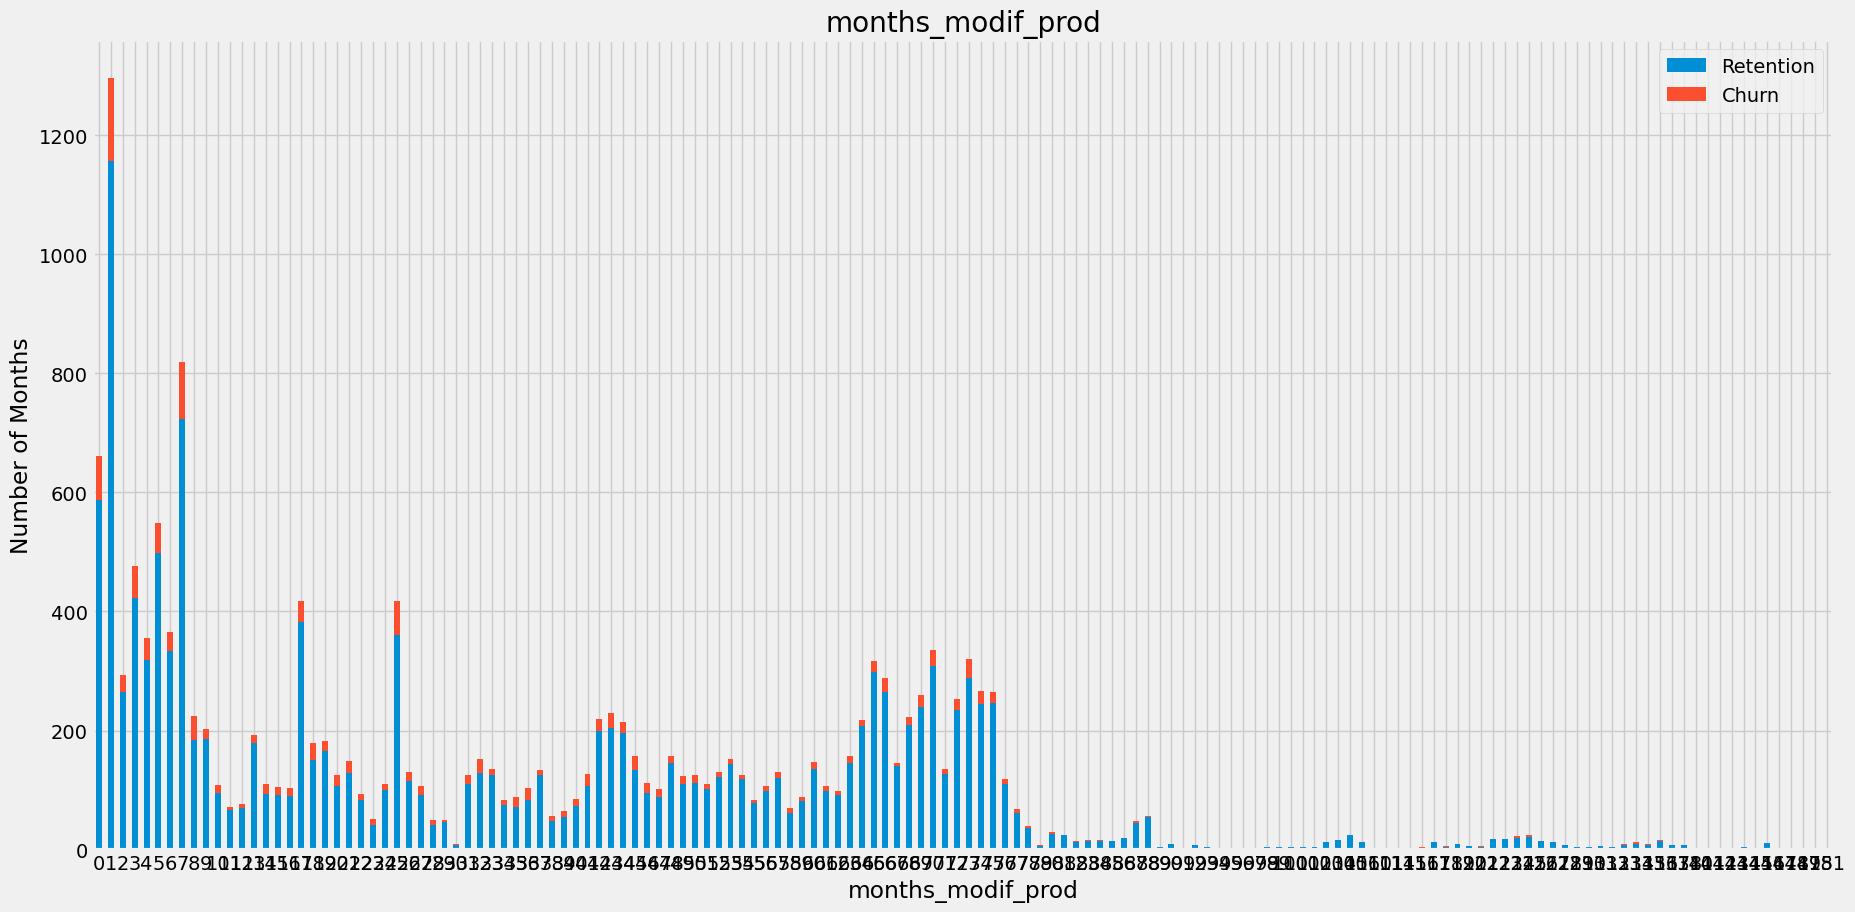

In [94]:
plot_monthly_churn(cust_churn, 'months_modif_prod')

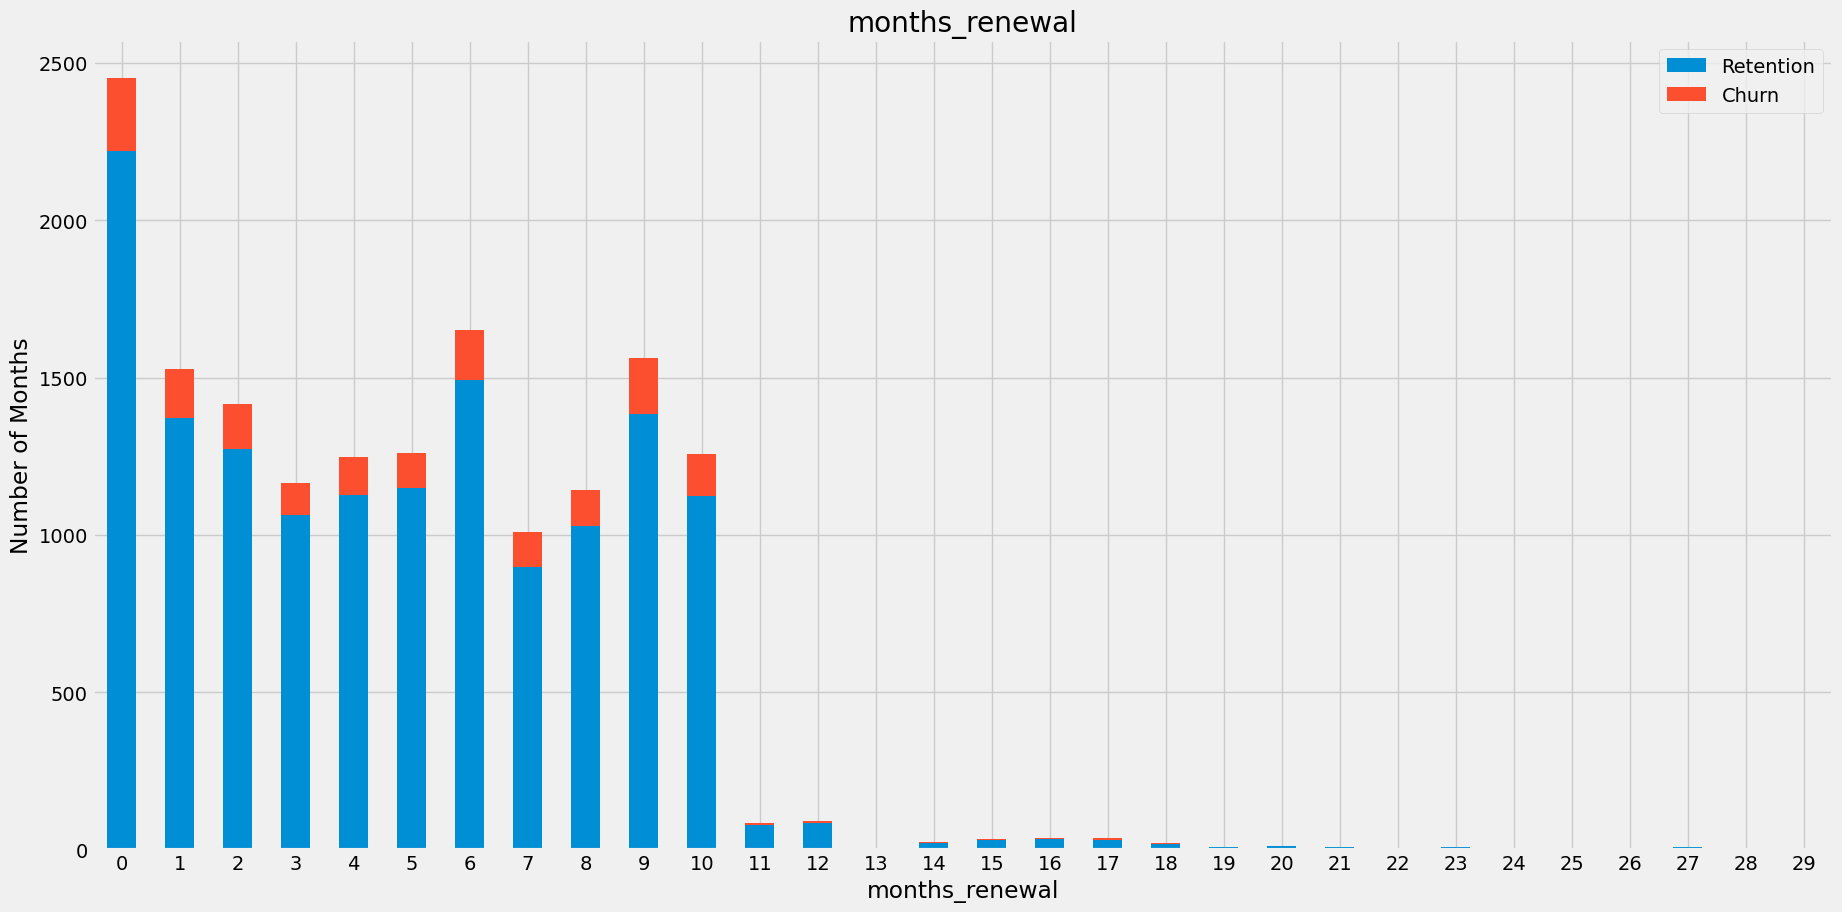

In [95]:
plot_monthly_churn(cust_churn, 'months_renewal')

Remove date columns

In [96]:
cust_churn.drop(columns=['date_activ', 'date_end', 'date_modif_prod', 'date_renewal'], inplace=True)

### 5.2 Boolean data Transformation
For the column has_gas, we will replace t for True or 1 and f for False or 0 (onehot encoding)

In [97]:
cust_churn['has_gas'] = cust_churn['has_gas'].replace(['t','f'], [1,0])
cust_churn['has_gas']

0        0
1        1
2        0
3        0
4        0
        ..
16091    1
16092    0
16093    0
16094    0
16095    0
Name: has_gas, Length: 16096, dtype: int64

### 5.3. Categorical data and dummy variables

Categorical data channel_sales <br>

Categorical data channel_sales
What we are doing here relatively simple, we want to convert each category into a new dummy variable which will have 0 s and 1 s depending
whether than entry belongs to that particular category or not
First of all let's replace the Nan values with a string called null_values_channel

In [98]:
cust_churn['channel_sales'] = cust_churn['channel_sales'].fillna('null_channels')
cust_churn['channel_sales']

0        lmkebamcaaclubfxadlmueccxoimlema
1        foosdfpfkusacimwkcsosbicdxkicaua
2                           null_channels
3        foosdfpfkusacimwkcsosbicdxkicaua
4        lmkebamcaaclubfxadlmueccxoimlema
                       ...               
16091    foosdfpfkusacimwkcsosbicdxkicaua
16092    foosdfpfkusacimwkcsosbicdxkicaua
16093    foosdfpfkusacimwkcsosbicdxkicaua
16094    foosdfpfkusacimwkcsosbicdxkicaua
16095                       null_channels
Name: channel_sales, Length: 16096, dtype: object

Now transform the channel_sales column into categorical data type

In [99]:
cust_churn['channel_sales'] = cust_churn['channel_sales'].astype('category')

In [100]:
cust_churn['channel_sales'].value_counts().reset_index()

,channel_sales,count
0,foosdfpfkusacimwkcsosbicdxkicaua,7377
1,null_channels,4218
2,lmkebamcaaclubfxadlmueccxoimlema,2073
3,usilxuppasemubllopkaafesmlibmsdf,1444
4,ewpakwlliwisiwduibdlfmalxowmwpci,966
5,sddiedcslfslkckwlfkdpoeeailfpeds,12
6,epumfxlbckeskwekxbiuasklxalciiuu,4
7,fixdbufsefwooaasfcxdxadsiekoceaa,2


So that means we will create 8 different dummy variables . Each variable will become a different column.

In [101]:
# Dumy variables
channels_category = pd.get_dummies(cust_churn['channel_sales'], prefix='channel', dtype=int) ## get_dumies -> one hot encoding (1 , 0)
# use dtype,  since default will get true or false
channels_category

,channel_epumfxlbckeskwekxbiuasklxalciiuu,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_fixdbufsefwooaasfcxdxadsiekoceaa,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_null_channels,channel_sddiedcslfslkckwlfkdpoeeailfpeds,channel_usilxuppasemubllopkaafesmlibmsdf
0,0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...
16091,0,0,0,1,0,0,0,0
16092,0,0,0,1,0,0,0,0
16093,0,0,0,1,0,0,0,0
16094,0,0,0,1,0,0,0,0


In [102]:
channels_category.columns = [col[:11] for col in channels_category.columns]

In [103]:
channels_category.head(10)

,channel_epu,channel_ewp,channel_fix,channel_foo,channel_lmk,channel_nul,channel_sdd,channel_usi
0,0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0
5,0,0,0,1,0,0,0,0
6,0,0,0,0,0,1,0,0
7,0,0,0,0,0,0,0,1
8,0,0,0,1,0,0,0,0
9,0,0,0,1,0,0,0,0


Multicollinearity can affect our models so we will remove one of the columns.

In [104]:
channels_category.drop(columns=['channel_nul'] , inplace=True) ## you can delete anytype of values instead of this

### Categorical data origin_up

In [105]:
cust_churn['origin_up'] = cust_churn['origin_up'].fillna('null_origin')

In [106]:
cust_churn['origin_up'] = cust_churn['origin_up'].astype('category')

In [107]:
cust_churn['origin_up'].value_counts().reset_index()

,origin_up,count
0,lxidpiddsbxsbosboudacockeimpuepw,7825
1,kamkkxfxxuwbdslkwifmmcsiusiuosws,4517
2,ldkssxwpmemidmecebumciepifcamkci,3664
3,null_origin,87
4,usapbepcfoloekilkwsdiboslwaxobdp,2
5,ewxeelcelemmiwuafmddpobolfuxioce,1


In [108]:
origin_categories = pd.get_dummies(cust_churn['origin_up'], prefix='origin', dtype= int)
origin_categories.columns = [col[:11] for col in origin_categories.columns]

In [109]:
origin_categories.head(10)

,origin_ewxe,origin_kamk,origin_ldks,origin_lxid,origin_null,origin_usap
0,0,0,1,0,0,0
1,0,0,0,1,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0
5,0,0,0,1,0,0
6,0,1,0,0,0,0
7,0,0,0,1,0,0
8,0,0,0,1,0,0
9,0,0,0,1,0,0


In [110]:
origin_categories.drop(columns=['origin_null'] , inplace=True)

### Categorical data activity_new

In [111]:
cust_churn['activity_new'] = cust_churn['activity_new'].fillna('null_activity')

In [112]:
cat_activity = cust_churn['activity_new'].value_counts().reset_index().rename(columns={'activity_new' : 'Activity', 
                                                                                       'count' : 'Activity_Counts'})
cat_activity

,Activity,Activity_Counts
0,null_activity,9545
1,apdekpcbwosbxepsfxclislboipuxpop,1577
2,kkklcdamwfafdcfwofuscwfwadblfmce,422
3,kwuslieomapmswolewpobpplkaooaaew,230
4,fmwdwsxillemwbbwelxsampiuwwpcdcb,219
...,...,...
415,iilxdefdkwudppkiekwlcexkdupeucla,1
416,kllldxcildwkssbmoabmsdffmawsafsf,1
417,wkwdccuiboaeaalcaawlwmldiwmpewma,1
418,ksukukiwxdxwbfwaapmuwippflemumlp,1


As we can see below there are too many categories with very few number of samples. So we will replace any category with less than 75 samples as
null_values_category

In [113]:
cat_activity[cat_activity['Activity']=='null_activity']

,Activity,Activity_Counts
0,null_activity,9545


In [114]:
to_replace = list(cat_activity[cat_activity['Activity_Counts'] <= 75]['Activity'])
to_replace

['sffadmsbuamddwapeumdfibkmpkdicmc',
 'sxublbwoeuckkocekklxkllcdxxaisop',
 'ipdldckuswupeifllfbwccfpeafludfi',
 'saxlifeumaobawxpemwuopbwwldlucff',
 'dupxuibdflmskeieweeofcaluuuiioix',
 'daobdssbkieoukwxbopxiiospudkopwl',
 'ibkiiwcxiccxpoedpweiuxwbxbuewbxm',
 'cfdsselwimsklimddecfifseabdkxfcs',
 'ilkfsaapsxpkcpswbllddfmpamwelpxi',
 'bwpaswkpcilmlklklcapcwwumwaodaoo',
 'bxopwkbwdewxssbmkwcummkaakbwafxf',
 'mpicaaibskkfmxoblmwwwuuwpkecacil',
 'balskueexlmuccwdffilikwxasupasxf',
 'sumdxiaiudmaioicexmiwuudlblkissm',
 'ddkpdekmbfdffwdmabkiiilolsxswccl',
 'lkeudbeowbapkpfodoxacpwdpaeuwxcx',
 'ppcxfxbffsxaakxamcdpexdoxulfwwae',
 'kmxccaddbdpaaolkbidlobeefsbbcxca',
 'axsupumdipebmlbiwolspmkdouoiddbc',
 'fkmblacmaapkaoauabpwpuweokkeiali',
 'ckadsdebplpkplelfspfoiucmxkeppus',
 'dfcsaaowsemmabpepocaeaaecfwppxxk',
 'oclfuccbxapuklpeowbabcpawcbwxesk',
 'xcswxcciuaxpacidfbixxmwkdmmskxkc',
 'kkpddsilciodwwwffucmkflilcpfaumo',
 'fcbfabofwcdaosksieduepeeusawfdsi',
 'pmedwkpuckbppeoecxiccwxluwkxdkpe',
 

In [115]:
cust_churn['activity_new'] = cust_churn['activity_new'].replace(to_replace, 'null_activity')

In [116]:
cat_activity = pd.get_dummies(cust_churn['activity_new'], prefix='activity', dtype=int)
cat_activity.columns = [col[:12] for col in cat_activity.columns]

In [117]:
cat_activity.head(10)

,activity_apd,activity_ckf,activity_clu,activity_cwo,activity_fmw,activity_kkk,activity_kwu,activity_nul,activity_sfi,activity_wxe
0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,1,0,0
5,0,0,0,0,0,0,0,0,1,0
6,0,0,0,0,0,0,0,1,0,0
7,0,0,0,0,0,0,0,1,0,0
8,0,0,0,0,0,0,0,1,0,0
9,0,0,0,0,0,0,0,1,0,0


In [118]:
cat_activity.drop(columns=['activity_nul'], inplace=True)

We will merge all the new categories into our main dataframe and remove the old categorical columns

In [119]:
cust_churn =  pd.merge(cust_churn, channels_category , left_index=True, right_index=True)
cust_churn =  pd.merge(cust_churn, origin_categories , left_index=True, right_index=True)
cust_churn =  pd.merge(cust_churn, cat_activity , left_index=True, right_index=True)

In [120]:
cust_churn.drop(columns=['channel_sales', 'origin_up', 'activity_new'], inplace=True)

### 5.4 Log Transformation

There are several methods in which we can reduce skewness such as square root , cube root , and log . In this case, we will use a log
transformation which is usually recommended for right skewed data.

In [121]:
# cust_churn['cons_12m'].skew() / if +1: highly right skewed | -1: left skewed  (Simple example to find using .skew())

In [122]:
cust_churn.describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn,tenure,months_activ,months_end,months_modif_prod,months_renewal,channel_epu,channel_ewp,channel_fix,channel_foo,channel_lmk,channel_sdd,channel_usi,origin_ewxe,origin_kamk,origin_ldks,origin_lxid,origin_usap,activity_apd,activity_ckf,activity_clu,activity_cwo,activity_fmw,activity_kkk,activity_kwu,activity_sfi,activity_wxe
count,1.609600e+04,1.609600e+04,1.609600e+04,16096.000000,16096.000000,15970.000000,16096.000000,15970.000000,15970.000000,15970.000000,16096.000000,16096.000000,16083.000000,16083.000000,16096.000000,16081.000000,16096.000000,16093.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.00000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000
mean,1.948044e+05,3.191164e+04,1.946154e+04,2370.555949,1907.347229,0.991547,70.309945,0.135901,0.052951,43.533496,0.184145,196.123447,22.462276,21.460318,1.347788,217.987028,5.030629,20.604131,0.099093,5.421782,57.890780,6.246769,35.061071,4.85046,0.000249,0.060015,0.000124,0.458313,0.128790,0.000746,0.089712,0.000062,0.280629,0.227634,0.486146,0.000124,0.097975,0.011742,0.007393,0.007580,0.013606,0.026218,0.014289,0.005157,0.007393
std,6.795151e+05,1.775885e+05,8.235676e+04,4035.085664,5257.364759,5.160969,79.023251,0.026252,0.048617,5.212252,0.387615,494.366979,23.700883,27.917349,1.459808,366.742030,1.676101,21.772421,0.298796,1.718773,19.755206,3.568770,30.108000,3.75630,0.015763,0.237522,0.011147,0.498275,0.334978,0.027295,0.285777,0.007882,0.449320,0.419318,0.499824,0.011147,0.297290,0.107726,0.085668,0.086733,0.115852,0.159787,0.118684,0.071626,0.085668
min,-1.252760e+05,-3.037000e+03,-9.138600e+04,-16689.260000,-85627.000000,0.000000,-242.960000,0.000000,0.000000,-0.122184,0.000000,-9038.210000,-525.540000,-615.660000,1.000000,-4148.990000,1.000000,1.000000,0.000000,1.000000,15.000000,-110.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.906250e+03,0.000000e+00,0.000000e+00,513.230000,0.000000,0.000000,16.230000,0.115237,0.000000,40.606701,0.000000,0.000000,11.960000,11.950000,1.000000,51.970000,4.000000,12.500000,0.000000,4.000000,43.000000,3.000000,7.000000,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.533250e+04,0.000000e+00,9.010000e+02,1179.160000,378.000000,0.000000,19.440000,0.142881,0.086163,44.311378,0.000000,44.465000,21.090000,20.970000,1.000000,119.680000,5.000000,13.856000,0.000000,5.000000,56.000000,6.000000,29.000000,5.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.022150e+04,0.000000e+00,4.127000e+03,2692.077500,1994.250000,0.000000,131.470000,0.146348,0.098837,44.311378,0.000000,218.090000,29.640000,29.640000,1.000000,275.810000,6.000000,19.800000,0.000000,6.000000,70.000000,9.000000,63.000000,8.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.609711e+07,4.188440e+06,4.538720e+06,103801.930000,175375.000000,50.000000,2411.690000,0.273963,0.195975,59.444710,1.000000,15042.790000,374.

In [123]:
# Removing negative data

cust_churn.loc[cust_churn['cons_12m'] < 0 , 'cons_12m'] = np.nan
cust_churn.loc[cust_churn['cons_gas_12m'] < 0 , 'cons_gas_12m'] = np.nan
cust_churn.loc[cust_churn['cons_last_month'] < 0 , 'cons_last_month'] = np.nan
cust_churn.loc[cust_churn['forecast_cons_12m'] < 0 , 'forecast_cons_12m'] = np.nan
cust_churn.loc[cust_churn['forecast_cons_year'] < 0 , 'forecast_cons_year'] = np.nan
cust_churn.loc[cust_churn['forecast_meter_rent_12m'] < 0 , 'forecast_meter_rent_12m'] = np.nan
cust_churn.loc[cust_churn['imp_cons'] < 0 , 'imp_cons'] = np.nan

In [124]:
# Applying Log Transformation
## (best pratice): Remember before direclty replaceing with log values to check the output once. 

cust_churn['cons_12m'] = np.log10(cust_churn['cons_12m']+1)
cust_churn['cons_gas_12m'] = np.log10(cust_churn['cons_gas_12m']+1)
cust_churn['cons_last_month'] = np.log10(cust_churn['cons_last_month']+1)
cust_churn['forecast_cons_12m'] = np.log10(cust_churn['forecast_cons_12m']+1)
cust_churn['forecast_cons_year'] = np.log10(cust_churn['forecast_cons_year']+1)
cust_churn['forecast_meter_rent_12m'] = np.log10(cust_churn['forecast_meter_rent_12m']+1)
cust_churn['imp_cons'] = np.log10(cust_churn['imp_cons']+1)

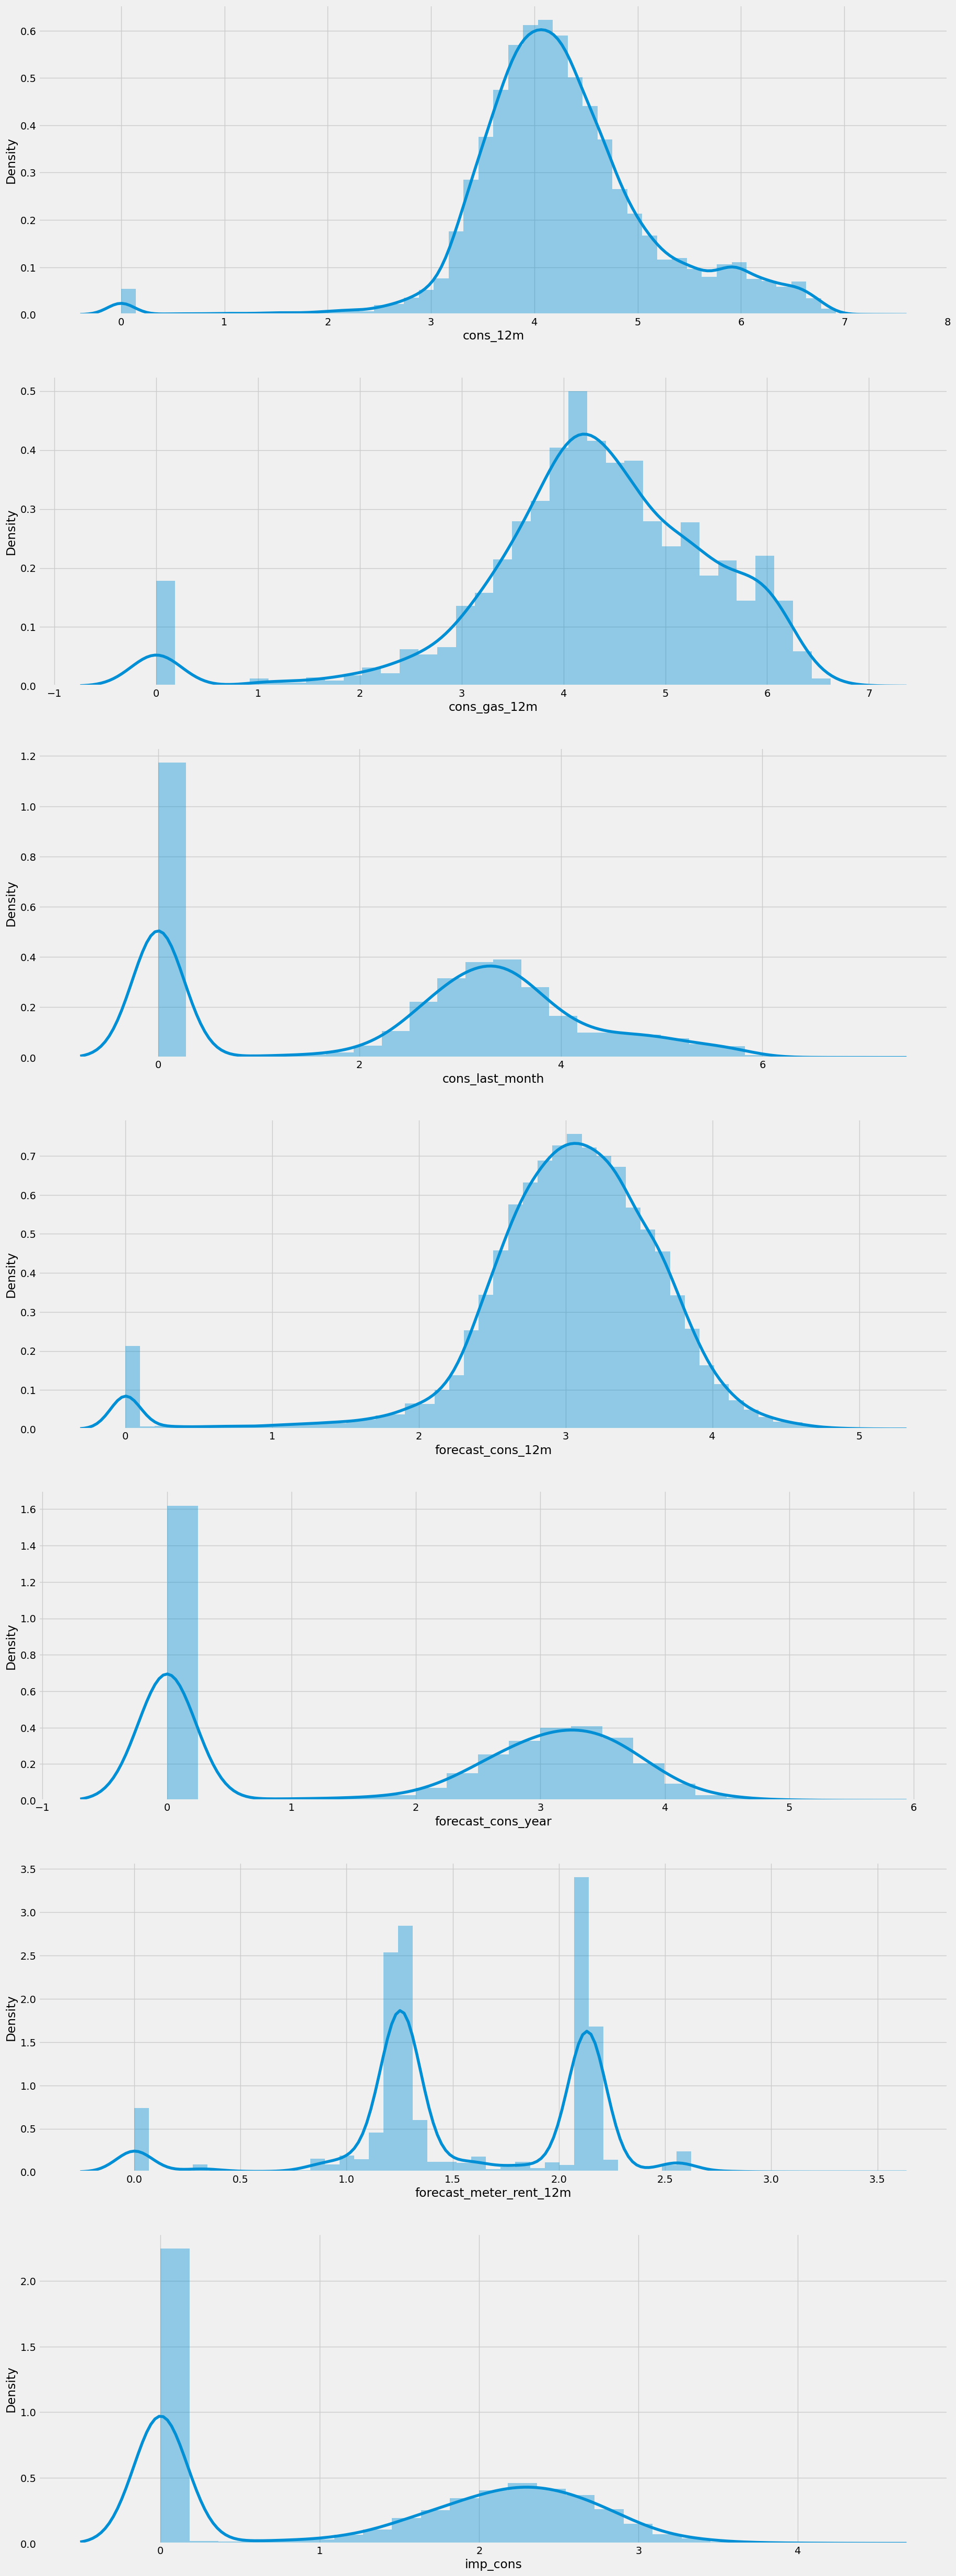

In [125]:
fig, axs = plt.subplots(nrows=7, figsize=(20,60))
sns.distplot((cust_churn['cons_12m'].dropna()), ax=axs[0])
sns.distplot((cust_churn[cust_churn['has_gas']==1]['cons_gas_12m'].dropna()), ax=axs[1])
sns.distplot((cust_churn['cons_last_month'].dropna()), ax=axs[2])
sns.distplot((cust_churn['forecast_cons_12m'].dropna()), ax=axs[3])
sns.distplot((cust_churn['forecast_cons_year'].dropna()), ax=axs[4])
sns.distplot((cust_churn['forecast_meter_rent_12m'].dropna()), ax=axs[5])
sns.distplot((cust_churn['imp_cons'].dropna()), ax=axs[6])
plt.show()

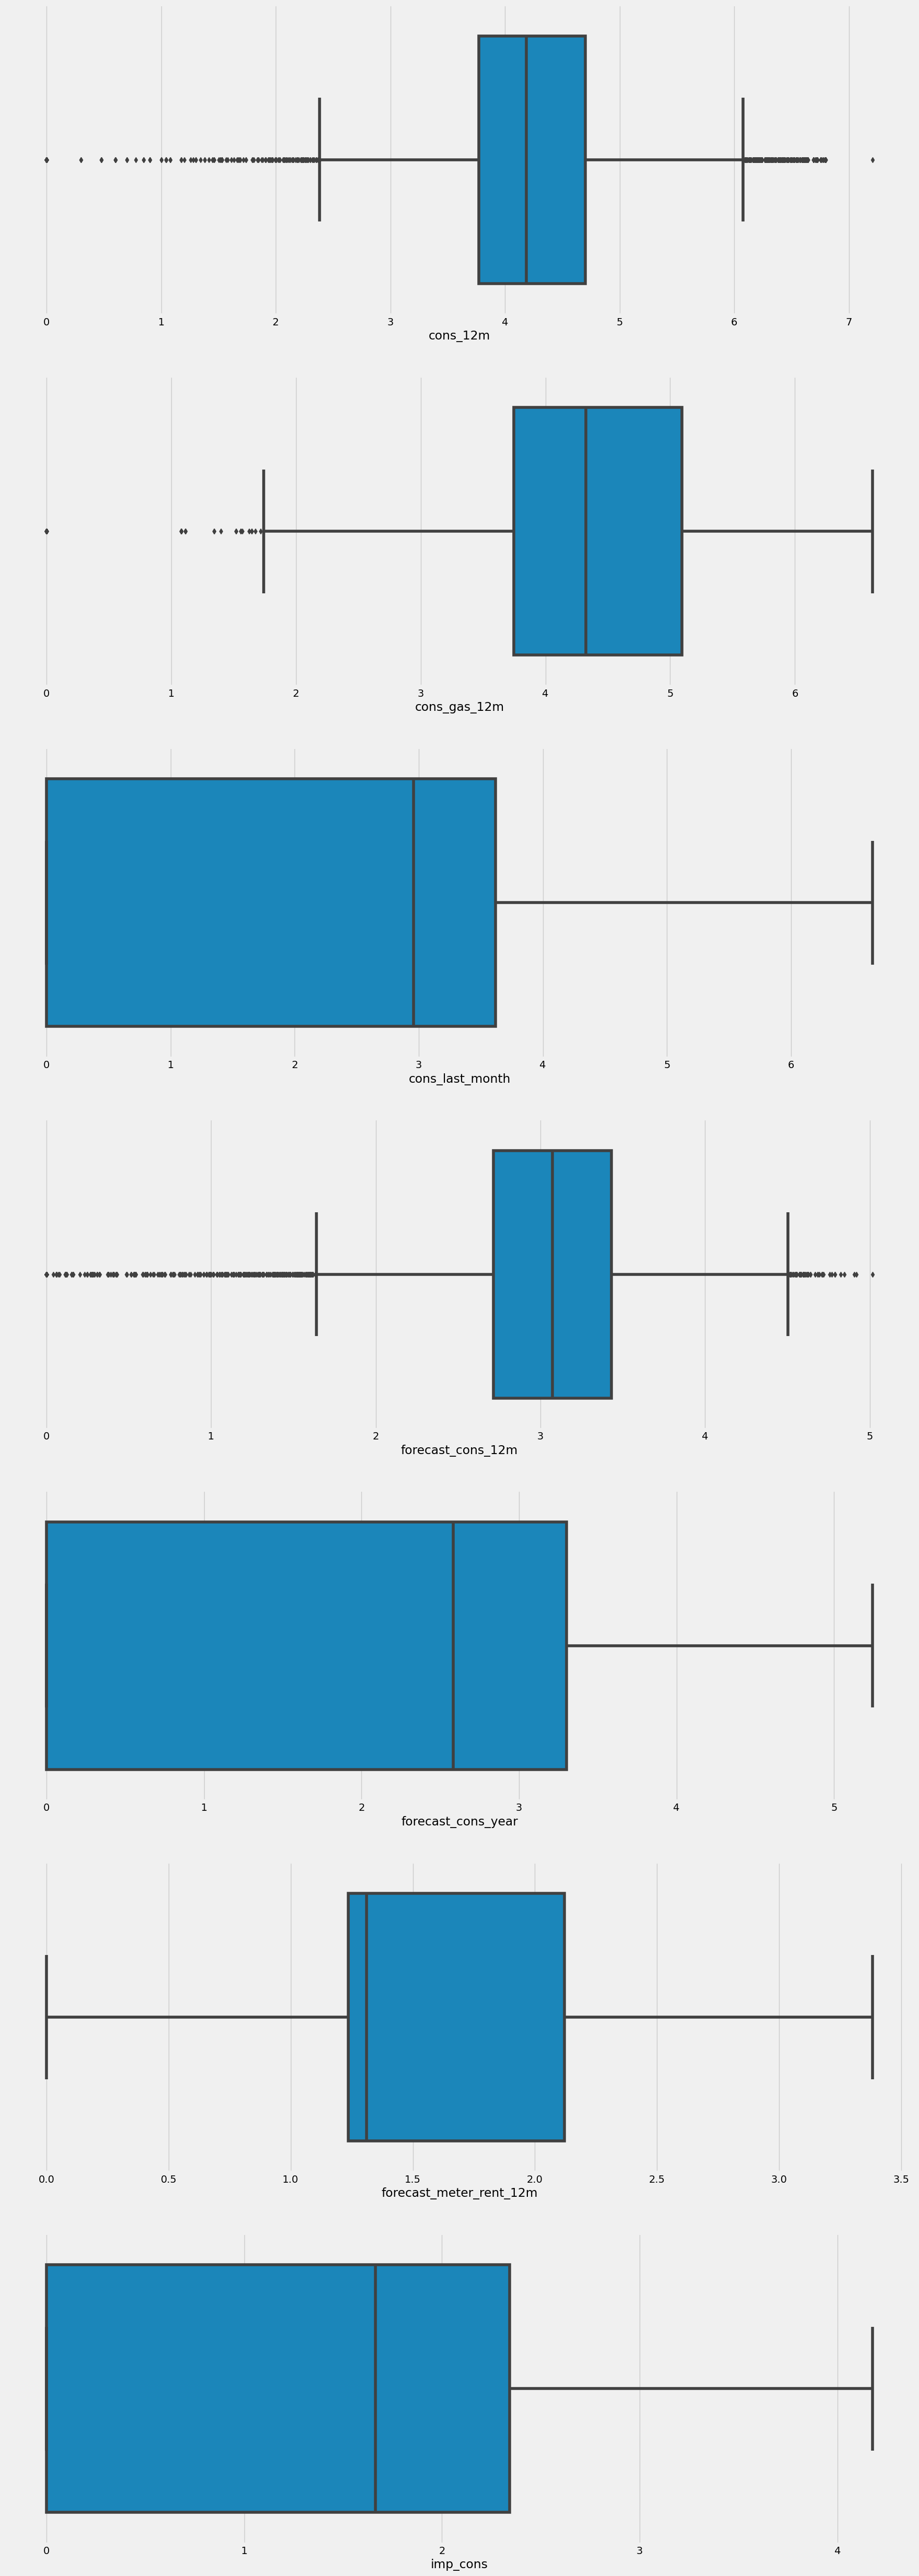

In [126]:
fig, axs = plt.subplots(nrows=7, figsize=(20,60))
sns.boxplot(x=(cust_churn['cons_12m'].dropna()), ax=axs[0])
sns.boxplot(x=(cust_churn[cust_churn['has_gas']==1]['cons_gas_12m'].dropna()), ax=axs[1])
sns.boxplot(x=(cust_churn['cons_last_month'].dropna()), ax=axs[2])
sns.boxplot(x=(cust_churn['forecast_cons_12m'].dropna()), ax=axs[3])
sns.boxplot(x=(cust_churn['forecast_cons_year'].dropna()), ax=axs[4])
sns.boxplot(x=(cust_churn['forecast_meter_rent_12m'].dropna()), ax=axs[5])
sns.boxplot(x=(cust_churn['imp_cons'].dropna()), ax=axs[6])
plt.show()

In [127]:
cust_churn.describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn,tenure,months_activ,months_end,months_modif_prod,months_renewal,channel_epu,channel_ewp,channel_fix,channel_foo,channel_lmk,channel_sdd,channel_usi,origin_ewxe,origin_kamk,origin_ldks,origin_lxid,origin_usap,activity_apd,activity_ckf,activity_clu,activity_cwo,activity_fmw,activity_kkk,activity_kwu,activity_sfi,activity_wxe
count,16069.000000,16090.000000,16050.000000,16055.000000,16071.000000,15970.000000,16092.000000,15970.000000,15970.000000,15970.000000,16096.000000,16069.000000,16083.000000,16083.000000,16096.000000,16081.000000,16096.000000,16093.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.00000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000
mean,4.283812,0.800300,2.359281,3.006826,1.869956,0.991547,1.549610,0.135901,0.052951,43.533496,0.184145,1.305021,22.462276,21.460318,1.347788,217.987028,5.030629,20.604131,0.099093,5.421782,57.890780,6.246769,35.061071,4.85046,0.000249,0.060015,0.000124,0.458313,0.128790,0.000746,0.089712,0.000062,0.280629,0.227634,0.486146,0.000124,0.097975,0.011742,0.007393,0.007580,0.013606,0.026218,0.014289,0.005157,0.007393
std,0.915265,1.748833,1.789067,0.709778,1.612963,5.160969,0.589394,0.026252,0.048617,5.212252,0.387615,1.165532,23.700883,27.917349,1.459808,366.742030,1.676101,21.772421,0.298796,1.718773,19.755206,3.568770,30.108000,3.75630,0.015763,0.237522,0.011147,0.498275,0.334978,0.027295,0.285777,0.007882,0.449320,0.419318,0.499824,0.011147,0.297290,0.107726,0.085668,0.086733,0.115852,0.159787,0.118684,0.071626,0.085668
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.122184,0.000000,0.000000,-525.540000,-615.660000,1.000000,-4148.990000,1.000000,1.000000,0.000000,1.000000,15.000000,-110.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.773786,0.000000,0.000000,2.713952,0.000000,0.000000,1.236285,0.115237,0.000000,40.606701,0.000000,0.000000,11.960000,11.950000,1.000000,51.970000,4.000000,12.500000,0.000000,4.000000,43.000000,3.000000,7.000000,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.187408,0.000000,2.959041,3.073579,2.583199,0.000000,1.310481,0.142881,0.086163,44.311378,0.000000,1.662380,21.090000,20.970000,1.000000,119.680000,5.000000,13.856000,0.000000,5.000000,56.000000,6.000000,29.000000,5.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.701508,0.000000,3.617000,3.430950,3.301030,0.000000,2.122126,0.146348,0.098837,44.311378,0.000000,2.341118,29.640000,29.640000,1.000000,275.810000,6.000000,19.800000,0.000000,6.000000,70.000000,9.000000,63.000000,8.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.206748,6.622052,6.656933,5.016210,5.243970,50.000000,3.382502,0.273963,0.195975,59.444710,1.000000,4.177357,374.640000,374.640000,32.000000,24570.650000,16.000000,500.000000,1.000000,16.000000,181.000000,17.000000,181.000000,29.00000,1.000000,1.000000,1.000000,1.000000,1

From the boxplots we can still see some values are quite far from the range ( outliers ).

### 5.5. High Correlation Features

In [128]:
features = mean_year

correlation = features.select_dtypes(include='number').corr()

In [129]:
correlation

,mean_year_price_p1_var,mean_year_price_p2_var,mean_year_price_p3_var,mean_year_price_p1_fix,mean_year_price_p2_fix,mean_year_price_p3_fix,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3
mean_year_price_p1_var,1.000000,-0.350104,-0.618191,0.418768,-0.652083,-0.592227,0.422491,-0.651410,-0.592401
mean_year_price_p2_var,-0.350104,1.000000,0.828166,-0.103468,0.803035,0.814689,-0.104854,0.804406,0.814826
mean_year_price_p3_var,-0.618191,0.828166,1.000000,-0.141274,0.974711,0.980425,-0.143798,0.974884,0.980604
mean_year_price_p1_fix,0.418768,-0.103468,-0.141274,1.000000,-0.001852,-0.257934,0.999992,-0.002247,-0.257415
mean_year_price_p2_fix,-0.652083,0.803035,0.974711,-0.001852,1.000000,0.926810,-0.004795,0.999997,0.927117
mean_year_price_p3_fix,-0.592227,0.814689,0.980425,-0.257934,0.926810,1.000000,-0.260119,0.927081,1.000000
mean_year_price_p1,0.422491,-0.104854,-0.143798,0.999992,-0.004795,-0.260119,1.000000,-0.005185,-0.259602
mean_year_price_p2,-0.651410,0.804406,0.974884,-0.002247,0.999997,0.927081,-0.005185,1.000000,0.927386
mean_year_price_p3,-0.592401,0.814826,0.980604,-0.257415,0.927117,1.000000,-0.259602,0.927386,1.000000


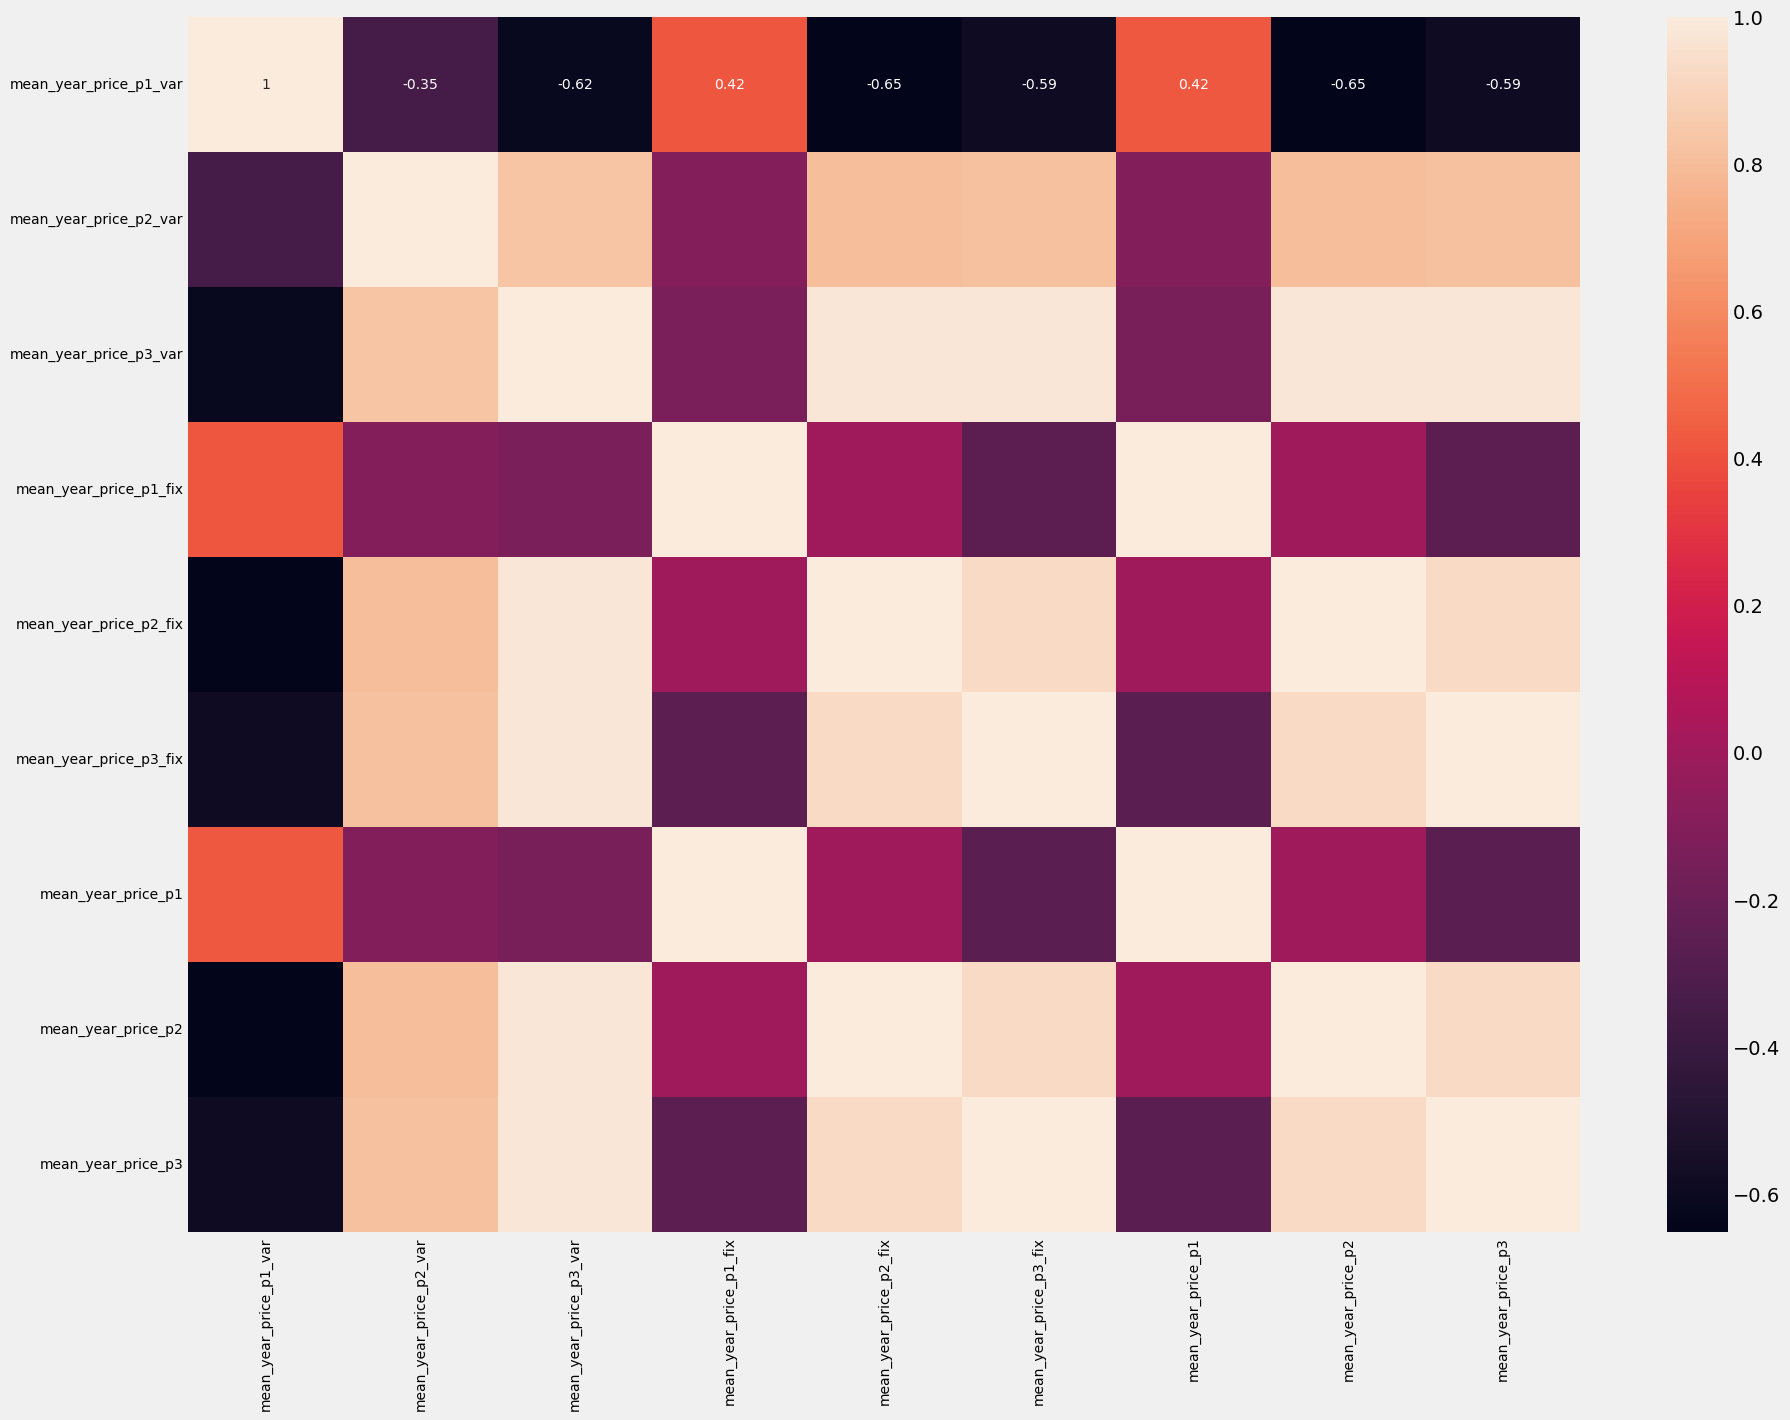

In [130]:
plt.figure(figsize= (20,15))

sns.heatmap(correlation, xticklabels=correlation.columns.values, yticklabels=correlation.columns.values, annot=True,
            annot_kws= {'size': 10})

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

We can remove highly correlated variables.

In [131]:
correlation = cust_churn.select_dtypes(include='number').corr()
correlation

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn,tenure,months_activ,months_end,months_modif_prod,months_renewal,channel_epu,channel_ewp,channel_fix,channel_foo,channel_lmk,channel_sdd,channel_usi,origin_ewxe,origin_kamk,origin_ldks,origin_lxid,origin_usap,activity_apd,activity_ckf,activity_clu,activity_cwo,activity_fmw,activity_kkk,activity_kwu,activity_sfi,activity_wxe
cons_12m,1.000000,0.228876,0.647210,0.581020,0.353134,-0.033156,0.233436,-0.194707,0.303323,-0.108078,0.168852,0.364006,-0.114627,-0.066811,0.144748,0.365112,0.030641,0.224916,-0.024490,-0.004437,0.019259,-0.087112,0.070610,0.075897,0.002843,-0.070605,0.009382,-0.026563,0.294467,-0.005790,-0.138270,-0.006706,0.020662,-0.010565,-0.009603,0.003803,0.573379,0.004237,-0.002542,-0.018361,0.031016,0.013529,0.051092,0.017331,-0.012274
cons_gas_12m,0.228876,1.000000,0.179728,0.112772,0.083303,0.002812,0.059915,-0.037409,0.078407,-0.048262,0.942306,0.091496,-0.021467,-0.009342,0.421692,0.089125,0.014065,0.051271,-0.032935,0.007908,0.012373,0.005038,0.007476,0.000494,0.005474,-0.007765,0.012995,-0.048543,0.050488,-0.005834,-0.018948,-0.003608,0.008502,-0.003094,-0.005927,-0.005102,0.143979,0.027603,-0.016975,0.015216,0.043359,0.034373,0.097908,0.000596,-0.033529
cons_last_month,0.647210,0.179728,1.000000,0.333177,0.789374,-0.021204,0.341073,-0.273247,0.413813,-0.094703,0.137190,0.777624,-0.039002,-0.008143,0.114088,0.267391,0.050017,0.234859,-0.023364,0.016077,0.038903,-0.081141,0.070059,0.062496,0.008650,-0.071768,0.002424,0.000852,0.208514,-0.005894,-0.121423,-0.010410,-0.039458,-0.004759,0.039700,0.009611,0.446227,0.016078,0.005268,-0.010820,0.023280,0.003816,0.040482,0.009532,-0.006628
forecast_cons_12m,0.581020,0.112772,0.333177,1.000000,0.401819,0.043227,0.270671,-0.032467,0.256314,0.112277,0.095316,0.463428,-0.157408,-0.114057,0.034239,0.481463,-0.037348,0.233619,0.007372,-0.045437,-0.039866,-0.078878,-0.076521,0.084348,0.009414,-0.016402,0.001854,0.049779,0.085574,0.007597,-0.048166,-0.003638,-0.046517,0.000944,0.041074,-0.000067,0.130510,0.006886,-0.017893,-0.017681,0.079414,0.010944,0.097650,0.003208,0.007251
forecast_cons_year,0.353134,0.083303,0.789374,0.401819,1.000000,0.003224,0.410313,-0.334239,0.447548,-0.102624,0.066965,0.984669,-0.041390,-0.012083,0.042012,0.299959,0.054251,0.268242,-0.000794,0.034113,0.049736,-0.052372,0.012132,0.043272,0.014375,-0.041463,0.000573,0.043936,0.046737,0.001759,-0.072691,-0.009146,-0.107257,0.012300,0.085713,0.008968,0.130788,0.011343,-0.002286,-0.009017,0.053148,-0.006160,0.066759,-0.002161,-0.000439
forecast_discount_energy,-0.033156,0.002812,-0.021204,0.043227,0.003224,1.000000,-0.014334,0.319202,0.049174,0.024477,0.005876,0.015988,0.199609,0.151140,0.055162,0.013500,-0.071723,-0.022646,0.012344,-0.108746,-0.072810,-0.054351,-0.182152,0.191422,-0.003041,0.000107,-0.002150,0.050264,-0.047912,-0.005269,0.035136,-0.001520,-0.053621,-0.031940,0.074035,-0.002150,-0.060098,0.007023,-0.009534,0.005600,-0.001376,-0.012893,0.008260,-0.004775,0.001412
forecast_meter_rent_12m,0.233436,0.059915,0.341073,0.270671,0.410313,-0.014334,1.000000,-0.453746,0.649773,0.003275,0.046967,0.395690,0.020926,0.039695,-0.001289,0.247628,0.076301,0.375352,0.030921,0.069359,0.076403,-0.038499,0.019739,0.031530,0.014208,-0.017418,0.001856,0.024179,0.021189,-0.017069,-0.074647,-0.006370,-0.075325,0.077678,0.001382,-0.003832,0.045232,0.038122,0.010088,0.000704,0.055416,0.026596,0.072715,-0.009586,0.004582
forecast_price_energy_p1,-0.194707,-0.037409,-0.273247,-0.032467,-0.334239,0.319202,-0.453746,1.000000,-0.364849,0.389218,-0.026941,-0.275551,0.184782,0.029119,0.025854,-0.185221,-0.199922,-0.352961,-0.003337,-0.184693,-0.198179,-0.017726,-0.121088,0.074709,-0.014397,0.029368,0.002077,0.015210,-0.

As expected, num_years_antig has a high correlation with months_activ (it provides us the same information).<br>
We can remove variables with very high correlation.

In [132]:
cust_churn.drop(columns=['num_years_antig', 'forecast_cons_year'], inplace=True)

### 5.6. Outliers Removal
The consumption data has several outliers. Need to remove those outliers
The most common way to identify an outlier are either:<br>
1. Data point that falls outside of 1.5 times of an interquartile range above the 3rd quartile and below the 1st quartile OR, <br>
2. Data point that falls outside of 3 standard deviations.

We will replace the outliers with the mean (average of the values excluding outliers).

In [133]:
# Replace outliers with the mean values using the Z score.
# Nan values are also replaced with the mean values.

def replace_z_score(df, col, z=3):
    
    from scipy.stats import zscore
    
    temp_df = df.copy(deep=True)
    temp_df.dropna(inplace=True, subset=[col])
    
    temp_df["zscore"] = zscore(df[col])
    mean_=temp_df[(temp_df['zscore'] > -z) & (temp_df['zscore'] < z)][col].mean()
    
    df[col] = df[col].fillna(mean_)
    df['zscore']=zscore(df[col])
    no_outlier=df[(df['zscore'] < -z) | (df['zscore'] > z)].shape[0]
    df.loc[(df['zscore'] < -z) | (df['zscore'] > z) , col] = mean_
    
    print('Replaced : {} outliers in {}'.format(no_outlier, col))
    return df.drop(columns='zscore')

In [134]:
features.columns

Index(['id', 'price_date', 'mean_year_price_p1_var', 'mean_year_price_p2_var',
       'mean_year_price_p3_var', 'mean_year_price_p1_fix',
       'mean_year_price_p2_fix', 'mean_year_price_p3_fix',
       'mean_year_price_p1', 'mean_year_price_p2', 'mean_year_price_p3'],
      dtype='object')

In [135]:
for feat in features.columns:
    if (feat!= 'id') & (feat!= 'price_date'):
        features = replace_z_score(features,feat)

Replaced : 276 outliers in mean_year_price_p1_var
Replaced : 0 outliers in mean_year_price_p2_var
Replaced : 0 outliers in mean_year_price_p3_var
Replaced : 120 outliers in mean_year_price_p1_fix
Replaced : 0 outliers in mean_year_price_p2_fix
Replaced : 0 outliers in mean_year_price_p3_fix
Replaced : 122 outliers in mean_year_price_p1
Replaced : 0 outliers in mean_year_price_p2
Replaced : 0 outliers in mean_year_price_p3


In [136]:
features.reset_index(drop=True, inplace=True)
# features

When carrying out the log transformation , the dataset has several outliers.

What are the criteria to identify an outlier?
The most common way to identify an outlier are:
1. Data point that falls outside of 1.5 times of an interquartile range above the 3rd quartile and below the 1st quartile
OR
2. Data point that falls outside of 3 standard deviations.
Once, we have identified the outlier, What do we do with the outliers?
There are several ways to handle with those outliers such as removing them (this works well for massive datasets) or replacing them with sensible data
(works better when the dataset is not that big).
We will replace the outliers with the mean (average of the values excluding outliers).

In [137]:
def find_outliers_iqr(df, column):

    #lets make sure column data is sorted
    col = sorted(column)

    q1,q3 = np.percentile(col, [25,75])
    iqr= q3 - q1
    lower_bound = q1 - (1.5*iqr)
    upper_bound = q3 + (1.5*iqr)

    result_outliers = {'iqr' : iqr , 'lower_bound' : lower_bound , 'upper_bound' : upper_bound}

    return result_outliers

In [138]:
def remove_ouliers_iqr(df, col):

    outliers = find_outliers_iqr(df, col)
    removed_outliers = df[ df[col] < outliers['lower_bound'] | df[col] > outliers['upper_bound'] ].shape

    df= df[ df[col] > outliers['lower_bound'] | df[col] < outliers['upper_bound'] ]
    print(f"Removed {removed_outliers[0]} outliers")

    return df

In [139]:
def remove_outliers_zscore(df, col, z=3):
    
    from scipy.stats import zscore
    
    df["zsscore"]=zscore(df[col])
    removed_outliers = df[(df["zscore"] < -z) | (df["zscore"] > z)].shape
    df = df[(df["zscore"] > -z) | (df["zscore"] < z)]
    
    print('Removed: {} otliers of {}'.format(removed_outliers[0], col))
    
    return df.drop(columns="zscore")

In [140]:
def replace_outliers_z_score(df, col, z=3):
    
    from scipy.stats import zscore
    
    temp_df = df.copy(deep=True)
    #temp_df.dropna(inplace=True, subset=[col])
    
    temp_df["zscore"] = zscore(df[col])
    mean_=temp_df[(temp_df["zscore"] > -z) & (temp_df["zscore"] < z)][col].mean()
    
    num_outliers = df[col].isnull().sum()
    df[col] = df[col].fillna(mean_)
    df["zscore"]=zscore(df[col])
    df.loc[(df["zscore"] < -z) | (df["zscore"] > z) , col] = mean_
    
    print('Replaced : {} outliers in {}'.format(num_outliers, col))
    return df.drop(columns="zscore")

In [141]:
cust_churn = replace_outliers_z_score(cust_churn , 'cons_12m')
cust_churn = replace_outliers_z_score(cust_churn , 'cons_gas_12m')
cust_churn = replace_outliers_z_score(cust_churn , 'cons_last_month')
cust_churn = replace_outliers_z_score(cust_churn , 'forecast_cons_12m')
cust_churn = replace_outliers_z_score(cust_churn , 'forecast_discount_energy')
cust_churn = replace_outliers_z_score(cust_churn , 'forecast_meter_rent_12m')
cust_churn = replace_outliers_z_score(cust_churn , 'forecast_price_energy_p1')
cust_churn = replace_outliers_z_score(cust_churn , 'forecast_price_energy_p2')
cust_churn = replace_outliers_z_score(cust_churn , 'forecast_price_pow_p1')
cust_churn = replace_outliers_z_score(cust_churn , 'imp_cons')
cust_churn = replace_outliers_z_score(cust_churn , 'margin_gross_pow_ele')
cust_churn = replace_outliers_z_score(cust_churn , 'margin_net_pow_ele')
cust_churn = replace_outliers_z_score(cust_churn , 'net_margin')
cust_churn = replace_outliers_z_score(cust_churn , 'pow_max')
cust_churn = replace_outliers_z_score(cust_churn , 'months_activ')
cust_churn = replace_outliers_z_score(cust_churn , 'months_end')
cust_churn = replace_outliers_z_score(cust_churn , 'months_modif_prod')
cust_churn = replace_outliers_z_score(cust_churn , 'months_renewal')

Replaced : 27 outliers in cons_12m
Replaced : 6 outliers in cons_gas_12m
Replaced : 46 outliers in cons_last_month
Replaced : 41 outliers in forecast_cons_12m
Replaced : 126 outliers in forecast_discount_energy
Replaced : 4 outliers in forecast_meter_rent_12m
Replaced : 126 outliers in forecast_price_energy_p1
Replaced : 126 outliers in forecast_price_energy_p2
Replaced : 126 outliers in forecast_price_pow_p1
Replaced : 27 outliers in imp_cons
Replaced : 13 outliers in margin_gross_pow_ele
Replaced : 13 outliers in margin_net_pow_ele
Replaced : 15 outliers in net_margin
Replaced : 3 outliers in pow_max
Replaced : 0 outliers in months_activ
Replaced : 0 outliers in months_end
Replaced : 0 outliers in months_modif_prod
Replaced : 0 outliers in months_renewal


In [142]:
cust_churn.reset_index(drop=True, inplace=True)
# cust_churn

Lets check how the box plot has changed

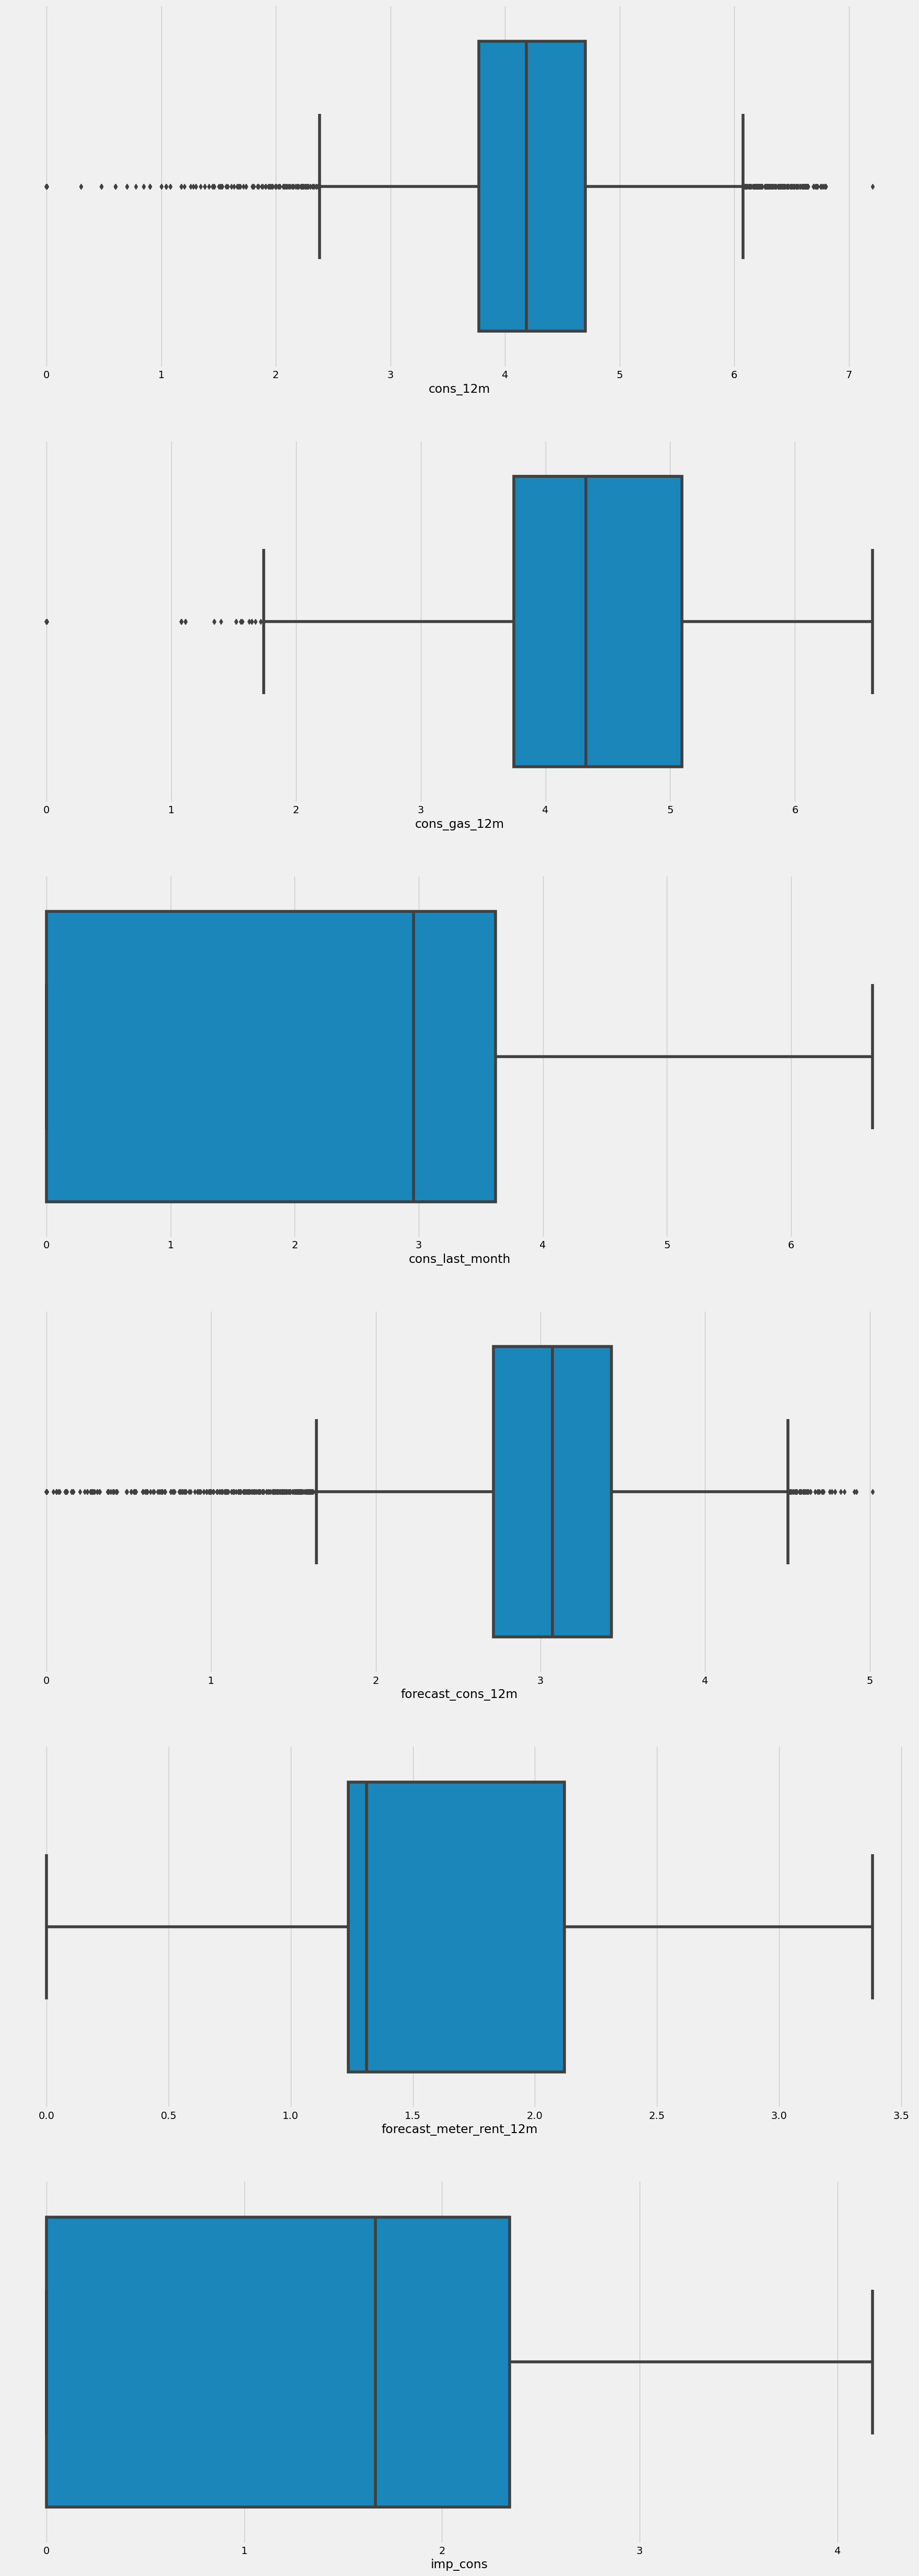

In [143]:
fig, axs = plt.subplots(nrows=6, figsize=(20,60))
sns.boxplot(x=(cust_churn['cons_12m'].dropna()), ax=axs[0])
sns.boxplot(x=(cust_churn[cust_churn['has_gas']==1]['cons_gas_12m'].dropna()), ax=axs[1])
sns.boxplot(x=(cust_churn['cons_last_month'].dropna()), ax=axs[2])
sns.boxplot(x=(cust_churn['forecast_cons_12m'].dropna()), ax=axs[3])
sns.boxplot(x=(cust_churn['forecast_meter_rent_12m'].dropna()), ax=axs[4])
sns.boxplot(x=(cust_churn['imp_cons'].dropna()), ax=axs[5])
plt.show()

In [144]:
# Loading JS visualization 
shap.initjs()

In [145]:
train = pd.merge(cust_churn, hist_price, on='id')
# train

In [146]:
pd.DataFrame({'Columns': train.columns})

,Columns
0,id
1,cons_12m
2,cons_gas_12m
3,cons_last_month
4,forecast_cons_12m
5,forecast_discount_energy
6,forecast_meter_rent_12m
7,forecast_price_energy_p1
8,forecast_price_energy_p2
9,forecast_price_pow_p1


## 6. Churn prediction Model with XGBoost

### 6.1 Splitting Dataset

In [147]:
y = train['churn']
X = train.drop(labels=['id', 'churn', 'price_date'], axis=1) ## Similar to drop(columns=[])

In [148]:
X_train, X_test, y_train, y_test =  train_test_split(X,y, test_size=0.33, random_state=42)

### 6.2 Modelling

In [149]:
# XGBoost algorithm is used to handle mistakes from previous trees and improves prediction over time  / also hanlde complex relationship

model = xgb.XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=500, n_jobs= -1)
result = model.fit(X_train,y_train)

### 6.3 Model Evaluation

We are going to evaluate our model on our test data (which we did not use for training) using the evalution metrics <b>Accuracy, Precision, Recall</b>

In [150]:
def evaluation(model_, X_test_, y_test_):
    
    predict_test = model_.predict(X_test_)
    results = pd.DataFrame({'Accuracy' : [metrics.accuracy_score(y_test_, predict_test)],
                           'Precision' : [metrics.precision_score(y_test_, predict_test)],
                           'Recall' : [metrics.recall_score(y_test_, predict_test)]})
    
    print(metrics.classification_report(y_test_, predict_test))
    print('--'*40)
    
    return results

In [151]:
evaluation(model, X_test, y_test)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     57445
           1       1.00      0.82      0.90      6246

    accuracy                           0.98     63691
   macro avg       0.99      0.91      0.94     63691
weighted avg       0.98      0.98      0.98     63691

--------------------------------------------------------------------------------


,Accuracy,Precision,Recall
0,0.98196,0.999216,0.816683


<b>ROC-AUC :</b> Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivityand specificity.

In [152]:
def calculation_roc_auc(model_, X_test_, y_test_): 

    # Get the model predictions, class 1 -> churn
    prediction_test_ = model_.predict_proba(X_test_)[:,1]

    # Computing roc-auc
    fpr, tpr, thresholds = metrics.roc_curve(y_test_, prediction_test_)
    score = pd.DataFrame({"ROC-AUC" : [metrics.auc(fpr, tpr)]})

    return fpr, tpr, score

def plot_roc_auc(fpr,tpr):
    f, ax = plt.subplots(figsize=(14,8))

    # Plot ROC
    roc_auc = metrics.auc(fpr, tpr) 
    ax.plot(fpr, tpr, lw=2, alpha=0.3,
    label="AUC = %0.2f" % (roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r', label="Random", alpha=.8)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05]) 
    ax.set_xlabel("False Positive Rate (FPR)") 
    ax.set_ylabel("True Positive Rate (TPR)") 
    ax.set_title("ROC-AUC") 
    ax.legend(loc="lower right")
    plt.show()


In [153]:
fpr, tpr, auc_score = calculation_roc_auc(model, X_test, y_test)

In [154]:
auc_score

,ROC-AUC
0,0.999223


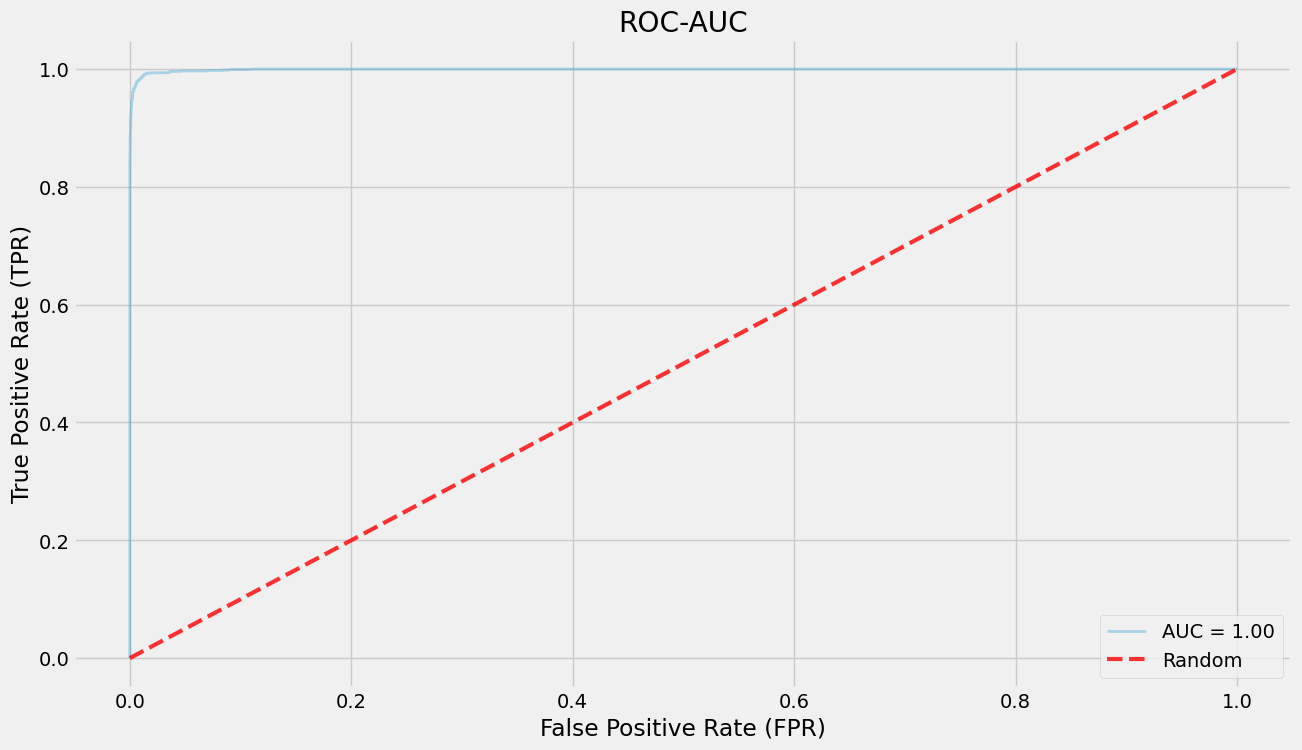

In [155]:
plot_roc_auc(fpr, tpr) 
plt.show()

### 6.4. Stratiﬁed K-fold validation

In [156]:
def plot_roc_curve(fprs, tprs): 

    tprs_interp = [] 
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(18,10))

    # Plot ROC for each K-Fold and compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)): 
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr)) 
        tprs_interp[-1][0] = 0.0
        roc_auc = metrics.auc(fpr, tpr) 
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=2, alpha=0.3, label="ROC fold %d (AUC = %0.2f)" % (i, roc_auc))

    plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r', label="Random", alpha=.8)

    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0) 
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr) 
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b', label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc), 
            lw=4, alpha=.8)

    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0) 
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1) 
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=.2, label=r"$\pm$ 1 std. dev.")

    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05]) 
    ax.set_xlabel("False Positive Rate (FPR)") 
    ax.set_ylabel("True Positive Rate (TPR)") 
    ax.set_title("ROC-AUC") 
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

In [157]:
def compute_roc_auc(model_, index):
    y_predict = model_.predict_proba(X.iloc[index])[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y.iloc[index], y_predict) 
    auc_score = metrics.auc(fpr, tpr)
    return fpr, tpr, auc_score

In [158]:
cv = StratifiedKFold(n_splits=3, random_state=42, shuffle=True) 
fprs, tprs, scores = [], [], []

In [159]:
for (train, test), i in zip(cv.split(X, y), range(3)):
    model.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(model, train) 
    fpr, tpr, auc_score = compute_roc_auc(model, test) 
    scores.append((auc_score_train, auc_score)) 
    fprs.append(fpr)
    tprs.append(tpr)

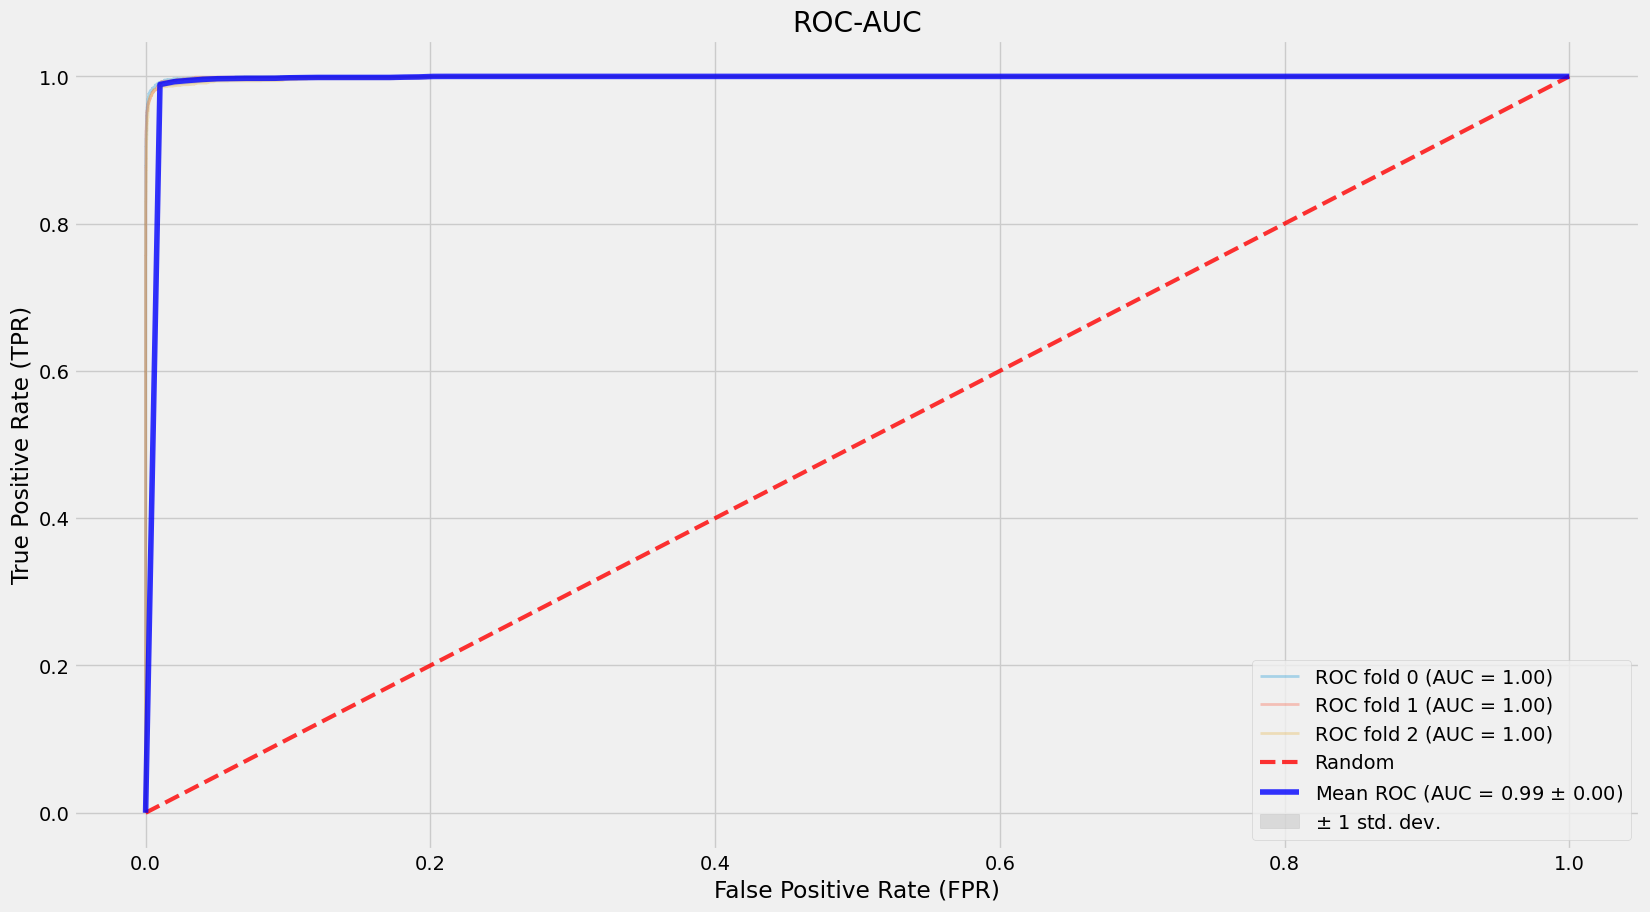

In [160]:
plot_roc_curve(fprs, tprs) 
plt.show()

### 6.5 Model Fine tuning

### 6.5.1 Grid search with cross validation

In [161]:
## Now we have build a model and made our predicton, Lets move ahead and use Grid search to fine tune parameters of modle

In [162]:
from sklearn.model_selection import GridSearchCV

# Parameter grid based on the results of random search
param_grid ={'subsample': [0.7],
'scale_pos_weight': [1],
'n_estimators': [1100],
'min_child_weight': [1],
'max_depth': [12, 13, 14],
'learning_rate': [0.005, 0.01],
'gamma': [4.0],
'colsample_bytree': [0.6]}

Info: for above paramet grid

| Parameter          | Meaning                                                               |
| ------------------ | --------------------------------------------------------------------- |
| `subsample`        | Fraction of rows used per tree (0.7 = 70%)                            |
| `scale_pos_weight` | Used for imbalanced classes (1 = no weighting)                        |
| `n_estimators`     | Total number of trees (boosting rounds)                               |
| `min_child_weight` | Minimum sum of weights needed in a child node                         |
| `max_depth`        | Maximum tree depth (controls model complexity)                        |
| `learning_rate`    | How much the model adjusts per tree (lower = slower but more precise) |
| `gamma`            | Minimum loss reduction to make a split (regularization)               |
| `colsample_bytree` | Fraction of features used per tree                                    |


In [163]:
# Create model
xg = xgb.XGBClassifier(objective='binary:logistic',verbosity=0, nthread=1, use_label_encoder= False)

In [164]:
# Grid search model
grid_search = GridSearchCV(estimator = xg, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2, scoring = "roc_auc")

In [167]:
from xgboost import XGBClassifier

# Fit the grid search to the data
grid_search.fit(X_train,y_train)  ## this will take some time, Go grab a coffee 🍵

Fitting 3 folds for each of 6 candidates, totalling 18 fits


,estimator,"XGBClassifier...thread=1, ...)"
,param_grid,"{'colsample_bytree': [0.6], 'gamma': [4.0], 'learning_rate': [0.005, 0.01], 'max_depth': [12, 13, ...], ...}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [ ]:
import xgboost, sklearn 
print(xgboost .__version__)

print(sklearn .__version__)

3.0.2
1.7.0


In [168]:
best_grid = grid_search.best_params_ 
best_grid

{'colsample_bytree': 0.6,
 'gamma': 4.0,
 'learning_rate': 0.01,
 'max_depth': 14,
 'min_child_weight': 1,
 'n_estimators': 1100,
 'scale_pos_weight': 1,
 'subsample': 0.7}

In [170]:
# Model with the parameters found
model_grid = xgb.XGBClassifier(objective='binary:logistic',silent=True, nthread=1, **best_grid) 

In [171]:
fprs, tprs, scores = [], [], []

for (train, test), i in zip(cv.split(X, y), range(3)): 
    model_grid.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(model_grid, train) 
    fpr, tpr, auc_score = compute_roc_auc(model_grid, test) 
    scores.append((auc_score_train, auc_score)) 
    fprs.append(fpr)
    tprs.append(tpr)

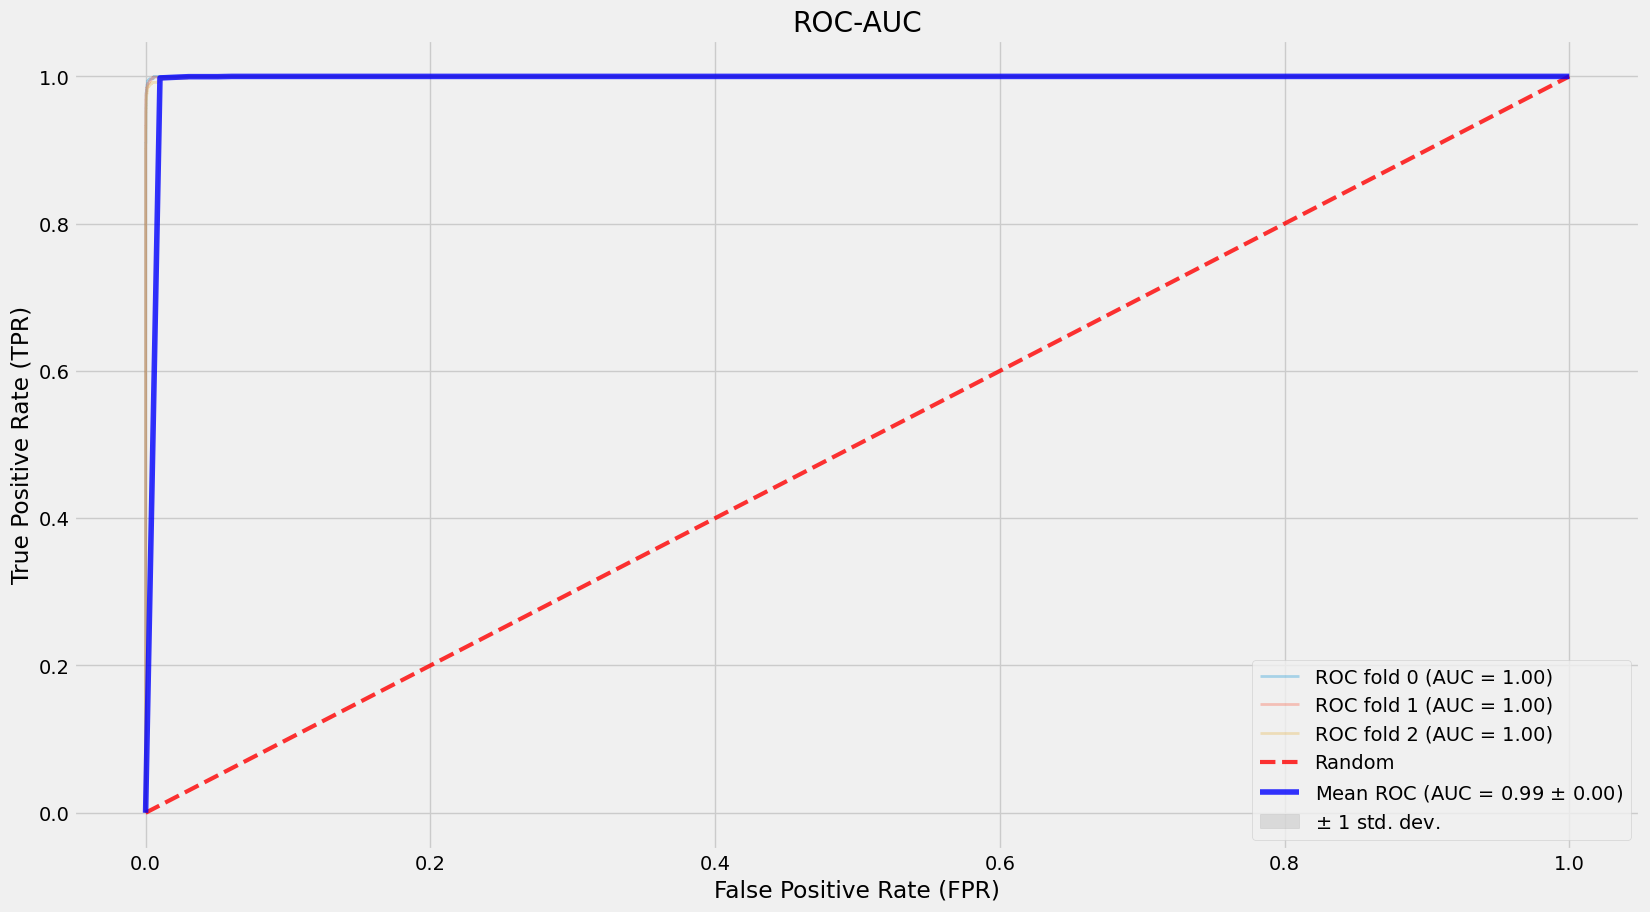

In [172]:
plot_roc_curve(fprs, tprs) 
plt.show()

## 7. Model Understanding

### 7.1. Feature Importance
Feature importance is done by counting the number of times each feature is split on across all boosting rounds (trees) in the model, and then visualizing the result as a bar graph, with the features ordered according to how many times they appear.

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

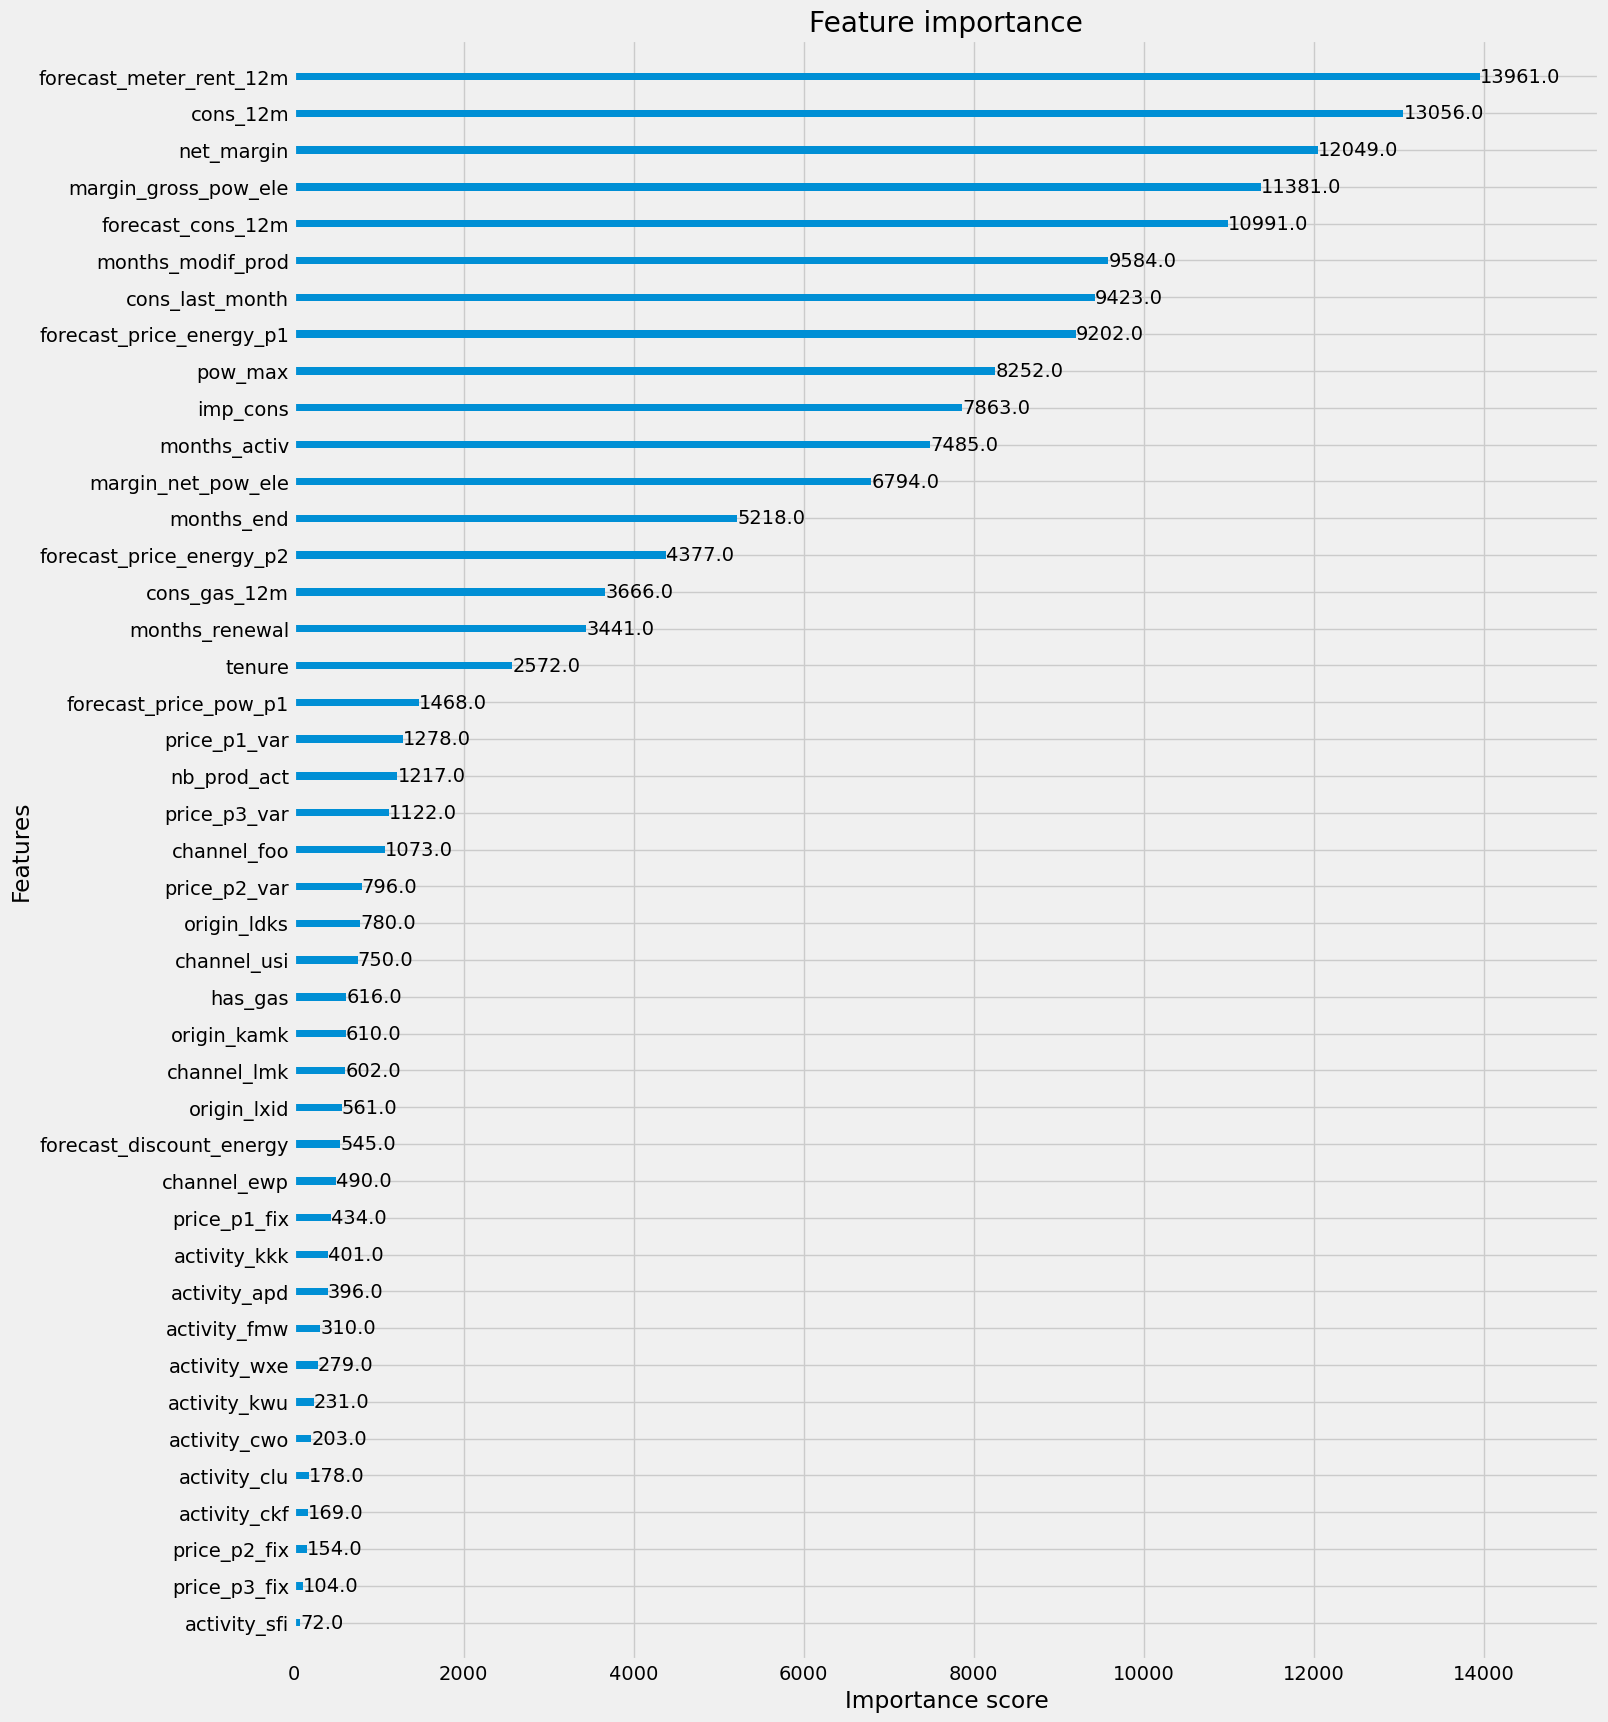

In [173]:
fig, ax = plt.subplots(figsize=(15,20)) 
xgb.plot_importance(model_grid, ax=ax)

In the feature importance graph above we can see that cons_12m, forecast_meter_rent_12m, forecast_cons_12m, margin_gross_pow_ele and net_margin are the features that appear the most in our model and we could infere that these two features have a signiﬁcant importnace in our model